===============================================================================

Project Name: Credit Card Customer Segmentation using BigQuery and Scikit-Learn  
Author : Fazrin Muhammad 

===============================================================================

# **1. Perkenalan**

Sebuah bank besar ingin meningkatkan strategi pemasaran, layanan pelanggan, dan penawaran produknya dengan lebih memahami pelanggannya. Untuk mencapai ini, tim data science ditugaskan untuk melakukan segmentasi pelanggan menggunakan data penggunaan kartu kredit dari enam bulan terakhir. Mereka akan menggunakan BigQuery untuk mengambil dan memproses data dalam volume besar secara efisien, mengekstrak informasi seperti jumlah transaksi, frekuensi, jenis pembelian, dan perilaku pembayaran. Setelah membersihkan dan memproses data, tim akan menggunakan Scikit-Learn untuk mengimplementasikan model clustering. Dengan menganalisis cluster yang dihasilkan, mereka bertujuan untuk mengidentifikasi segmen pelanggan yang berbeda dan mengembangkan profil terperinci untuk masing-masing, menggambarkan perilaku pengeluaran dan pola transaksi. Wawasan ini akan membantu tim pemasaran dan layanan pelanggan bank menciptakan strategi yang ditargetkan dan layanan yang dipersonalisasi, meningkatkan kepuasan pelanggan dan profitabilitas secara keseluruhan.

# **2. Query SQL**  

- Project   : ftds-hacktiv8-project  
- Dataset   : ml_datasets  
- Database  : credit_card_default 

```SQL
# query data dari
import pandas as pd
df = client.query('''

SELECT *
FROM `ftds-hacktiv8-project.phase1_ftds_014_hck.credit-card-information`
WHERE MOD(CUST_ID, 2) = 0 

''').to_dataframe()

# Save csv
from google.colab import files
df.to_csv('P1G6_Set_1_fazrinmuh.csv', index=False) 
files.download('P1G6_Set_1_fazrinmuh.csv')
```

**Data Description**  
<img src='https://i.ibb.co/2sbf0Js/P1-G4-Dataset-Information.png'>

# **3. Impor Modul**

In [4]:
# For Data Manipulation
import pandas as pd
import numpy as np

# For Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from yellowbrick.cluster import SilhouetteVisualizer
import matplotlib.cm as cm
from sklearn.metrics import silhouette_score,silhouette_samples

# For Feature Engineering
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from feature_engine.outliers import Winsorizer
from sklearn.decomposition import PCA

# For Models
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans

# For Saving Models
import pickle

# To Deactivate Warnings
import warnings
warnings.filterwarnings('ignore')

# Displaying all columns
pd.options.display.max_columns = 200
pd.options.display.max_rows = 200


**Penjelasan**  
Impor modul sudah berhasil dilakukan.

# **4. Data Loading**

In [5]:
# Data loading
data = pd.read_csv('P1G6_Set_1_fazrinmuh.csv')

**Penjelasan**  
Loading data yang telah disimpan sebelumnya untuk dilakukan analisa.

In [6]:
# Show 10 head data
data.head(10)

CUST_ID      BALANCE  BALANCE_FREQUENCY  PURCHASES  ONEOFF_PURCHASES  \
0      788    16.581535           0.125000      200.0               0.0   
1     1902   943.584041           0.875000      103.0             103.0   
2     2322     1.979916           0.125000       80.0              80.0   
3     3426   461.455720           1.000000      585.0             585.0   
4     3976  1053.594730           1.000000     1450.0            1450.0   
5     4266  2237.238086           1.000000      120.0             120.0   
6     4360  2730.843802           1.000000     2900.0            2900.0   
7     4680   424.994385           0.375000     1200.0            1200.0   
8     5884    18.885677           0.375000       57.0              57.0   
9       24     0.004816           0.545455       51.7               0.0   

   INSTALLMENTS_PURCHASES  CASH_ADVANCE  PURCHASES_FREQUENCY  \
0                   200.0           0.0                0.125   
1                     0.0           0.0                0.125   
2                     0.0           0.0                0.125   
3                     0.0           0.0                0.125   
4                     0.0           0.0                0.125   
5                     0.0           0.0                0.125   
6                     0.0           0.0                0.125   
7                     0.0           0.0                0.125   
8                     0.0           0.0                0.125   
9                    51.7           0.0                0.250   

   ONEOFF_PURCHASES_FREQUENCY  PURCHASES_INSTALLMENTS_FREQUENCY  \
0                       0.000                             0.125   
1                       0.125                             0.000   
2                       0.125                             0.000   
3                       0.125                             0.000   
4                       0.125                             0.000   
5                       0.125                             0.000   
6                       0.125                             0.000   
7                       0.125                             0.000   
8                       0.125                             0.000   
9                       0.000                             0.250   

   CASH_ADVANCE_FREQUENCY  CASH_ADVANCE_TRX  PURCHASES_TRX  CREDIT_LIMIT  \
0                     0.0                 0              2        1200.0   
1                     0.0                 0              1        1000.0   
2                     0.0                 0              1        1500.0   
3                     0.0                 0              1        1000.0   
4                     0.0                 0              1        1500.0   
5                     0.0                 0              1        2500.0   
6                     0.0                 0              1        2900.0   
7                     0.0                 0              1        1200.0   
8                     0.0                 0              1        1500.0   
9                     0.0                 0              3        3000.0   

     PAYMENTS  MINIMUM_PAYMENTS  PRC_FULL_PAYMENT  TENURE  
0    0.000000               NaN               0.0       8  
1  215.325023        410.484825               0.0       8  
2    0.000000               NaN               0.0       8  
3  258.032630        151.696433               0.0       8  
4  397.090516        227.143184               0.0       8  
5  343.102984        712.986387               0.0       8  
6    0.000000               NaN               0.0       8  
7   57.266292         56.720210               0.0       8  
8    0.000000               NaN               0.0       8  
9   33.249088          0.059481               0.0      12

**Penjelasan**  
Data berhasil di loading dan berhasil menunjukan 10 data awal.

In [7]:
# Show 10 tail data
data.tail(10)

CUST_ID      BALANCE  BALANCE_FREQUENCY  PURCHASES  ONEOFF_PURCHASES  \
4465     1588   538.768762           0.909091     226.95            129.58   
4466     6900  7468.012010           1.000000    1569.41            796.07   
4467     2528   427.642111           0.888889       0.00              0.00   
4468     1226   706.327578           0.888889     169.54            169.54   
4469     2152  1420.727073           1.000000       0.00              0.00   
4470     4630  1079.008102           1.000000       0.00              0.00   
4471     8614   809.582978           0.909091       0.00              0.00   
4472     4296  3386.490883           1.000000     560.98            427.22   
4473     4476  4840.545574           1.000000    1595.93           1595.93   
4474     3564  1977.007090           1.000000    1032.04            226.90   

      INSTALLMENTS_PURCHASES  CASH_ADVANCE  PURCHASES_FREQUENCY  \
4465                   97.37    452.009130             0.545455   
4466                  773.34   4500.288676             0.545455   
4467                    0.00   2563.705644             0.000000   
4468                    0.00   1406.735573             0.333333   
4469                    0.00    311.804499             0.000000   
4470                    0.00   1259.571764             0.000000   
4471                    0.00   3819.672466             0.000000   
4472                  133.76   2008.153534             1.000000   
4473                    0.00   4359.325750             0.454545   
4474                  805.14   4335.919227             0.909091   

      ONEOFF_PURCHASES_FREQUENCY  PURCHASES_INSTALLMENTS_FREQUENCY  \
4465                    0.090909                          0.454545   
4466                    0.454545                          0.363636   
4467                    0.000000                          0.000000   
4468                    0.333333                          0.000000   
4469                    0.000000                          0.000000   
4470                    0.000000                          0.000000   
4471                    0.000000                          0.000000   
4472                    0.727273                          0.363636   
4473                    0.454545                          0.000000   
4474                    0.090909                          0.818182   

      CASH_ADVANCE_FREQUENCY  CASH_ADVANCE_TRX  PURCHASES_TRX  CREDIT_LIMIT  \
4465                0.272727                 8              9        1200.0   
4466                0.272727                 7             10        8700.0   
4467                0.888889                62              0        1200.0   
4468                0.888889                14              3        2500.0   
4469                0.900000                 9              0        1500.0   
4470                0.545455                 9              0        1200.0   
4471                0.545455                 7              0        4150.0   
4472                0.545455                 9             20       10100.0   
4473                0.545455                17             25        6000.0   
4474                0.545455                21             17        4000.0   

         PAYMENTS  MINIMUM_PAYMENTS  PRC_FULL_PAYMENT  TENURE  
4465   946.649324        211.220001          0.000000      11  
4466  2162.943350       4628.802111          0.000000      11  
4467  2853.967334        146.976542          0.500000       9  
4468   302.976780        142.597254          0.000000       9  
4469   506.765033        449.179818          0.000000      10  
4470  1379.635287        271.364415          0.090909      11  
4471  4372.148648        241.645387          0.090909      11  
4472  1039.000037        886.050237          0.000000      11  
4473   905.844846       2376.919568          0.090909      11  
4474  3056.424974        910.707525          0.090909      11

**Penjelasan**  
Melihat 10 data akhir dan index terakhir berada pada index 4474.

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4475 entries, 0 to 4474
Data columns (total 18 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   CUST_ID                           4475 non-null   int64  
 1   BALANCE                           4475 non-null   float64
 2   BALANCE_FREQUENCY                 4475 non-null   float64
 3   PURCHASES                         4475 non-null   float64
 4   ONEOFF_PURCHASES                  4475 non-null   float64
 5   INSTALLMENTS_PURCHASES            4475 non-null   float64
 6   CASH_ADVANCE                      4475 non-null   float64
 7   PURCHASES_FREQUENCY               4475 non-null   float64
 8   ONEOFF_PURCHASES_FREQUENCY        4475 non-null   float64
 9   PURCHASES_INSTALLMENTS_FREQUENCY  4475 non-null   float64
 10  CASH_ADVANCE_FREQUENCY            4475 non-null   float64
 11  CASH_ADVANCE_TRX                  4475 non-null   int64  
 12  PURCHA

**Penjelasan**  
Pada informasi data di atas didapatkan:
- Dataset terdiri dari 18 kolom dan 4475 baris.
- Tipe data hanya terdiri dari 14 kolom float64 dan 4 kolom int64.
- Sepintas terlihat missing values pada `Minimum_Payments` dan `Credit_Limit`.

## Cek data duplikat

In [9]:
# Check duplicates
data.duplicated().sum()

0

**Penjelasan**  
Tidak ada ada data duplikat pada dataset.

## Cek data yang hilang

In [10]:
# Missing values counts
data.isna().sum()

CUST_ID                               0
BALANCE                               0
BALANCE_FREQUENCY                     0
PURCHASES                             0
ONEOFF_PURCHASES                      0
INSTALLMENTS_PURCHASES                0
CASH_ADVANCE                          0
PURCHASES_FREQUENCY                   0
ONEOFF_PURCHASES_FREQUENCY            0
PURCHASES_INSTALLMENTS_FREQUENCY      0
CASH_ADVANCE_FREQUENCY                0
CASH_ADVANCE_TRX                      0
PURCHASES_TRX                         0
CREDIT_LIMIT                          1
PAYMENTS                              0
MINIMUM_PAYMENTS                    158
PRC_FULL_PAYMENT                      0
TENURE                                0
dtype: int64

**Penjelasan**  
Dari hasil pengecekan missing values ditemukan missing values pada `Minimum_Payments` sebanyak 158 data atau bisa dikatakan missing values sekitar 3.53% dari total data. Kemudian ditemukan juga 1 data pada `Credit_Limit`.  

## Ringkasan Statistik Deskripsi

In [11]:
# Numerical columns descriptive statics summary
data.describe().T

count         mean          std  \
CUST_ID                           4475.0  4476.000000  2583.931114   
BALANCE                           4475.0  1565.743939  2091.205727   
BALANCE_FREQUENCY                 4475.0     0.877608     0.235604   
PURCHASES                         4475.0  1003.158324  2210.812899   
ONEOFF_PURCHASES                  4475.0   588.504849  1666.500287   
INSTALLMENTS_PURCHASES            4475.0   415.025075   927.360842   
CASH_ADVANCE                      4475.0   973.453671  2133.464502   
PURCHASES_FREQUENCY               4475.0     0.490122     0.399874   
ONEOFF_PURCHASES_FREQUENCY        4475.0     0.202614     0.298502   
PURCHASES_INSTALLMENTS_FREQUENCY  4475.0     0.364989     0.397336   
CASH_ADVANCE_FREQUENCY            4475.0     0.134156     0.199221   
CASH_ADVANCE_TRX                  4475.0     3.196425     6.500169   
PURCHASES_TRX                     4475.0    14.490503    24.156038   
CREDIT_LIMIT                      4474.0  4494.020175  3668.535689   
PAYMENTS                          4475.0  1726.212274  2961.258570   
MINIMUM_PAYMENTS                  4317.0   854.429538  2306.411178   
PRC_FULL_PAYMENT                  4475.0     0.157206     0.295869   
TENURE                            4475.0    11.516425     1.347819   

                                         min          25%          50%  \
CUST_ID                             2.000000  2239.000000  4476.000000   
BALANCE                             0.000000   132.536353   874.905296   
BALANCE_FREQUENCY                   0.000000     0.888889     1.000000   
PURCHASES                           0.000000    40.065000   362.480000   
ONEOFF_PURCHASES                    0.000000     0.000000    29.990000   
INSTALLMENTS_PURCHASES              0.000000     0.000000    89.450000   
CASH_ADVANCE                        0.000000     0.000000     0.000000   
PURCHASES_FREQUENCY                 0.000000     0.083333     0.500000   
ONEOFF_PURCHASES_FREQUENCY          0.000000     0.000000     0.083333   
PURCHASES_INSTALLMENTS_FREQUENCY    0.000000     0.000000     0.166667   
CASH_ADVANCE_FREQUENCY              0.000000     0.000000     0.000000   
CASH_ADVANCE_TRX                    0.000000     0.000000     0.000000   
PURCHASES_TRX                       0.000000     1.000000     7.000000   
CREDIT_LIMIT                      150.000000  1500.000000  3000.000000   
PAYMENTS                            0.000000   390.206371   831.048408   
MINIMUM_PAYMENTS                    0.037744   169.814310   309.854995   
PRC_FULL_PAYMENT                    0.000000     0.000000     0.000000   
TENURE                              6.000000    12.000000    12.000000   

                                          75%           max  
CUST_ID                           6713.000000   8950.000000  
BALANCE                           2058.519163  19043.138560  
BALANCE_FREQUENCY                    1.000000      1.000000  
PURCHASES                         1122.640000  49039.570000  
ONEOFF_PURCHASES                   580.320000  40761.250000  
INSTALLMENTS_PURCHASES             484.255000  22500.000000  
CASH_ADVANCE                      1098.569962  29282.109150  
PURCHASES_FREQUENCY                  0.916667      1.000000  
ONEOFF_PURCHASES_FREQUENCY           0.333333      1.000000  
PURCHASES_INSTALLMENTS_FREQUENCY     0.750000      1.000000  
CASH_ADVANCE_FREQUENCY               0.181818      1.166667  
CASH_ADVANCE_TRX                     4.000000    110.000000  
PURCHASES_TRX                       17.000000    358.000000  
CREDIT_LIMIT                      6000.000000  30000.000000  
PAYMENTS                          1895.959003  46930.598240  
MINIMUM_PAYMENTS                   830.395060  61031.618600  
PRC_FULL_PAYMENT                     0.166667      1.000000  
TENURE                              12.000000     12.000000

**Penjelasan**  
Dari hasil analisa di atas, sepintas terlihat bahwa adanya variasi data yang besar pada `Balance`, `Purchases`, `Oneoff_Purchases`, `Installment_Purchases`, `Cash_Advance`, `Payments`, `Minimum_Payments`, karena dilihat dari nilai std deviasi yang lebih besar dari nilai rata-rata kolom tersebut.

# **5.Analisis Data**

## Buat Salinan Data

In [12]:
# Create Data Copy
df_eda = data.copy()

**Penjelasan**  
Membuat data copy untuk kebutuhan analisa EDA agar dapat menjaga originalitas dari data asli jika ada perubahan berdasarkan analisa yang ingin dilakukan.

## Analisa data yang hilang

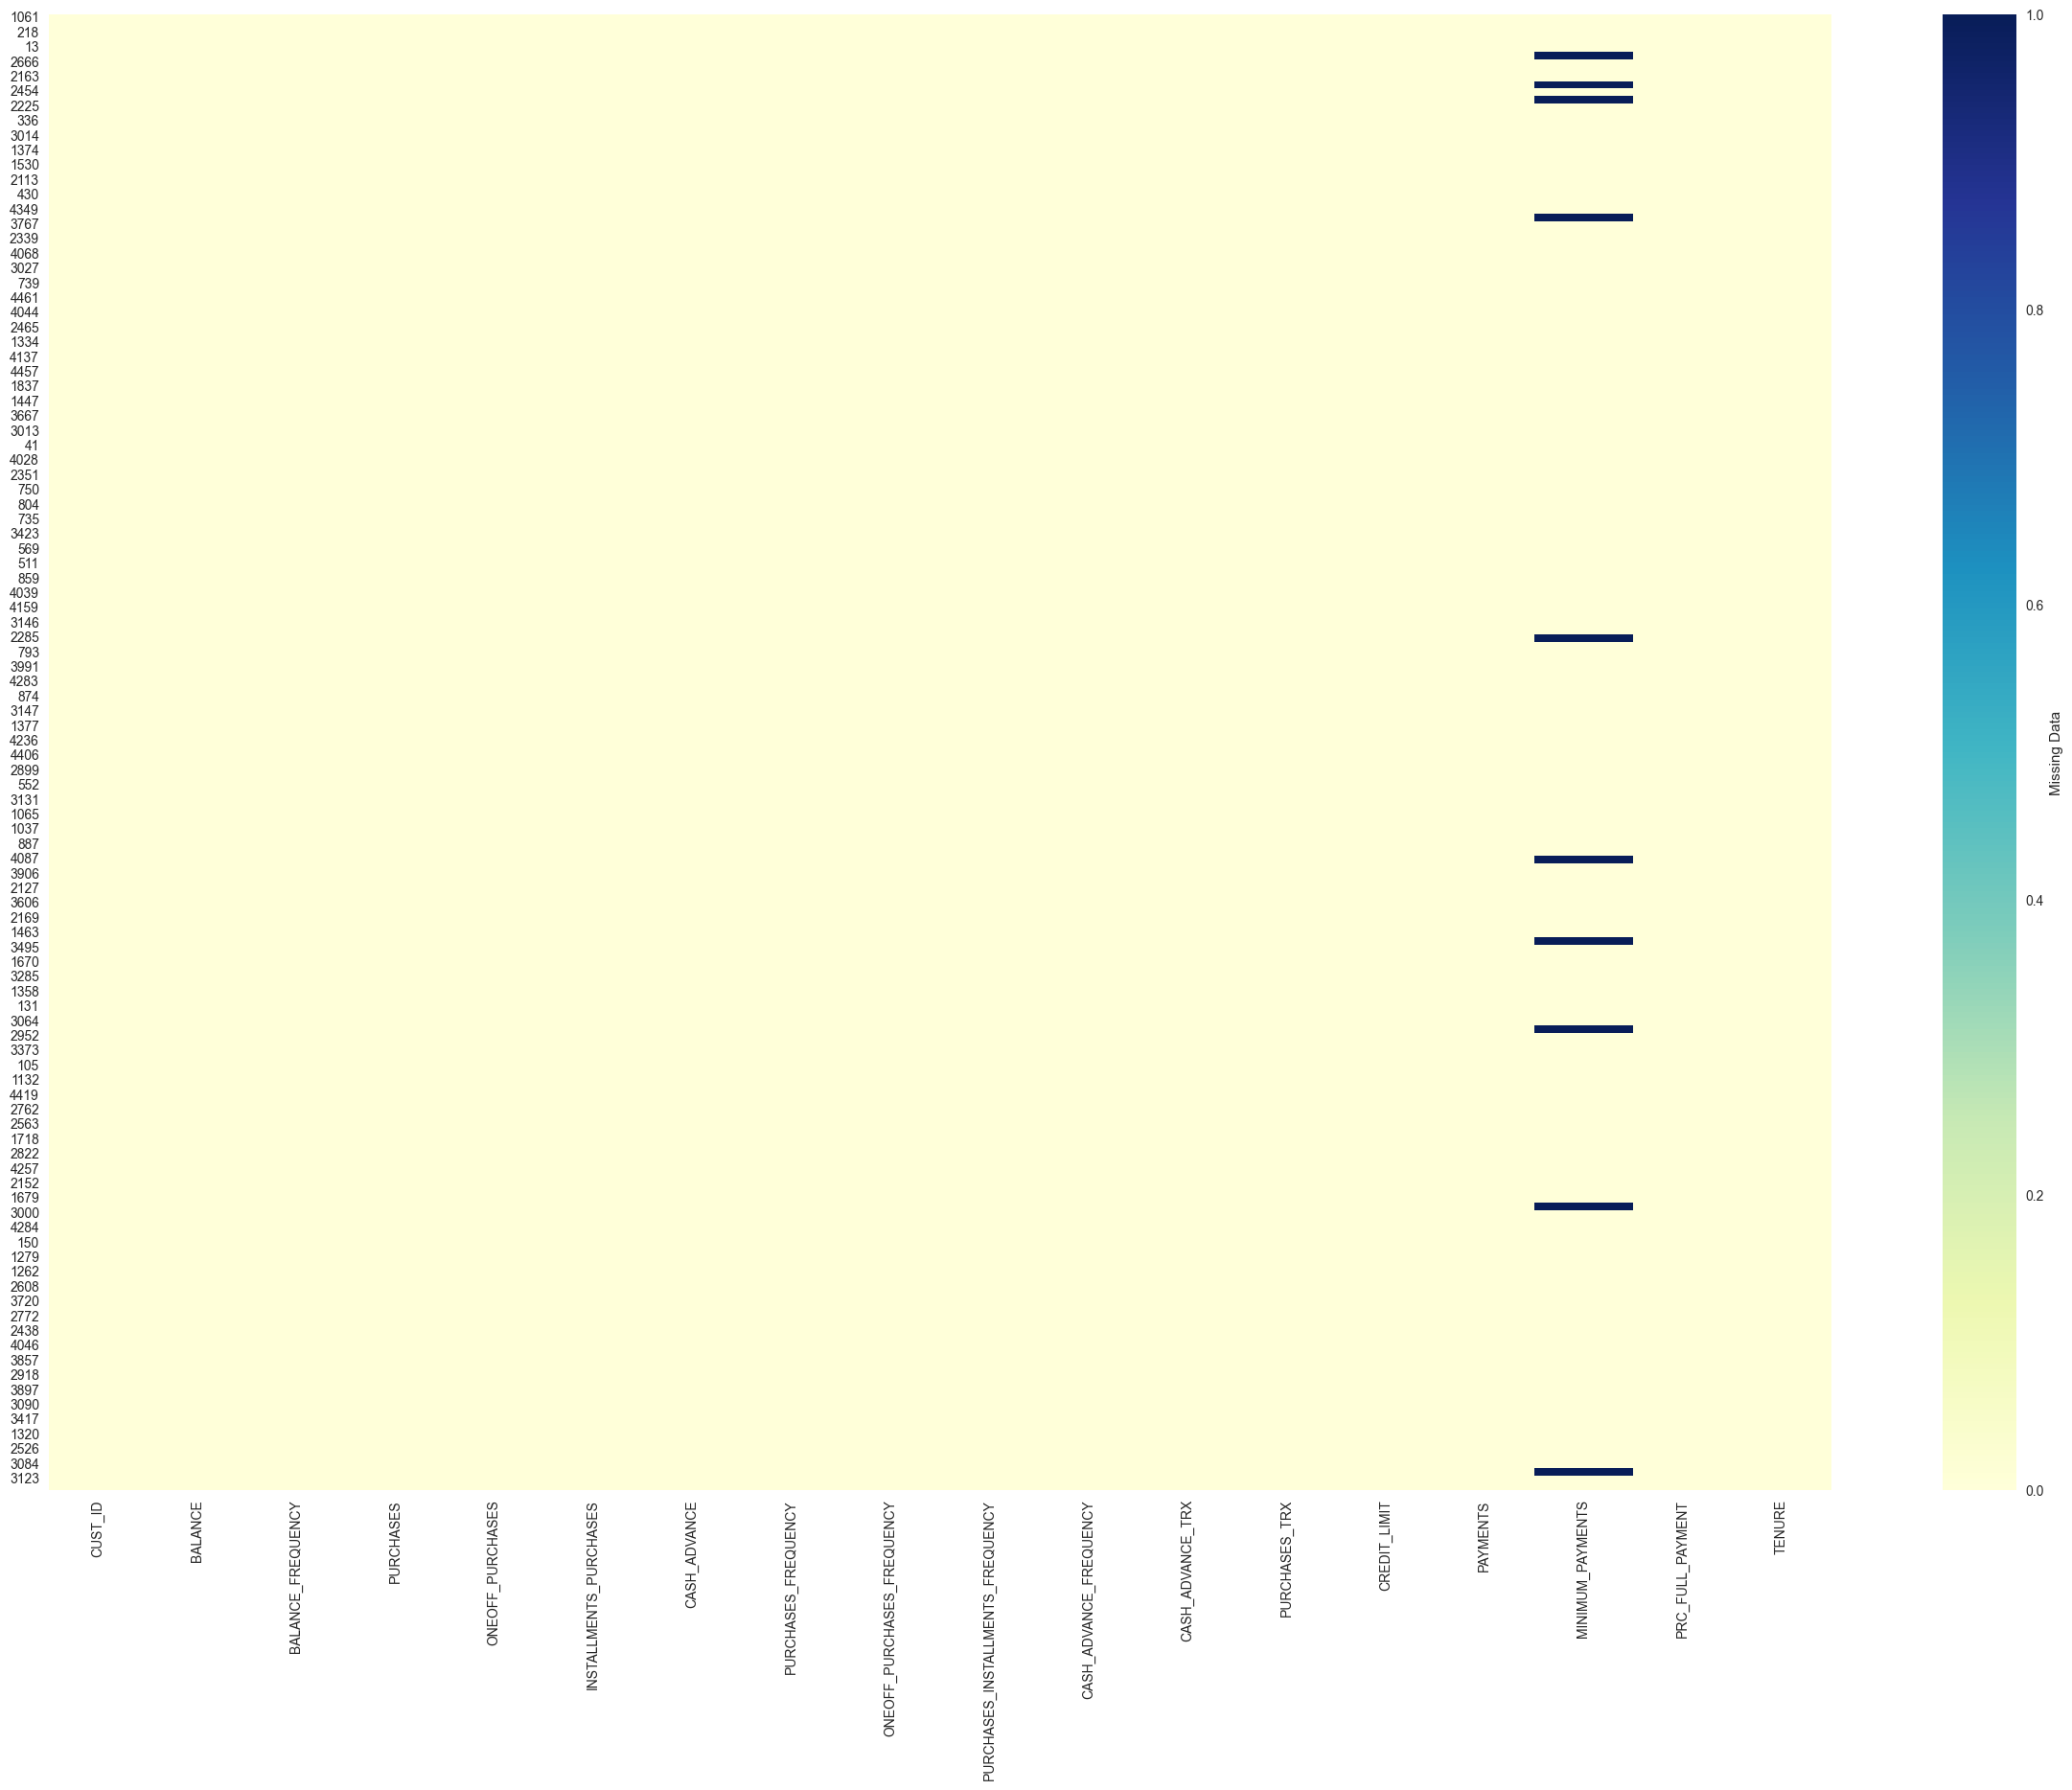

In [13]:
# Missing value heatmap analysis
plt.figure(figsize=(30,20))

# Visualize the missing value using heatmap
sns.heatmap(df_eda.sample(200).isna(), cmap="YlGnBu",
            cbar_kws={'label': 'Missing Data'})

# show the plot
plt.show()

**Penjelasan**  
Visualisasi dari missing values dimana hanya terlihat pada `Minimum_Payments`.

## Bagaimana distribusi dari `Balance`, `Purchase`, `Credit_Limit`, `Payments`?

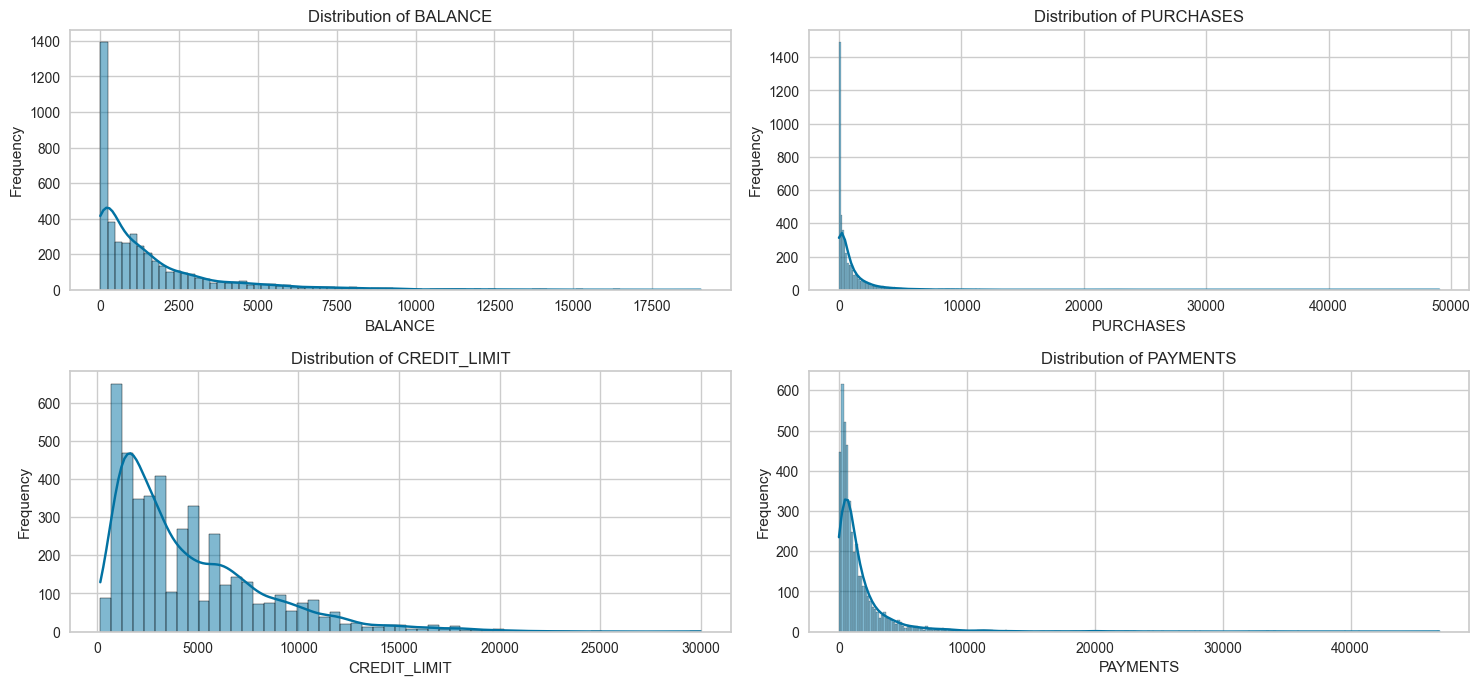

In [14]:
# Select column
columns_to_plot = ['BALANCE', 'PURCHASES', 'CREDIT_LIMIT', 'PAYMENTS']

# Setting figure size
plt.figure(figsize=(15, 10))

# Loop for histogram each column
for i, column in enumerate(columns_to_plot, 1):
    plt.subplot(3, 2, i)
    sns.histplot(data[column], kde=True)
    plt.title(f'Distribution of {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')

# Show figure
plt.tight_layout()
plt.show()

**Penjelasan**  
Dari analisa di atas, didapatkan beberapa informasi sebagai berikut:
- `Balance ` tampak memiliki distribusi miring ke kanan dengan sebagian data berkumpul di sebelah kiri, artinya ini menunjukan bahwa sejumlah besar customer memiliki saldo yang relatif rendah.
- `Purchases` tampak memiliki distribusi miring ke kanan juga, artinya distribusi pembelian oleh customer memiliki jumlah yang relatif kecil.
- `Credit_Limit` juga tampak memiliki distribusi miring ke kanan namun tidak seintens distribusi sebelumnya dan terlihat juga pada distribusi ini memiliki beberapa puncak yang artinya terdapat kelompok limit kredit tertentu yang umum (misal terdapat kelompok limit kredit rendah, sedang, dan tinggi).
- `Payments` juga serupa memiliki distribusi miring ke kanan ini menunjukan bahwa sebagian besar customer melakukan pembayaran dalam jumlah kecil.

## Bagaimana distribusi dari `Customer Tenure`?

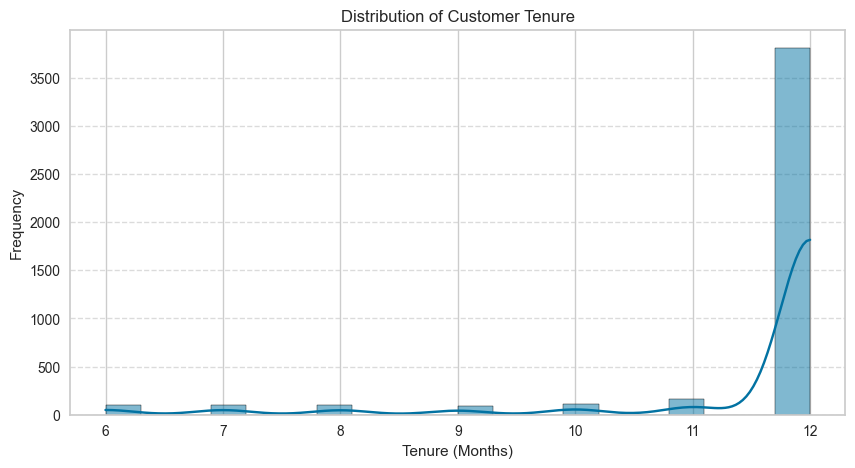

In [15]:
# Make Tenure Distribution Visualization
plt.figure(figsize=(10, 5))
sns.histplot(data=df_eda, x='TENURE', bins=20, kde=True)

# Setting up title and lable
plt.title('Distribution of Customer Tenure')
plt.xlabel('Tenure (Months)')
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Showing plot
plt.show()


**Penjelasan**  
Dari analisa di atas didapatkan informasi, bahwa sebagian besar customer memiliki tenure selama 12 bulan.

## Bagimana karakteristik pelanggan yang memiliki `Balance` yang tinggi atau rendah?

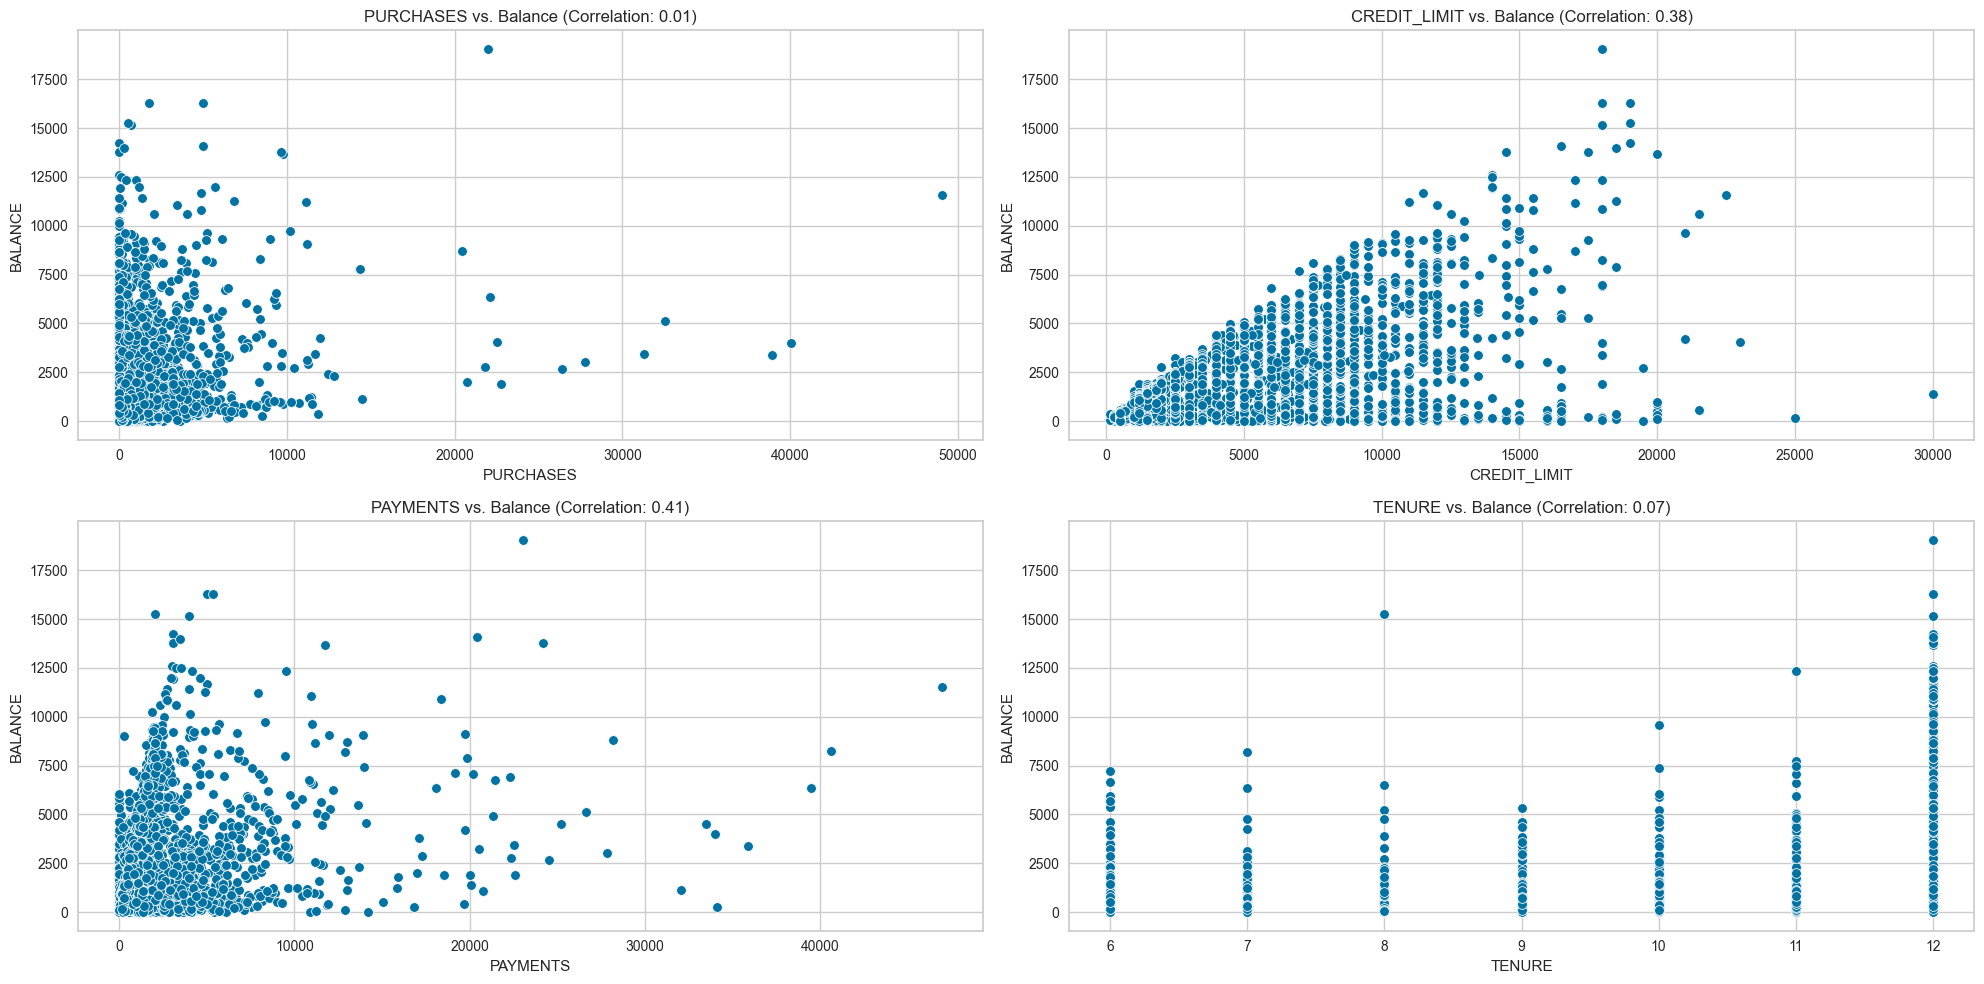

In [16]:
# List of features you're interested in
features = ['PURCHASES', 'CREDIT_LIMIT', 'PAYMENTS', 'TENURE']

# Create a subplot for each feature
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(20, 10))

for i, feature in enumerate(features):
    # Calculate the correlation between the feature and Balance
    correlation = df_eda[feature].corr(df_eda['BALANCE'], method='spearman')
    
    # Create a scatter plot of the feature vs. Balance
    sns.scatterplot(data=df_eda, x=feature, y='BALANCE', ax=axs[i//2, i%2])
    
    # Set the title to include the correlation
    axs[i//2, i%2].set_title(f'{feature} vs. Balance (Correlation: {correlation:.2f})')

plt.tight_layout()
plt.show()

**Penjelasan** 
- `Purchases` grafik scatter plot menunjukan adanya korelasi yang sangat lemah (0.01). Ada sedikit peningkatan, namun tidak signifiikan. Ini menunjukan bahwa customer yang membeli lebih banyak memiliki saldo yang sedikit lebih tinggi, namun memiliki beberapa faktor lain yang lebih mempengaruhi saldo daripada pembelian.
- `Credit_Limit` grafik scatter plot menunjukan korelasi positif yang lemah (0.38). Terdapat tren kenaikan yang lebih jelas terlihat dibandingkan dengan pembelian, namun datanya masih banyak yang tersebar. Artinya customer dengan limit credit yang lebih tinggi cenderung memiliki saldo yang lebih tinggi, namun ada juga customer dengan limit credit tinggi dan saldo rendah.
- `Payments` grafik scatter plot menunjukan adanya korelasi positif yang lemah (0.41). Ada tren naik, namun datanya tersebar. Ini menunjukkan bahwa orang yang melakukan pembayaran lebih besar cenderung memliki saldo yang lebih tinggi
- `Tenure` grafik scatter plot menunjjukan korelasi yang sangat lemah (0.07). Data nya tersebar secara acak, dan hampir tidak ada korelasi antara tenure dengan saldo customer.

# **6. *Feature Engineering***

## Buat salinan data

In [17]:
# Create Copy Data for Feature Engineering
df = data.copy()

## Menangani data yang hilang

In [18]:
# Check Missing Values
df.isna().sum()

CUST_ID                               0
BALANCE                               0
BALANCE_FREQUENCY                     0
PURCHASES                             0
ONEOFF_PURCHASES                      0
INSTALLMENTS_PURCHASES                0
CASH_ADVANCE                          0
PURCHASES_FREQUENCY                   0
ONEOFF_PURCHASES_FREQUENCY            0
PURCHASES_INSTALLMENTS_FREQUENCY      0
CASH_ADVANCE_FREQUENCY                0
CASH_ADVANCE_TRX                      0
PURCHASES_TRX                         0
CREDIT_LIMIT                          1
PAYMENTS                              0
MINIMUM_PAYMENTS                    158
PRC_FULL_PAYMENT                      0
TENURE                                0
dtype: int64

**Penjelasan**  
Seperti yang sudah diketahui sebelumnya pada saat melakukan EDA bahwa terdapat missing values pada `Minimum_Payments` dan `Credit_Limit`. Jenis missing values terlihat seperti MCAR, karena terjadi secara acak dan tidak terkait dengan kolom lain. Namun bagaimanapun tetap diperlukan analisa lebih lanjut. Kemudian, karena jumlah missing values tidak sampai 5% maka saya akan melakukan drop data missing values tersebut. Alasannya karena tidak begitu mempengaruhi hasil akhir analisa nanti.

In [19]:
# Drop Missing Values
df.dropna(inplace=True)

In [20]:
# Re-Check Missing Values
df.isna().sum()

CUST_ID                             0
BALANCE                             0
BALANCE_FREQUENCY                   0
PURCHASES                           0
ONEOFF_PURCHASES                    0
INSTALLMENTS_PURCHASES              0
CASH_ADVANCE                        0
PURCHASES_FREQUENCY                 0
ONEOFF_PURCHASES_FREQUENCY          0
PURCHASES_INSTALLMENTS_FREQUENCY    0
CASH_ADVANCE_FREQUENCY              0
CASH_ADVANCE_TRX                    0
PURCHASES_TRX                       0
CREDIT_LIMIT                        0
PAYMENTS                            0
MINIMUM_PAYMENTS                    0
PRC_FULL_PAYMENT                    0
TENURE                              0
dtype: int64

**Penjelasan**  
Data missing values berhasil di drop.

## Menangani data *Outlier*

In [21]:
# Filter Numerical Columns in X df
numeric_columns = df.select_dtypes(include=np.number).columns.to_list()

# Skewed columns container
skewed_numeric_data = []
skewed_numeric_columns = []

# Normal distribution columns container
normal_numeric_data = []
normal_numeric_columns = []

# For loop in every numerical column to filer the data distribution into either normal distributed or skewed columns
for column in numeric_columns:
    skewness = df[column].skew()
    # If Normal distribution
    if skewness <= 0.5 and skewness >= -0.5:
        normal_numeric_columns.append(column)
        normal_numeric_data.append([column, skewness])
    # If Skewed distribution
    elif skewness < -0.5 or skewness > 0.5:
        skewed_numeric_columns.append(column)
        skewed_numeric_data.append([column, skewness])

**Penjelasan**  
Sebelum melakukan handle outlier, kita perlu mengidentifikasikan skewness pada tiap kolom numerical di dataset untuk bisa mengelompokan kolom mana yang memiliki skewness dan kolom mana yang memiliki distribusi normal. Dengan syarat seperti di bawah ini: 
- Jika data pada kolom memiliki skewness lebih besar dari -0.5 dan lebih kurang dari 0.5, maka kolom tersebut masuk ke dalam distribusi normal.
- Jika data pada kolom memiliki skewness lebih besar dari 0.5 dan lebih kurang dari -0.5, maka kolom tersebut 

In [22]:
# Showing all columns with normal distribution and each skewness
print('Columns with Normal Distribution')
pd.DataFrame(data=normal_numeric_data, columns=['normal_distributed_columns', 'skewness'])

Columns with Normal Distribution


normal_distributed_columns  skewness
0                           CUST_ID -0.000256
1               PURCHASES_FREQUENCY  0.035642
2  PURCHASES_INSTALLMENTS_FREQUENCY  0.486577

**Penjelesan**  
Terdapat 3 kolom yang memiliki hasil distribusi normal. Dimana proses berikutnya ketika proses censoring/capping menggunakan winsorizer gaussian. Winsorizer gaussian cocok digunakan untuk data yang terdistribusi normal. 

In [23]:
# Showing all columns with skewed distribution and each skewness
print('Columns with Skewed Distribution')
pd.DataFrame(data=skewed_numeric_data, columns=['skewed_columns', 'skewness'])

Columns with Skewed Distribution


skewed_columns   skewness
0                      BALANCE   2.440901
1            BALANCE_FREQUENCY  -2.083168
2                    PURCHASES   8.902272
3             ONEOFF_PURCHASES  10.045515
4       INSTALLMENTS_PURCHASES   8.030305
5                 CASH_ADVANCE   4.713175
6   ONEOFF_PURCHASES_FREQUENCY   1.494505
7       CASH_ADVANCE_FREQUENCY   1.788835
8             CASH_ADVANCE_TRX   4.722877
9                PURCHASES_TRX   4.429897
10                CREDIT_LIMIT   1.525379
11                    PAYMENTS   5.987445
12            MINIMUM_PAYMENTS  12.356758
13            PRC_FULL_PAYMENT   1.854400
14                      TENURE  -2.996978

**Penjelasan**  
Terdapat 15 kolom yang memiliki hasil distribusi skewed. Dimana proses berikutnya ketika proses censoring/capping menggunakan winsorizer iqr. Winsorizer gaussian iqr cocok digunakan untuk data yang memiliki outlier.

### *Capping* atau *Censoring*

Saat melakukan running capping metode iqr terdapat error di bawah ini.  
*Input columns ['TENURE'] have low variation for method 'iqr'. Try other capping methods or drop these columns.*  
Penanganan yang dilakukan yaitu dengan memindahkan kolom ['TENURE'] dari skewed_column ke normal_columns.

In [24]:
# define low variation columns
low_var_cols_skewed = ['TENURE']

# Drop the low variation columns in skewed columns
for column in low_var_cols_skewed:
    skewed_numeric_columns.remove(column)

In [25]:
# Capping Method for Normal Distribution  
winsorizer_normal_distribution = Winsorizer(capping_method='gaussian',
                            tail='both',
                            fold=3,
                            variables=normal_numeric_columns,
                            missing_values='ignore')

# Fit & Transforming 
normal_distributed = winsorizer_normal_distribution.fit_transform(df)

**Penjelasan**  
Proses capping data yang terdistribusi normal dengan metode gaussian.

In [26]:
# Capping Method for Skewed Distribution  
winsorizer_skewed = Winsorizer(capping_method='iqr',
                            tail='both',
                            fold=3,
                            variables=skewed_numeric_columns,
                            missing_values='ignore')

# Fit & Transforming 
df_capped = winsorizer_skewed.fit_transform(normal_distributed)

**Penjelasan**  
Proses capping data yang terdistribusi normal dengan metode iqr.

In [27]:
# Appending back low variation columns in skewed columns
for column in low_var_cols_skewed:
    skewed_numeric_columns.append(column)

**Penjelasan**  
Mengembalikan kolom `TENURE` ke dalam list skewed_column.

In [28]:
# Plot Distribution Comparison
def outlier_handling_plot_comparison(df_before, df_after, variable):
    """
    This function is created to plot histograms and boxplots for a variable before and after outlier handling
    
    Parameters:
    - df_before (pandas.DataFrame): DataFrame before outlier handling
    - df_after (pandas.DataFrame): DataFrame after outlier handling
    - variable (str): The variable to plot
    
    Example: 
    num_cols = ['numeric_column']                                   <- Enter the numeric column
    for col in num_cols:                                            <- make a for loop in numeric column to access every columns
        plot_distribution_comparison(X_train, X_train_capped, col)  <- put X_train, X_train_capped, and columns in the variable

    """
    # Figure Size, and Super Title based on variable
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))                               
    fig.suptitle(f'{variable} - Distribution Before and After Outlier Handling')

    # Plot Histogram Before
    sns.histplot(df_before[variable], bins=30, ax=axes[0, 0], color='skyblue')
    axes[0, 0].set_title('Histogram Before')

    # Plot Boxplot Before
    sns.boxplot(y=df_before[variable], ax=axes[1, 0], color='lightgreen')
    axes[1, 0].set_title('Boxplot Before')

    # Plot Histogram After
    sns.histplot(df_after[variable], bins=30, ax=axes[0, 1], color='skyblue')
    axes[0, 1].set_title('Histogram After')

    # Plot Boxplot After
    sns.boxplot(y=df_after[variable], ax=axes[1, 1], color='lightgreen')
    axes[1, 1].set_title('Boxplot After')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

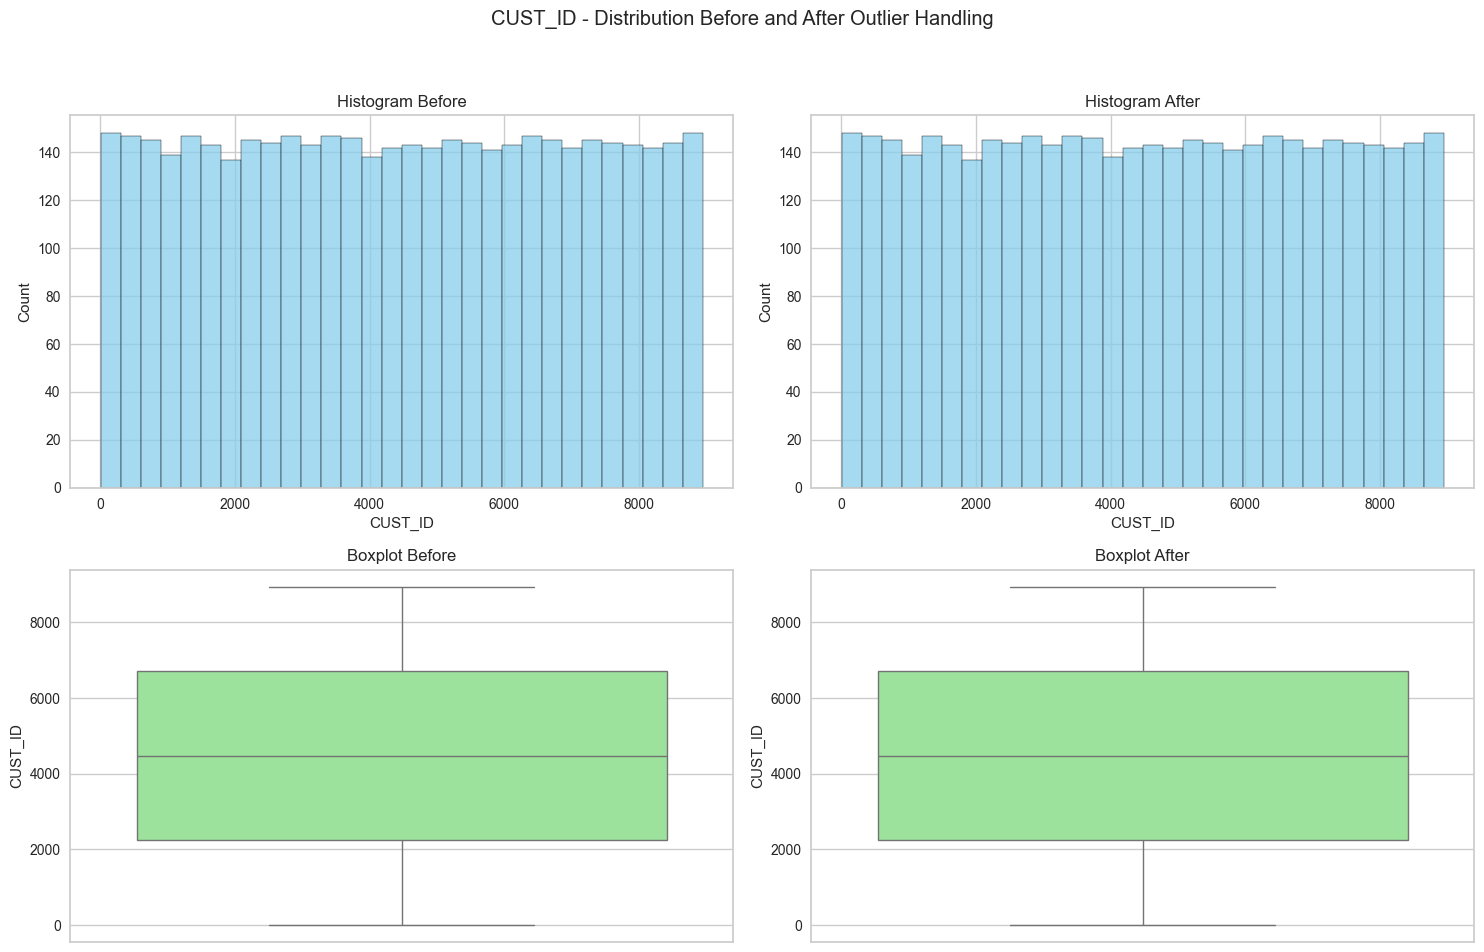

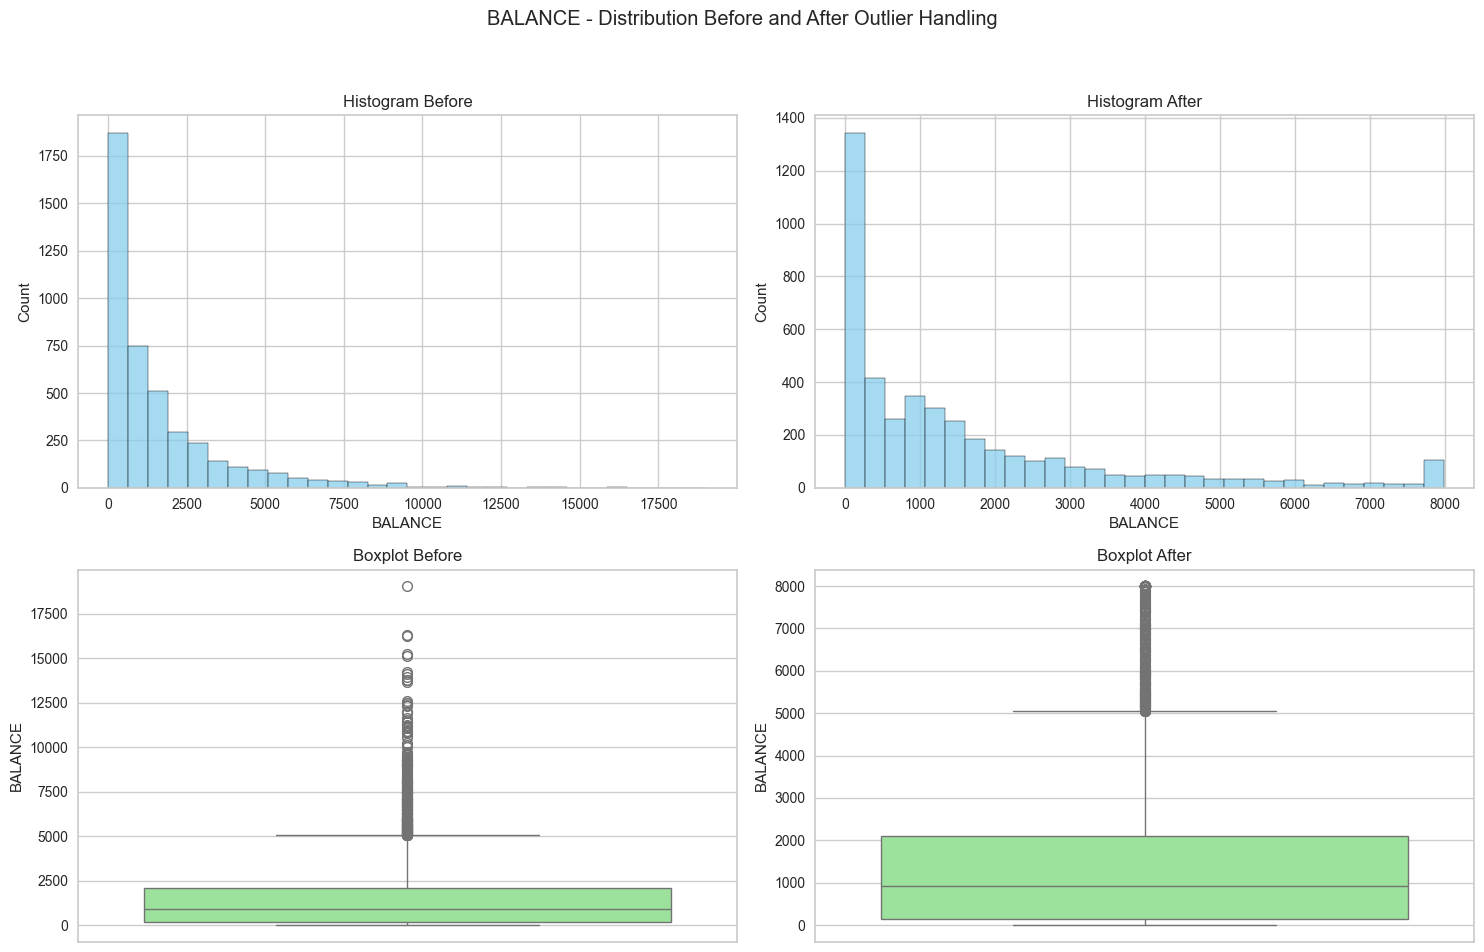

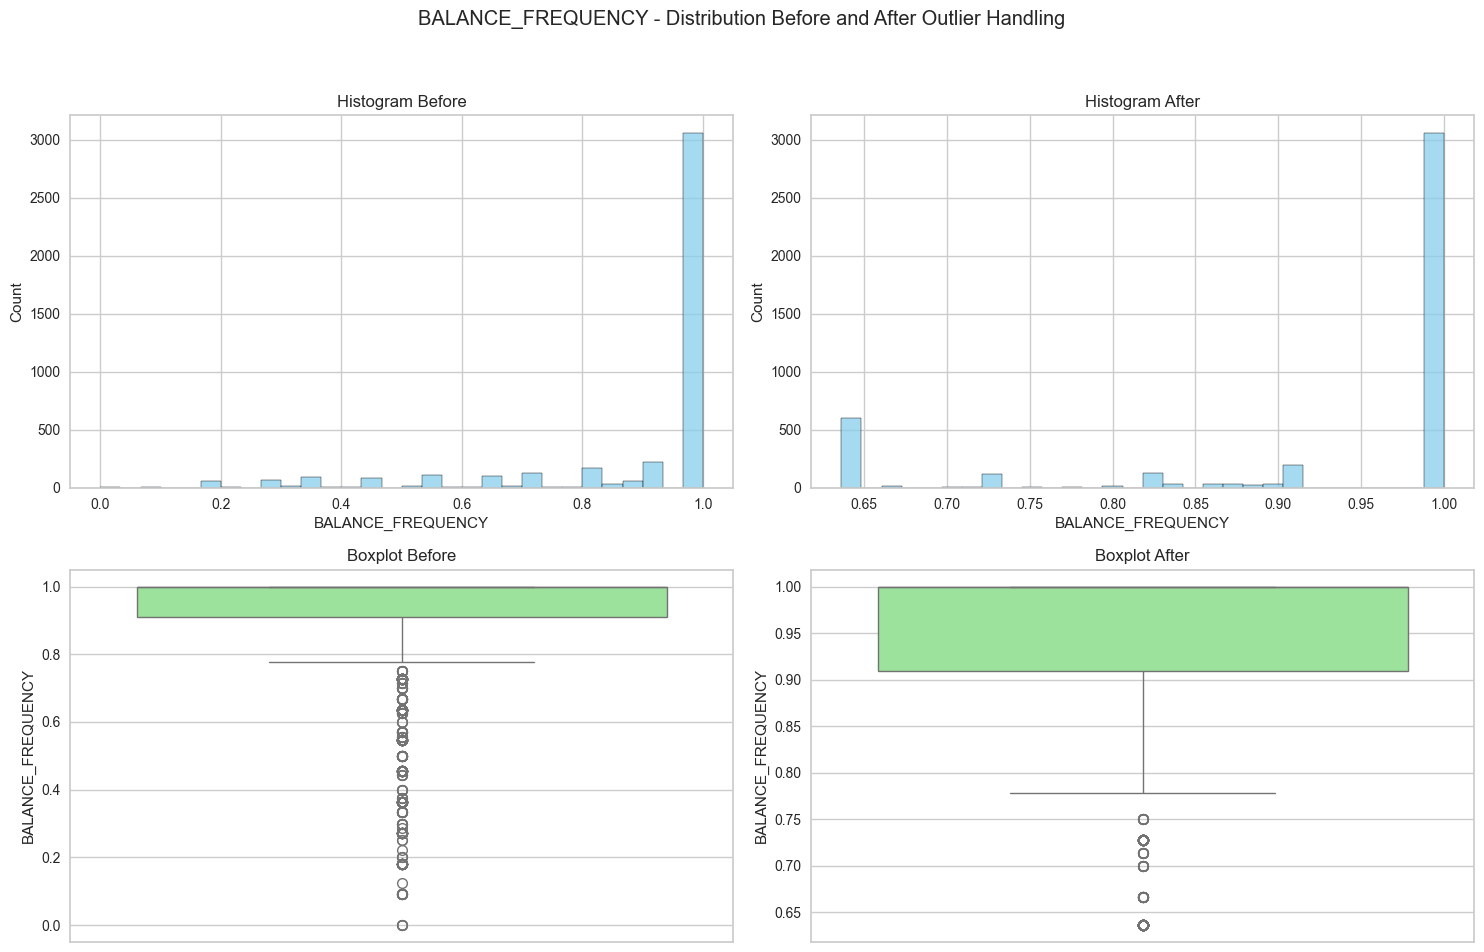

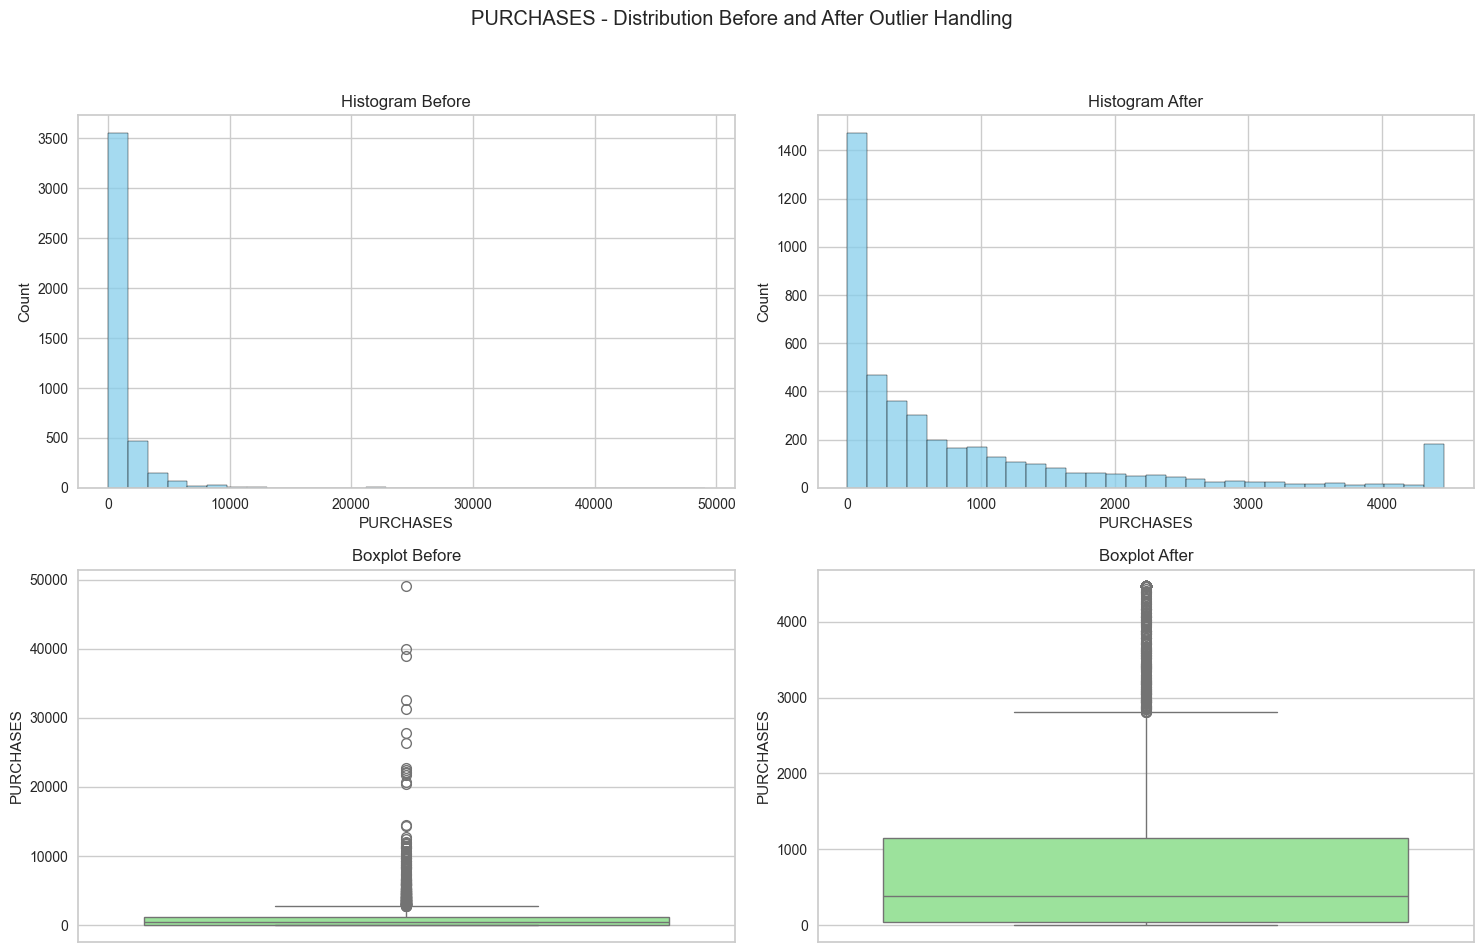

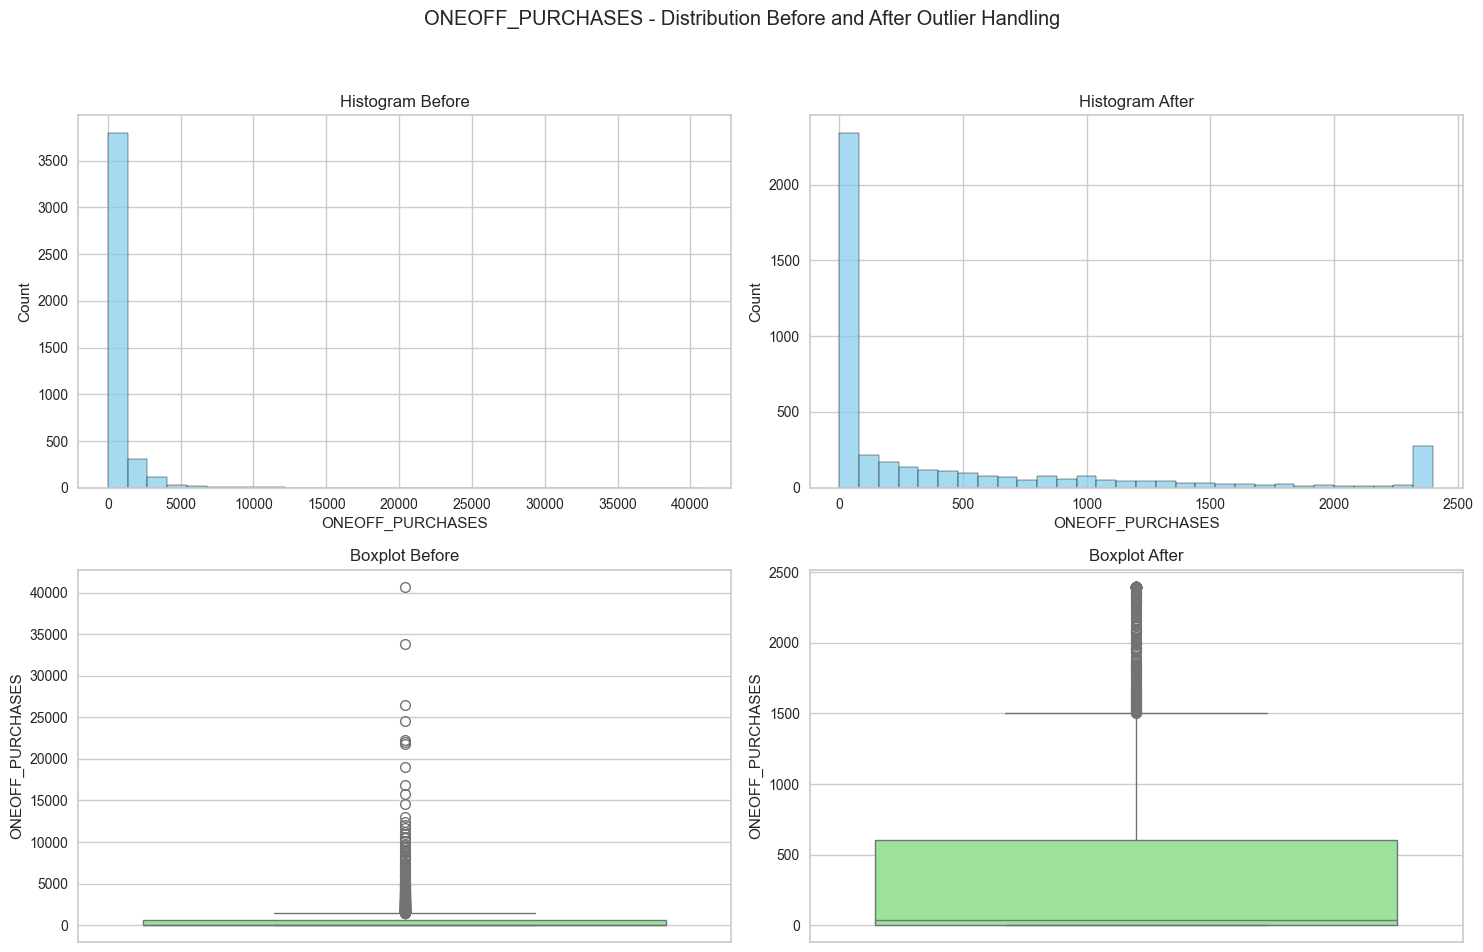

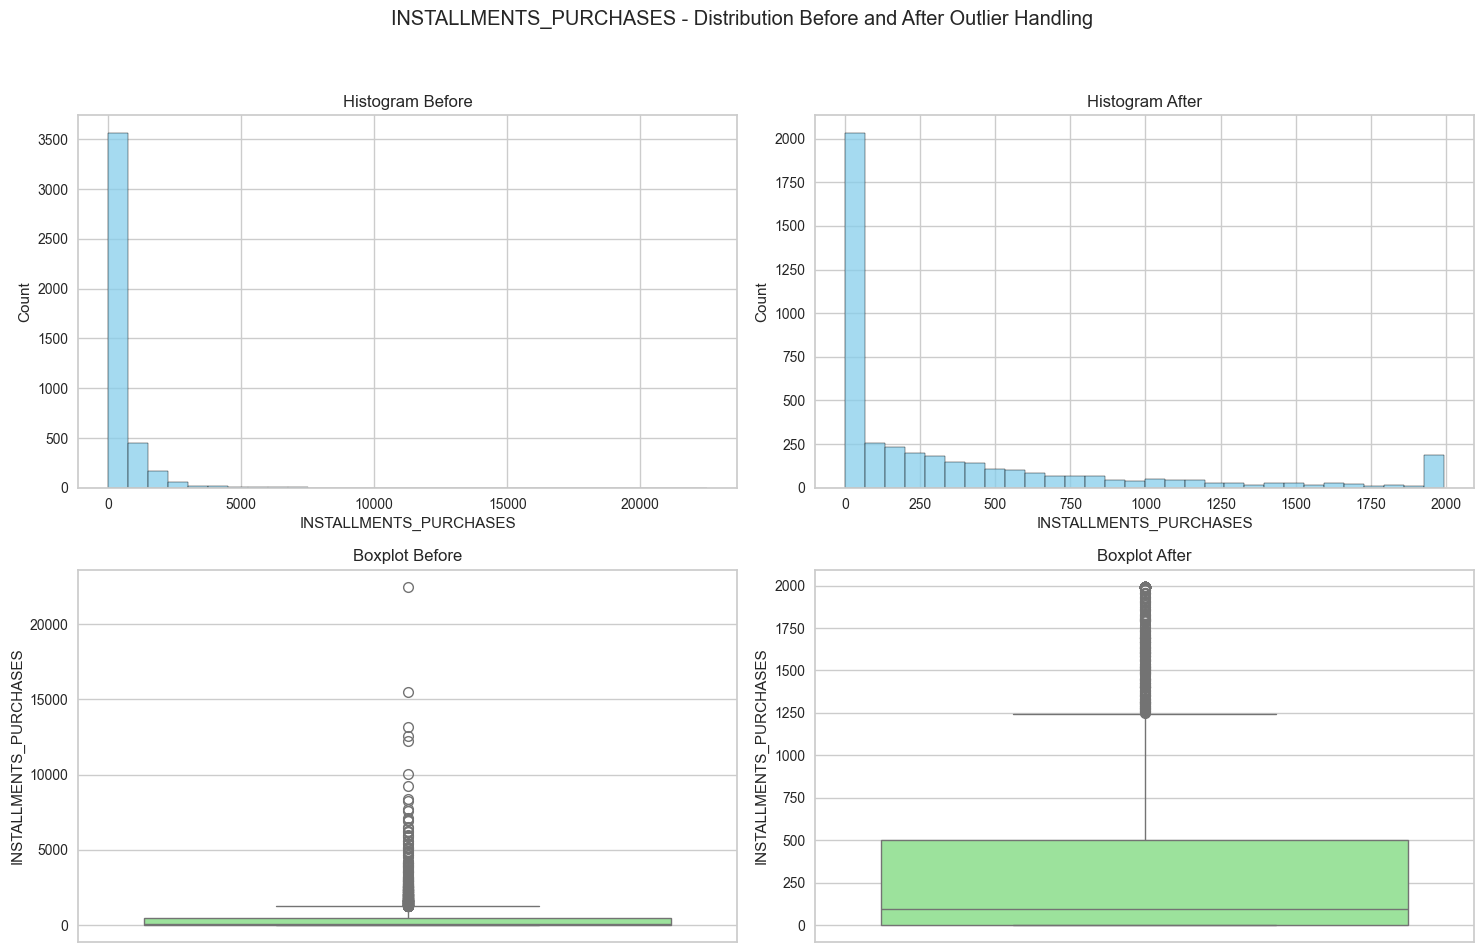

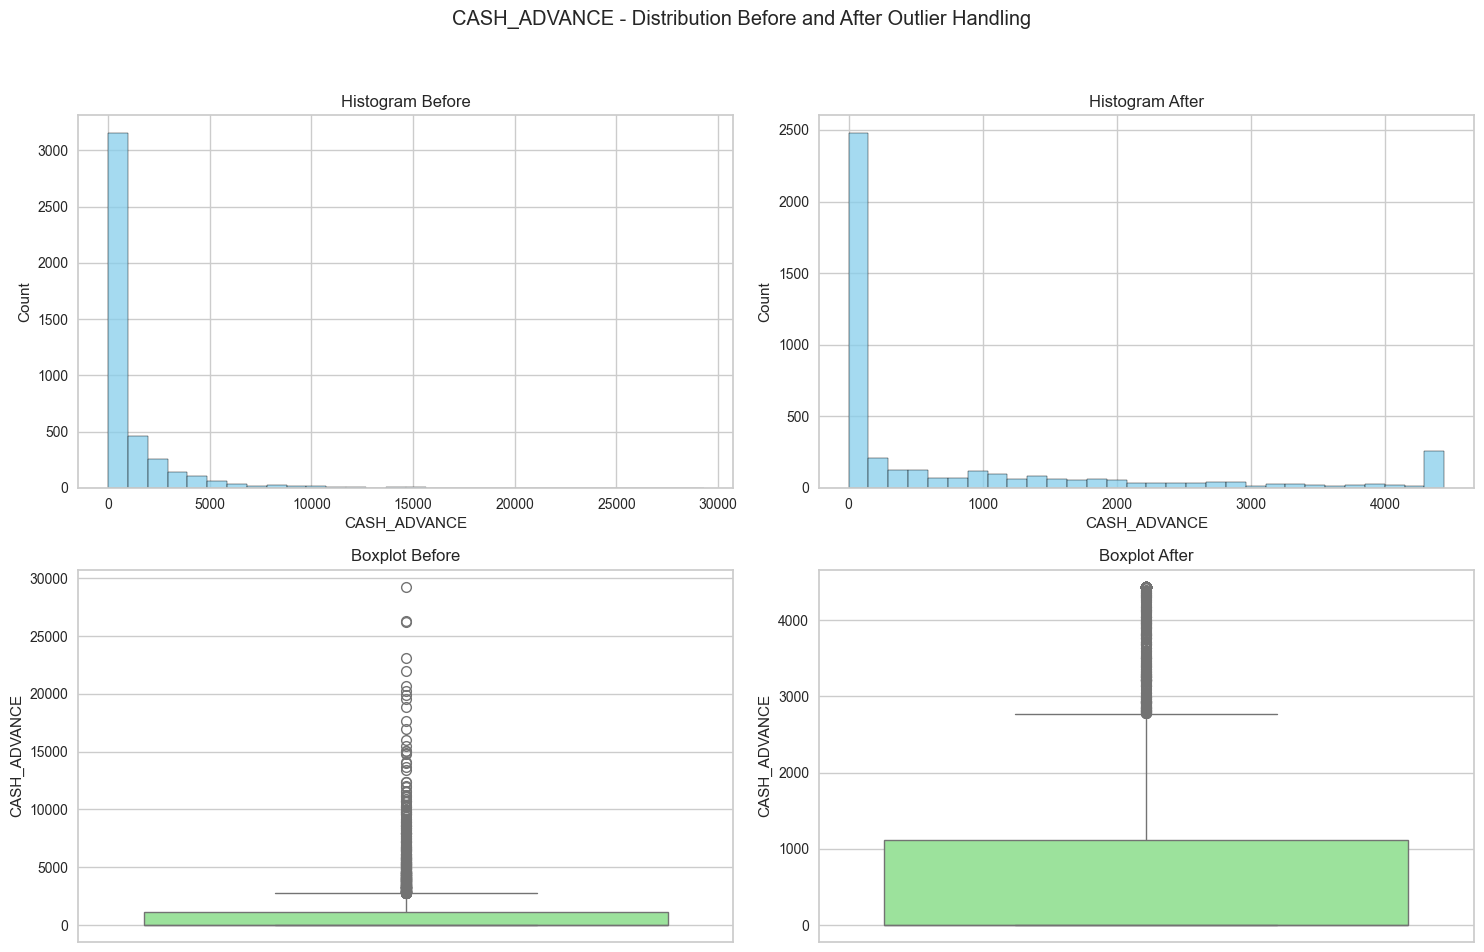

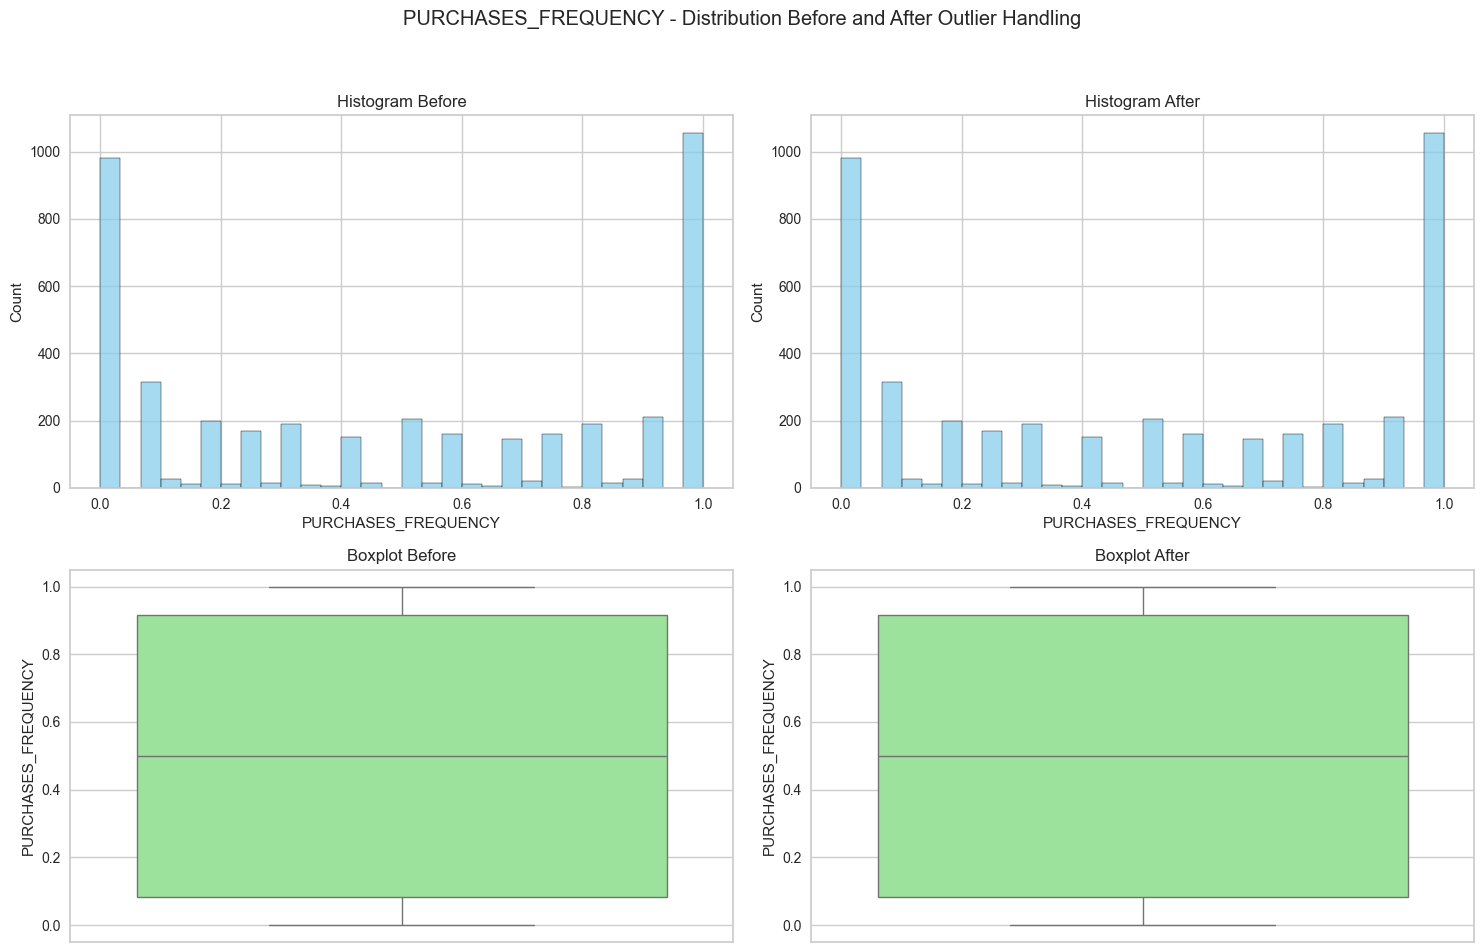

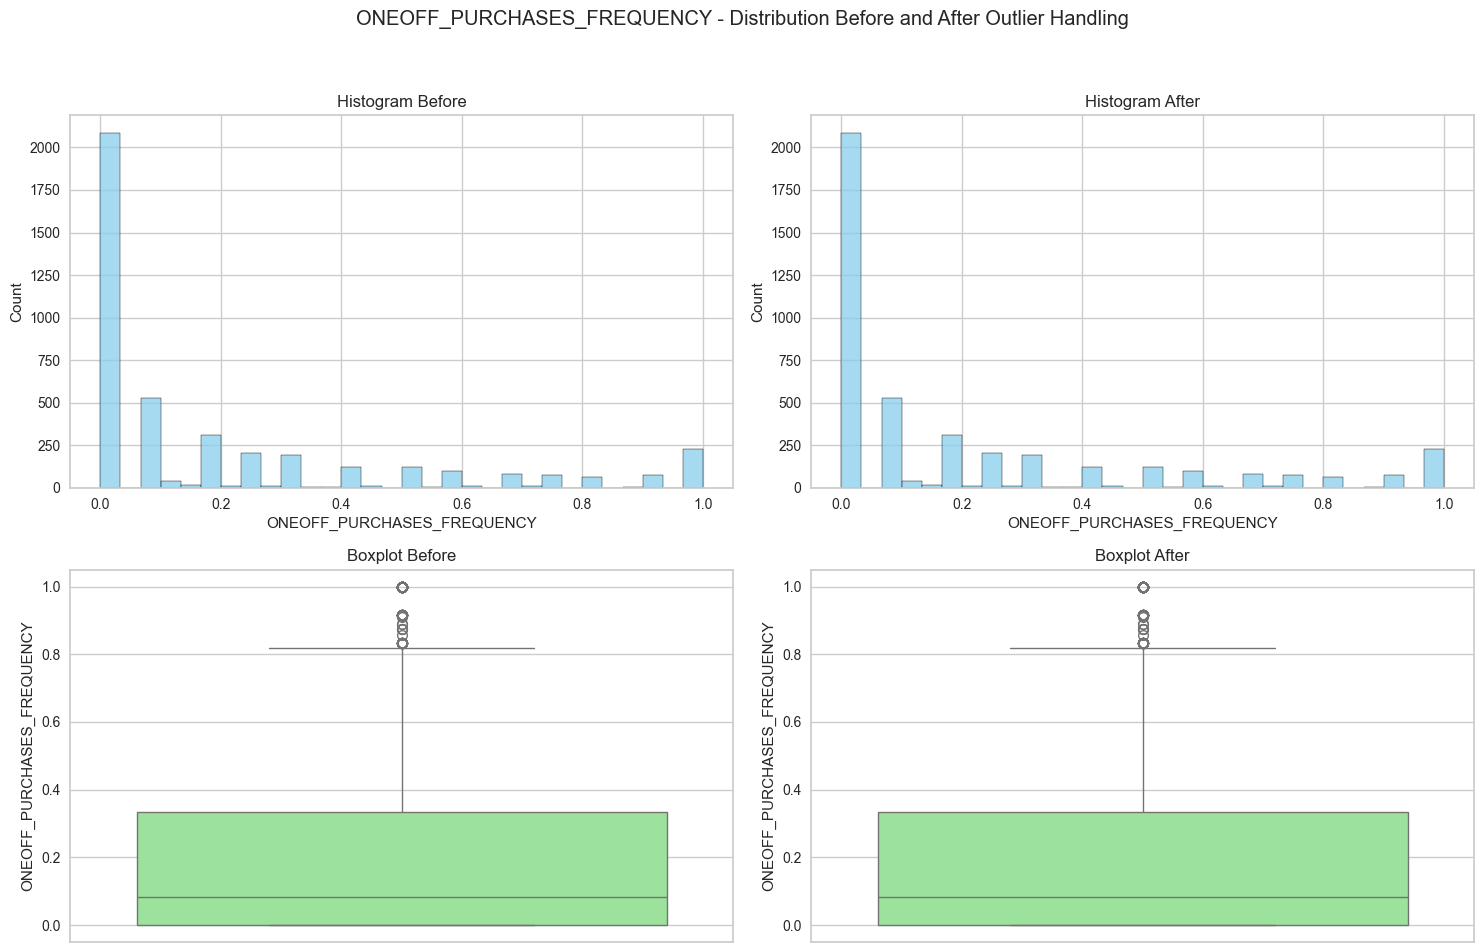

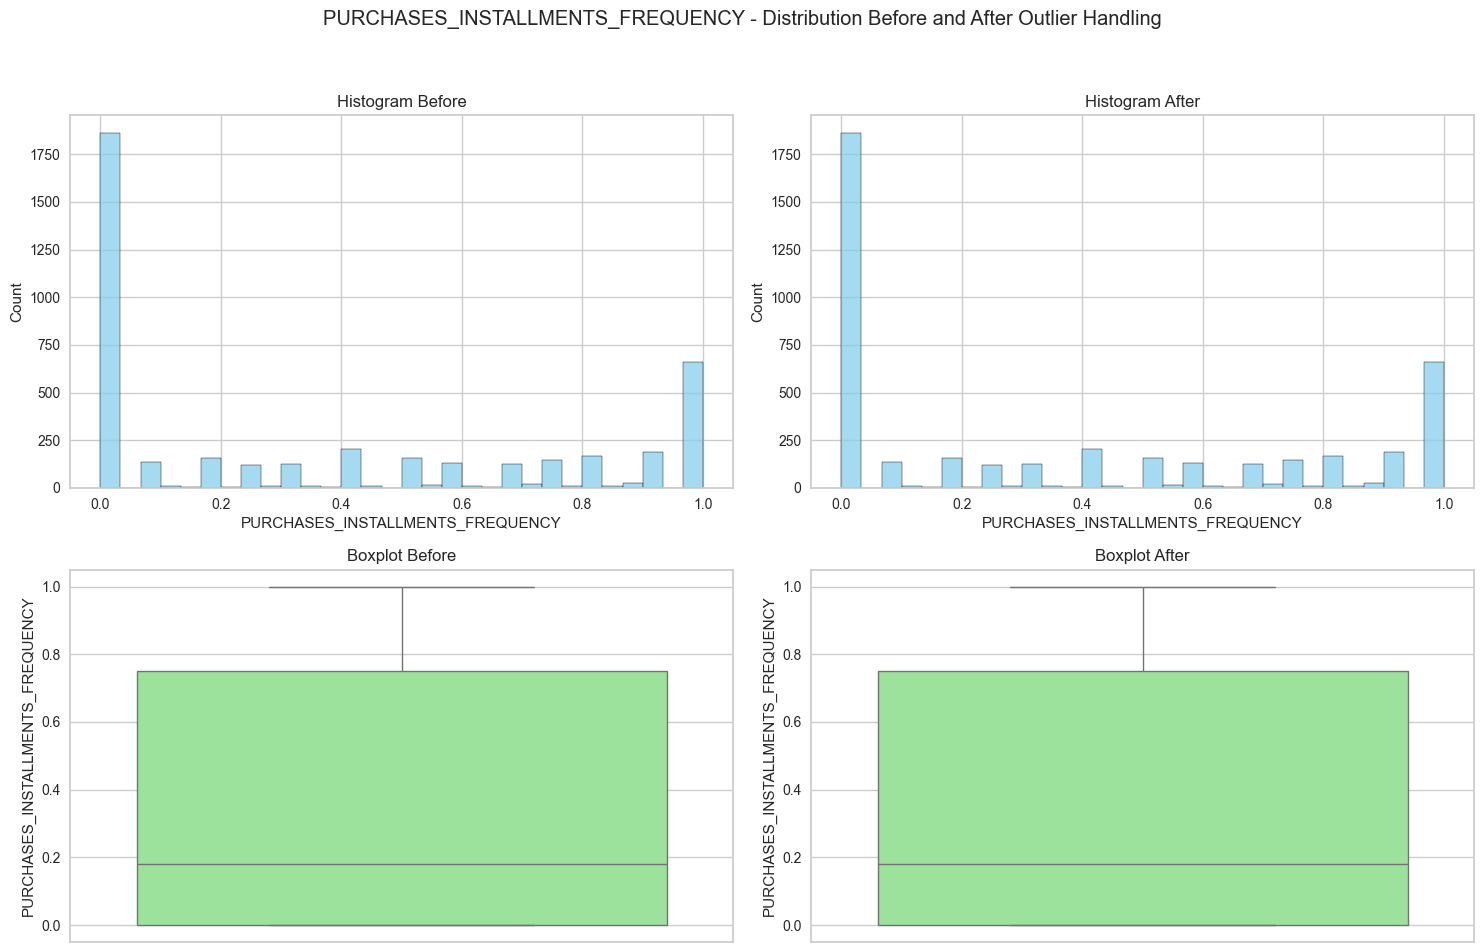

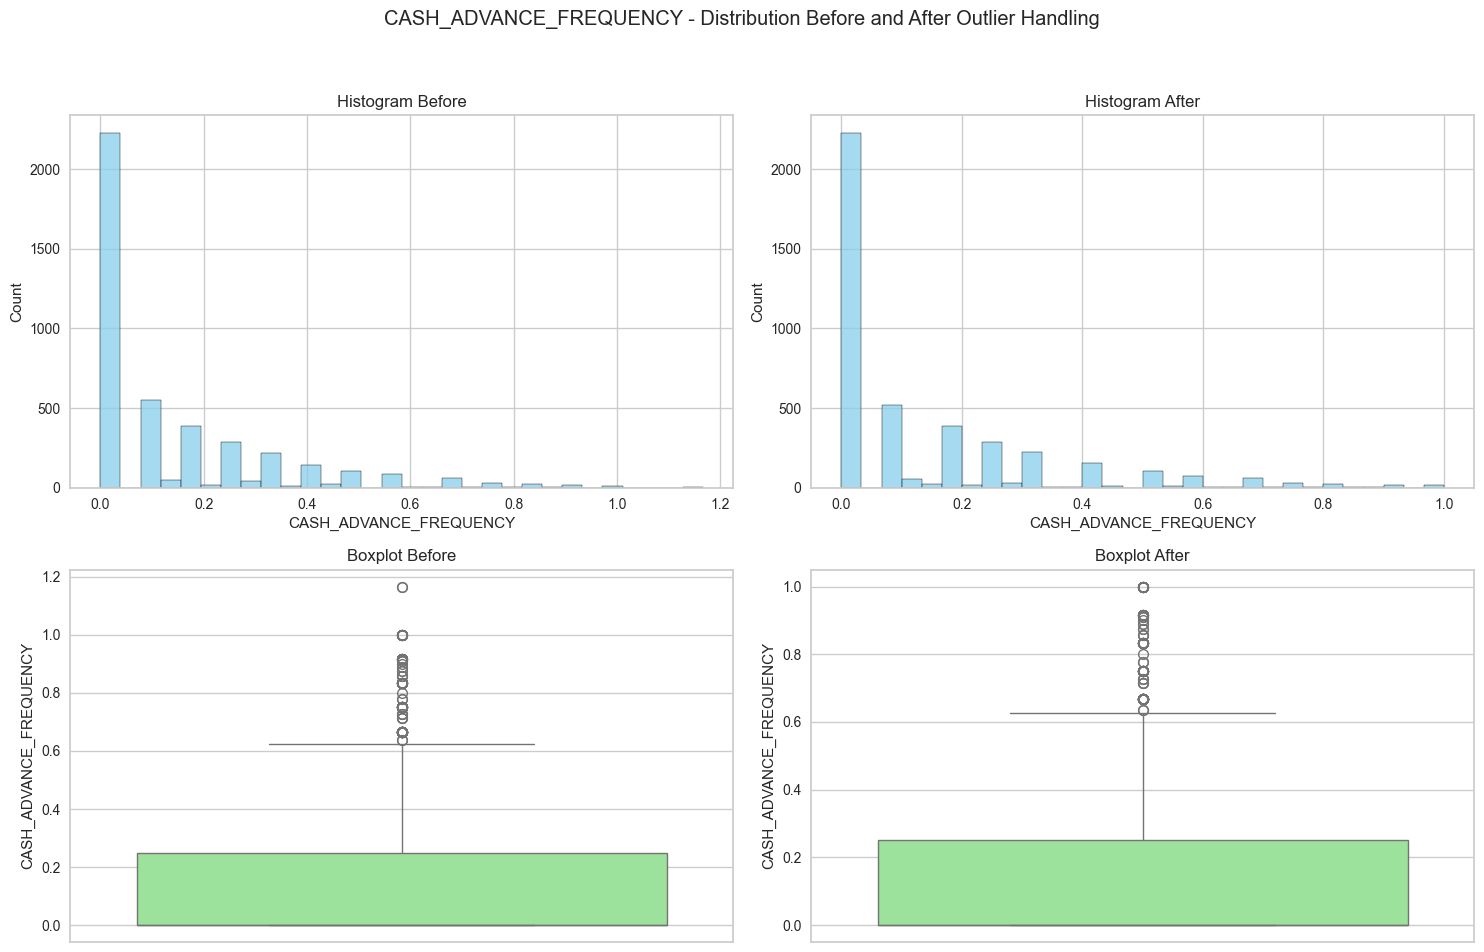

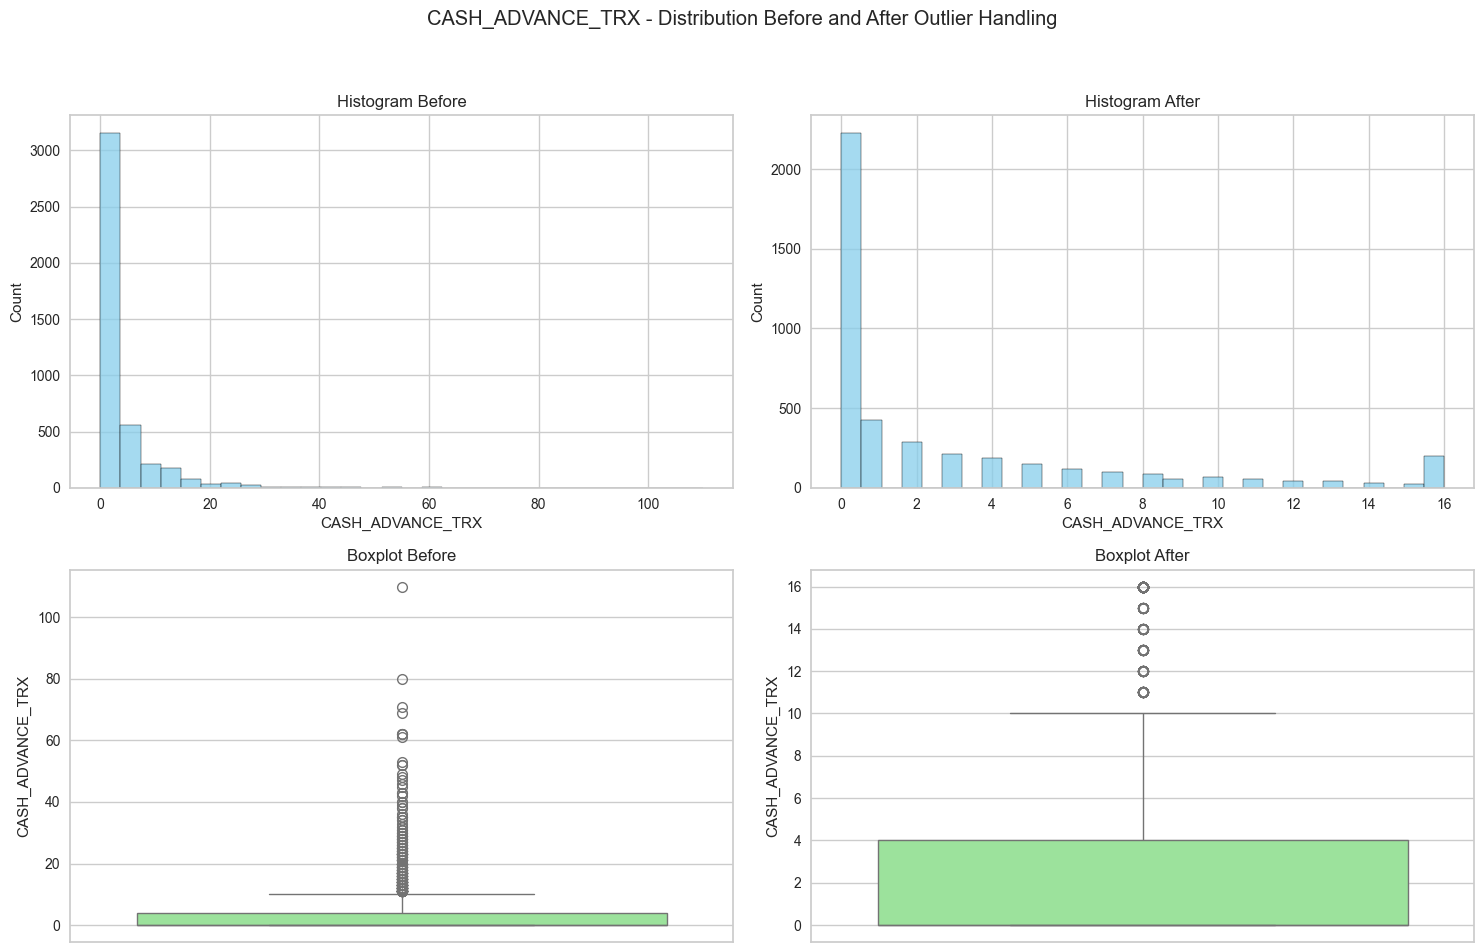

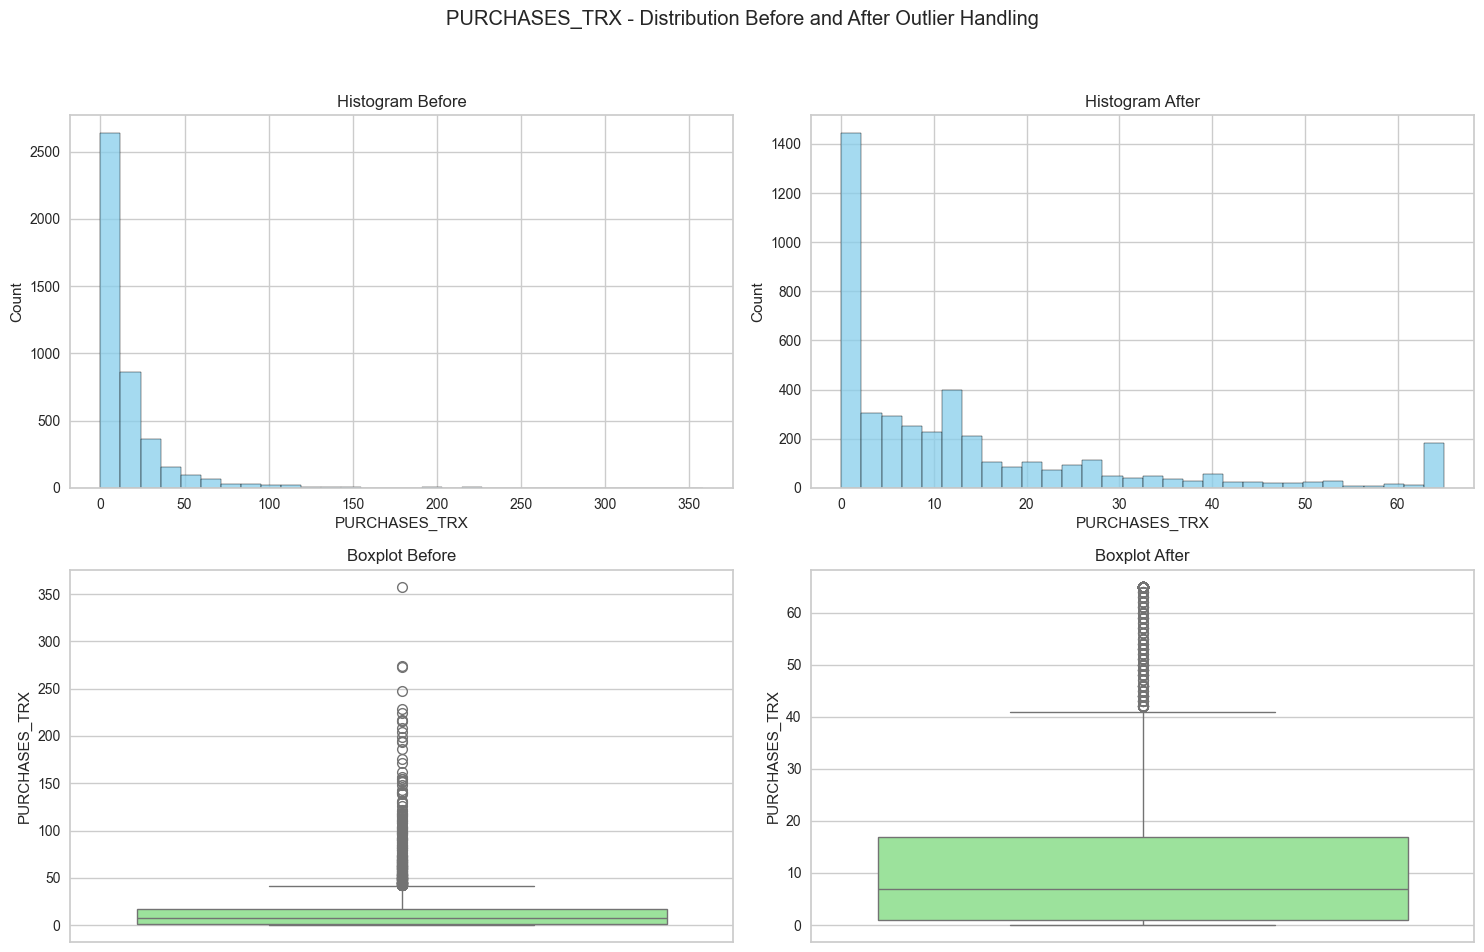

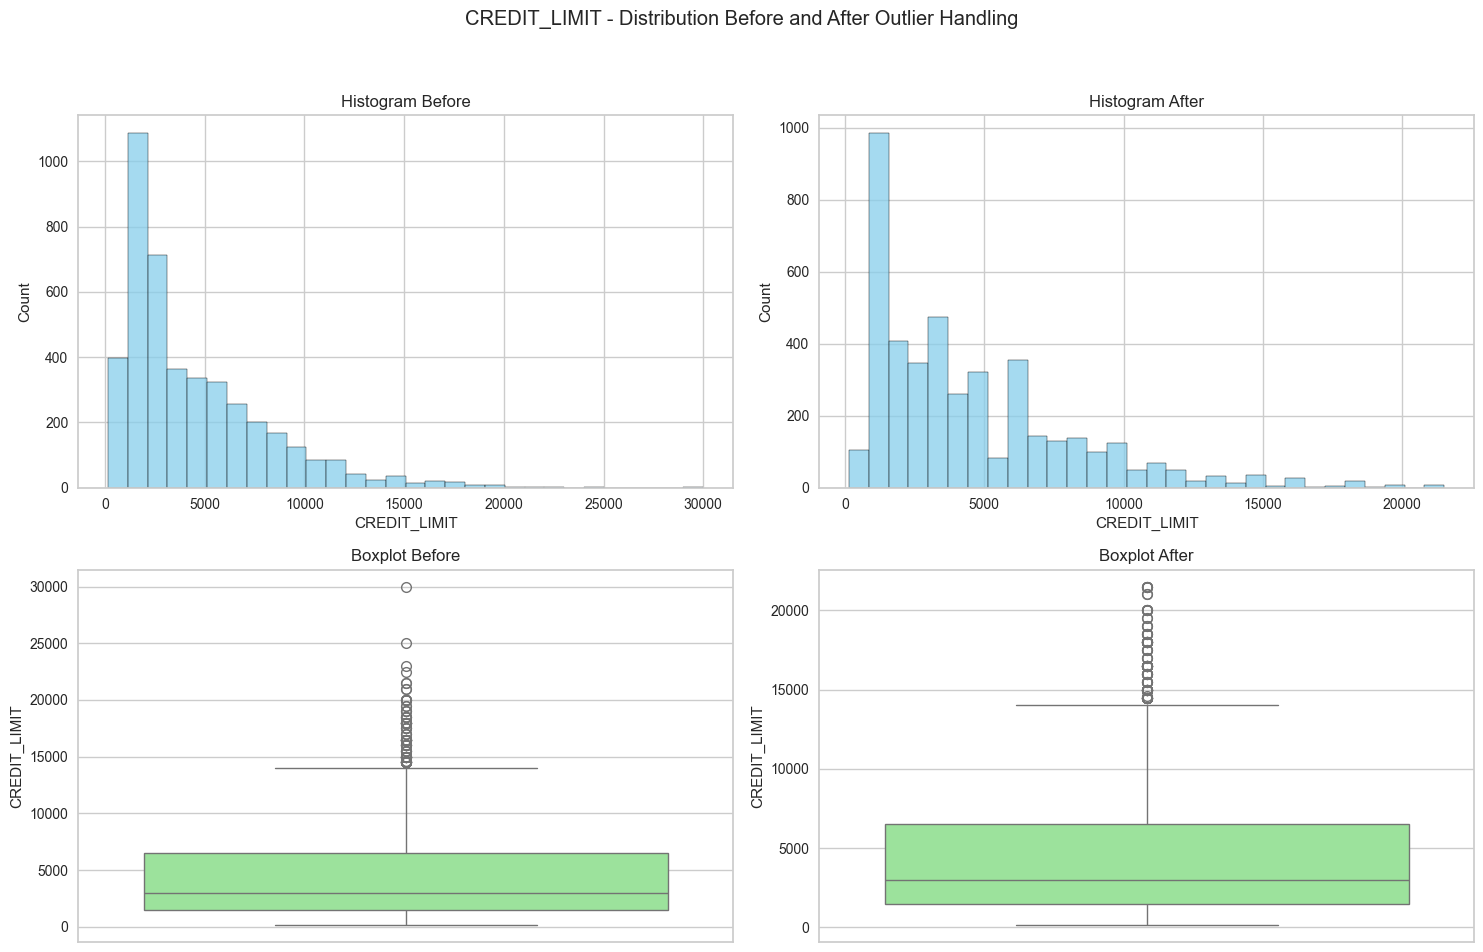

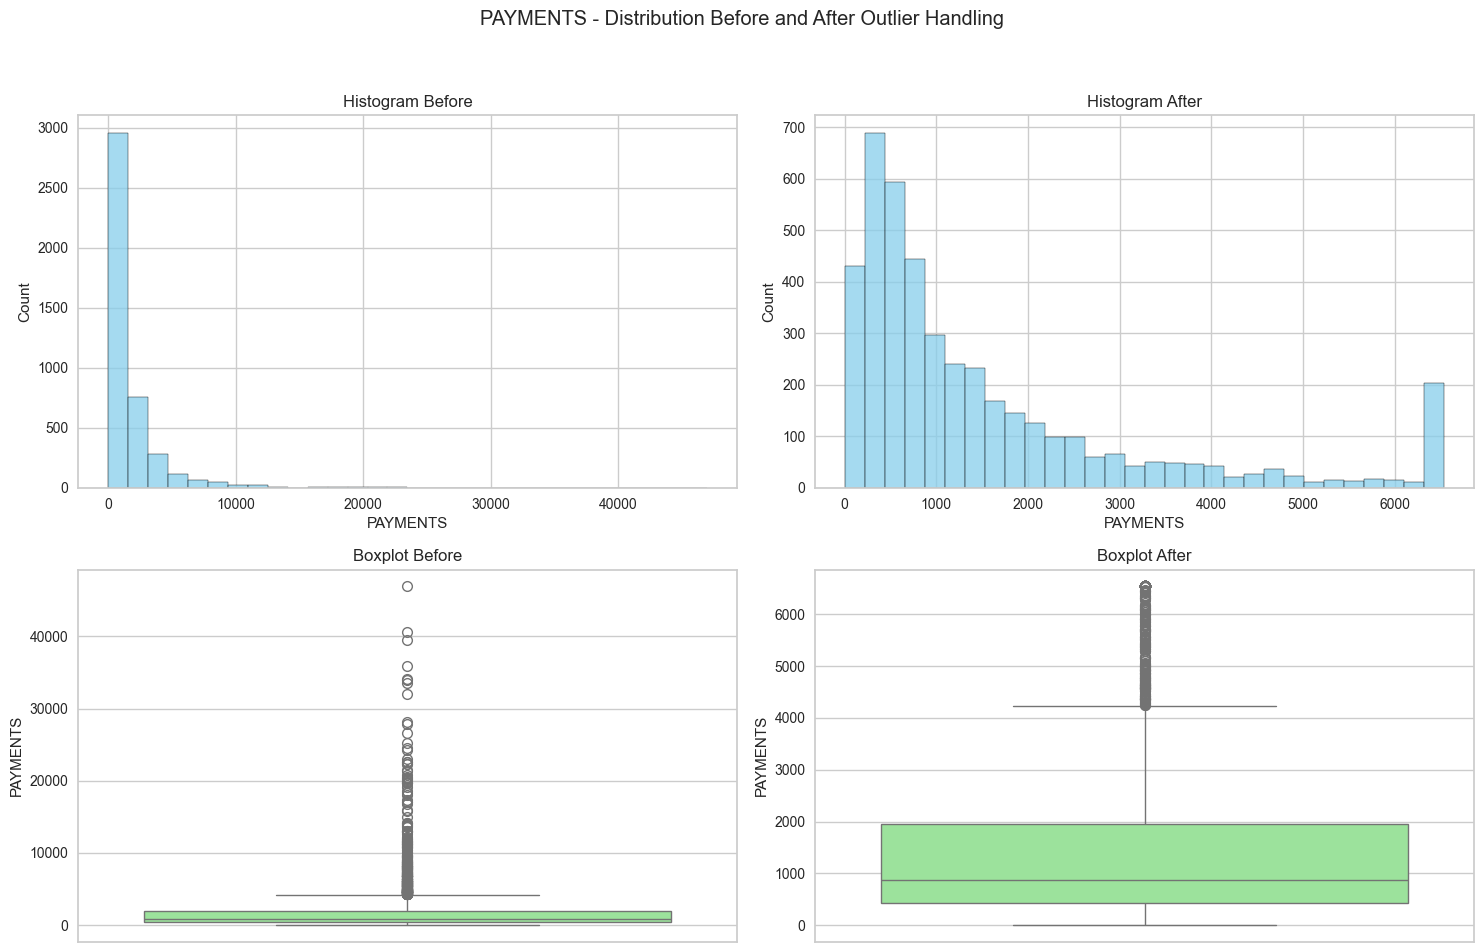

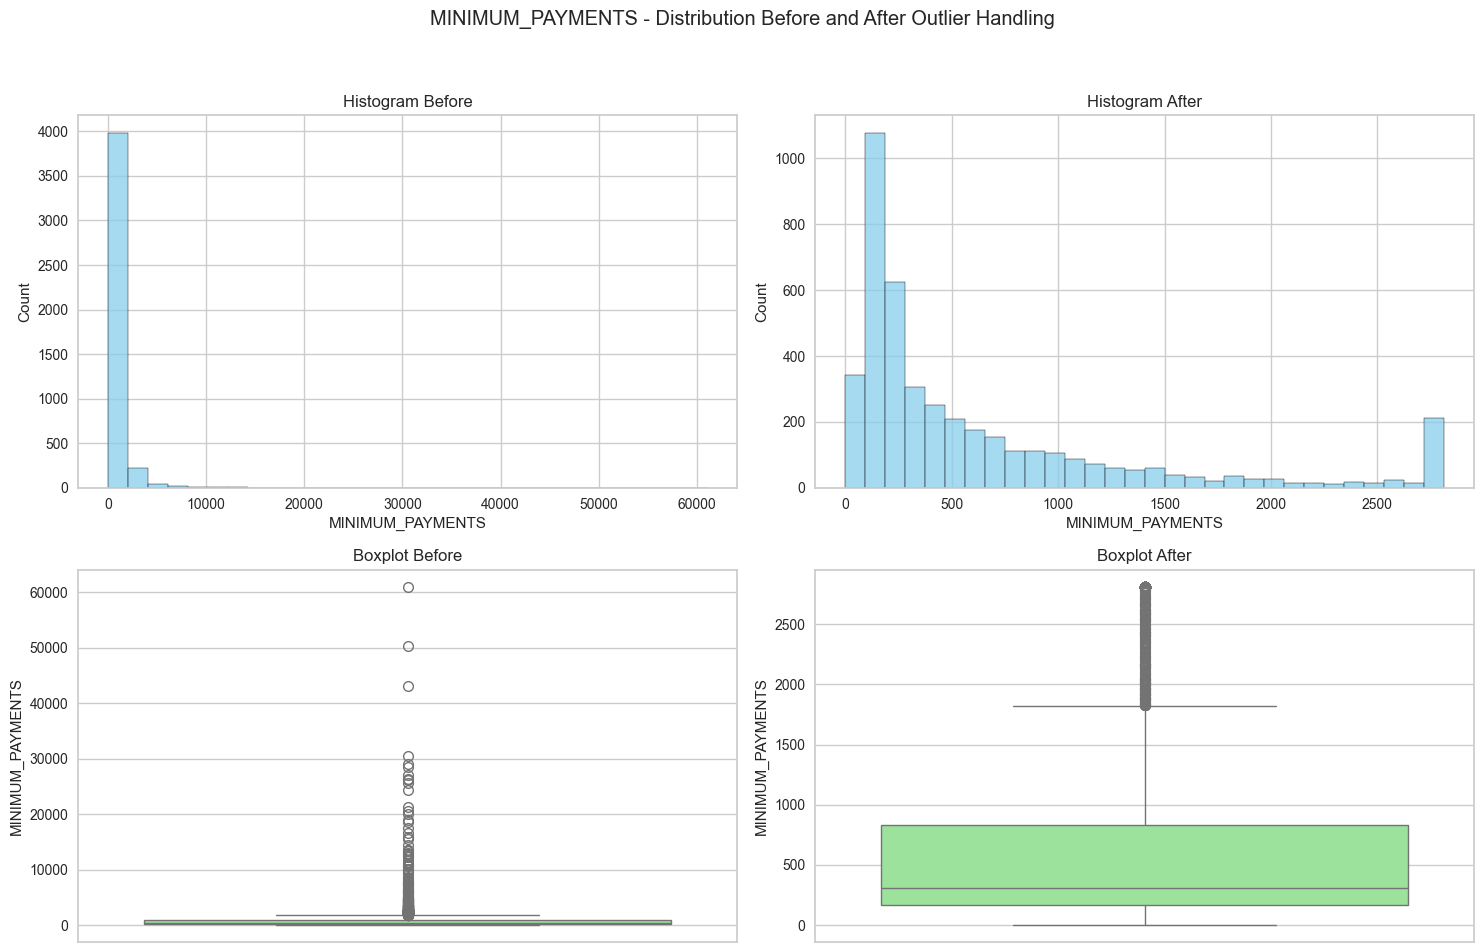

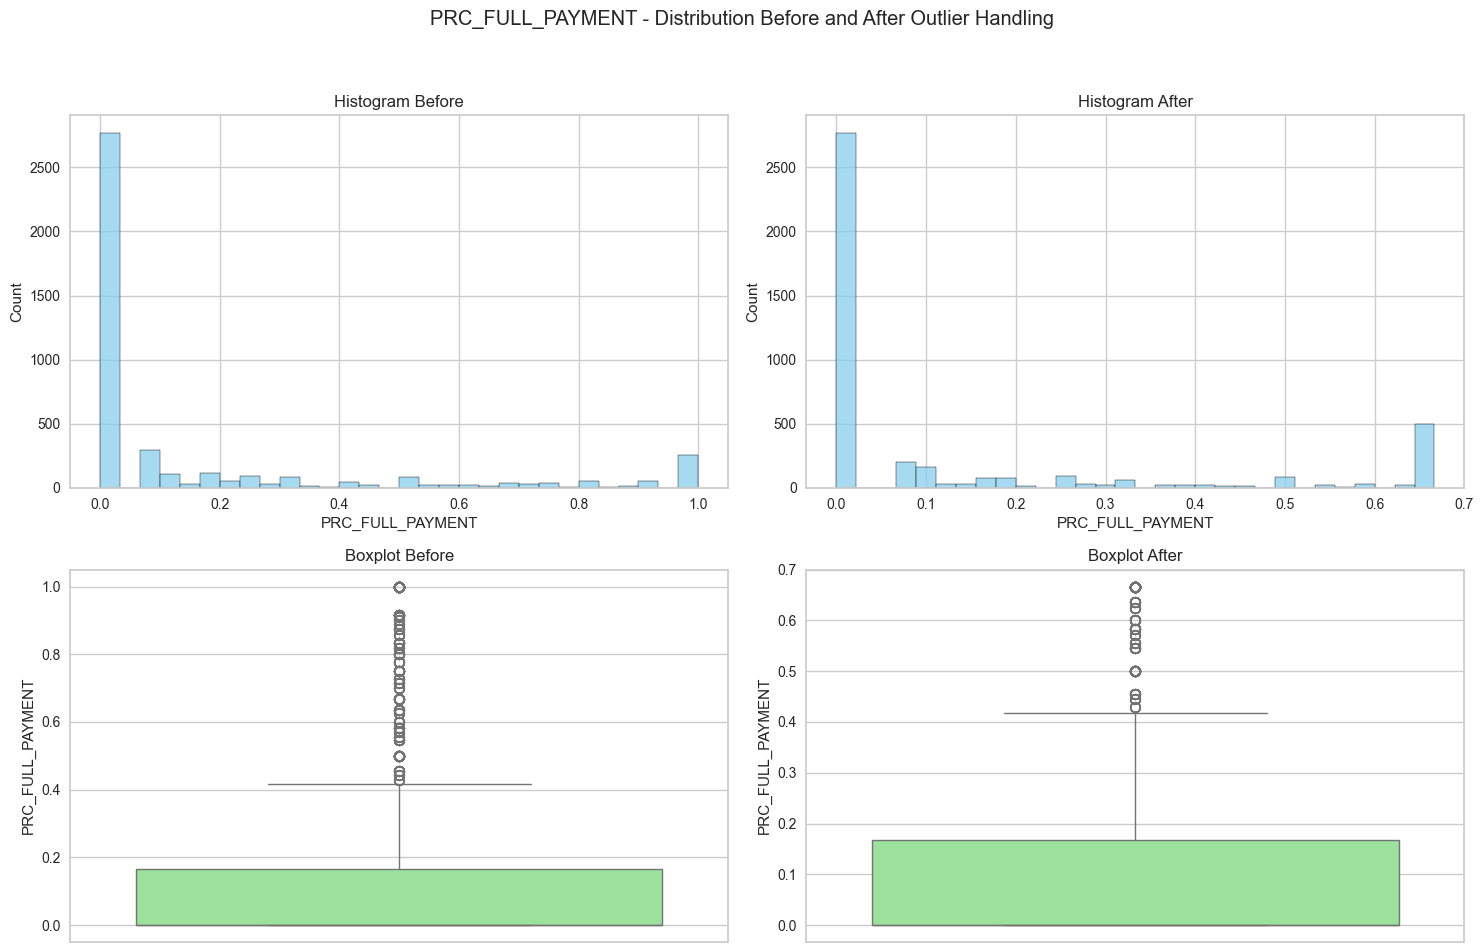

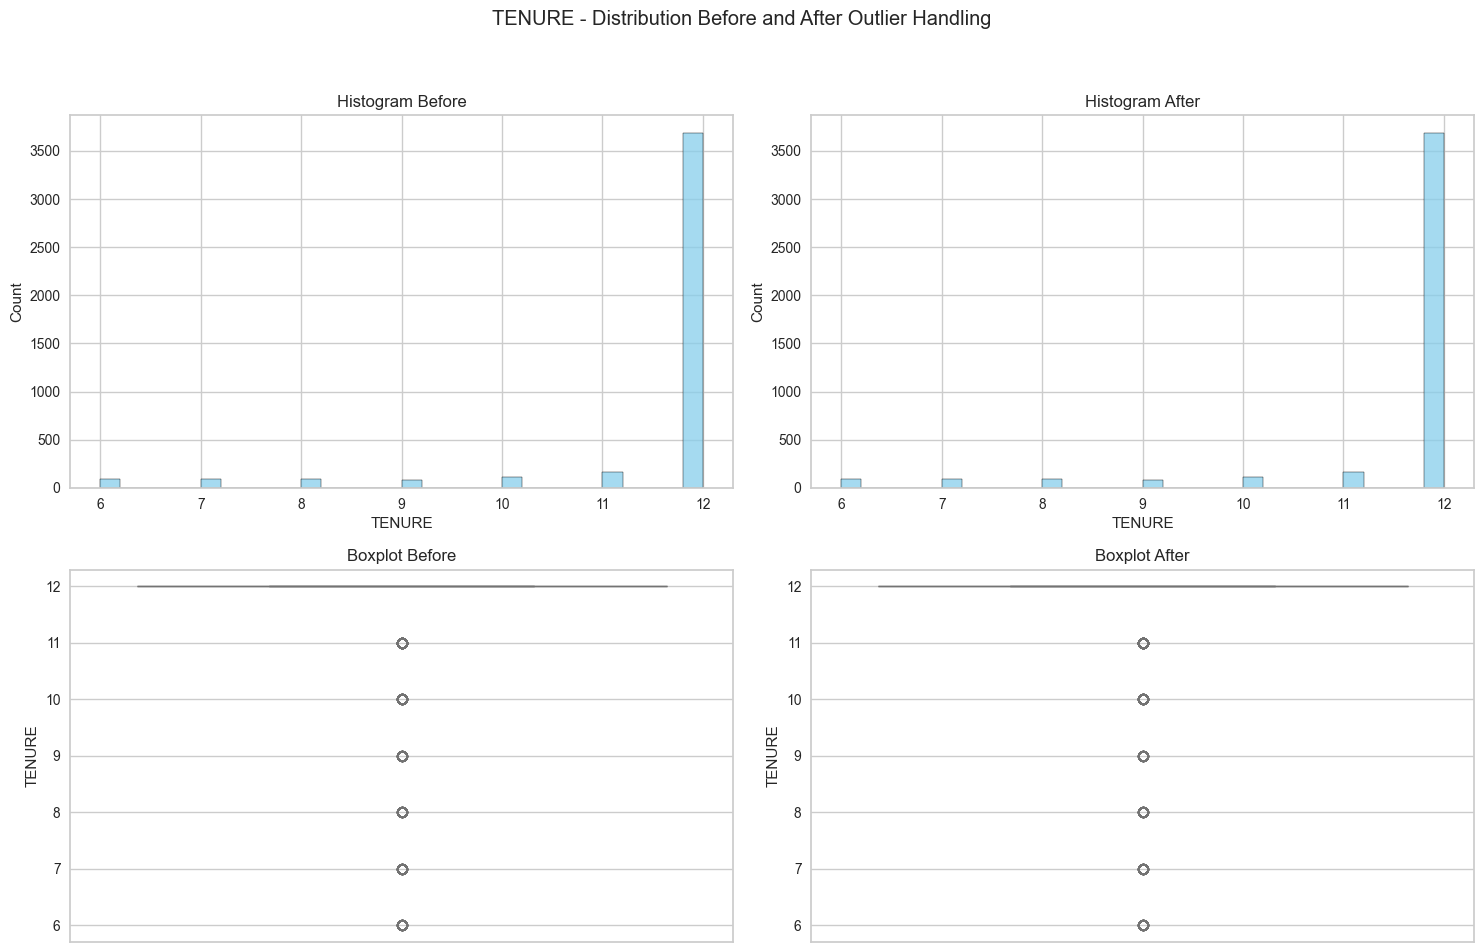

In [29]:
# Using the Function
num_cols = numeric_columns
for col in num_cols:
    outlier_handling_plot_comparison(df, df_capped, col)

**Penjelasan**  
Dilihat dari visualiasi data di atas, terdapat perubahan pada beberapa fitur antara sebelum dan setelah dilakukan outlier handling. Proses Outlier handling telah berhasil dilakukan.

## *Scaling*

In [30]:
# Drop Cust_ID
df_capped = df_capped.drop(columns=['CUST_ID'], axis=1)

**Penjelasan**  
 Drop kolom `CUST_ID` karena tidak memberikan informasi yang berguna untuk analisa dan memiliki banyak cardinality sehingga dapat menjadi noise.

In [31]:
# Initialize the MinMaxScaler
scaler = MinMaxScaler()

# Fit Scaler
scaler.fit(df_capped)

# Transform Scaler
df_scaled = scaler.transform(df_capped)

# Show data
df_scaled

array([[0.11807853, 0.65624966, 0.02306432, ..., 0.1459132 , 0.        ,
        0.33333333],
       [0.0577458 , 1.        , 0.13099637, ..., 0.05391439, 0.        ,
        0.33333333],
       [0.13184509, 1.        , 0.32469186, ..., 0.08073558, 0.        ,
        0.33333333],
       ...,
       [0.42377983, 1.        , 0.12561768, ..., 0.31497585, 0.        ,
        0.83333333],
       [0.60573781, 1.        , 0.3573693 , ..., 0.84497723, 0.13636323,
        0.83333333],
       [0.24739937, 1.        , 0.23109999, ..., 0.32374148, 0.13636323,
        0.83333333]])

**Penjelasan**  
Proses berikutnya yaitu scaling, dimana scaling yang saya gunakan kali ini yaitu dengan metoder MinMaxScaler. MinMaxScaler cocok digunakan pada data yang tidak terdistribusi normal.

In [32]:
# Changing fit and transformed data into dataframe
df_final = pd.DataFrame(df_scaled,columns=df_capped.columns)

df_final

BALANCE  BALANCE_FREQUENCY  PURCHASES  ONEOFF_PURCHASES  \
0     0.118079            0.65625   0.023064          0.042917   
1     0.057746            1.00000   0.130996          0.243750   
2     0.131845            1.00000   0.324692          0.604167   
3     0.279964            1.00000   0.026871          0.050000   
4     0.053183            0.00000   0.268711          0.500000   
...        ...                ...        ...               ...   
4311  0.135025            1.00000   0.000000          0.000000   
4312  0.101310            0.75000   0.000000          0.000000   
4313  0.423780            1.00000   0.125618          0.178008   
4314  0.605738            1.00000   0.357369          0.664971   
4315  0.247399            1.00000   0.231100          0.094542   

      INSTALLMENTS_PURCHASES  CASH_ADVANCE  PURCHASES_FREQUENCY  \
0                   0.000000      0.000000             0.125000   
1                   0.000000      0.000000             0.125000   
2                   0.000000      0.000000             0.125000   
3                   0.000000      0.000000             0.125000   
4                   0.000000      0.000000             0.125000   
...                      ...           ...                  ...   
4311                0.000000      0.283624             0.000000   
4312                0.000000      0.860094             0.000000   
4313                0.067069      0.452186             1.000000   
4314                0.000000      0.981610             0.454545   
4315                0.403706      0.976340             0.909091   

      ONEOFF_PURCHASES_FREQUENCY  PURCHASES_INSTALLMENTS_FREQUENCY  \
0                       0.125000                          0.000000   
1                       0.125000                          0.000000   
2                       0.125000                          0.000000   
3                       0.125000                          0.000000   
4                       0.125000                          0.000000   
...                          ...                               ...   
4311                    0.000000                          0.000000   
4312                    0.000000                          0.000000   
4313                    0.727273                          0.363636   
4314                    0.454545                          0.000000   
4315                    0.090909                          0.818182   

      CASH_ADVANCE_FREQUENCY  CASH_ADVANCE_TRX  PURCHASES_TRX  CREDIT_LIMIT  \
0                   0.000000            0.0000       0.015385      0.039813   
1                   0.000000            0.0000       0.015385      0.039813   
2                   0.000000            0.0000       0.015385      0.063232   
3                   0.000000            0.0000       0.015385      0.110070   
4                   0.000000            0.0000       0.015385      0.049180   
...                      ...               ...            ...           ...   
4311                0.545455            0.5625       0.000000      0.049180   
4312                0.545455            0.4375       0.000000      0.187354   
4313                0.545455            0.5625       0.307692      0.466042   
4314                0.545455            1.0000       0.384615      0.274005   
4315                0.545455            1.0000       0.261538      0.180328   

      PAYMENTS  MINIMUM_PAYMENTS  PRC_FULL_PAYMENT    TENURE  
0     0.032228          0.145913          0.000000  0.333333  
1     0.038768          0.053914          0.000000  0.333333  
2     0.060060          0.080736          0.000000  0.333333  
3     0.051793          0.253452          0.000000  0.333333  
4     0.008027          0.020151          0.000000  0.333333  
...        ...               ...               ...       ...  
4311  0.210503          0.096456          0.136363  0.833333  
4312  0.668705          0.085891          0.136363  0.833333  
4313  0.158346          0.314976          0.000000  

**Penjelasan**  
Membuat variabel baru yang berisi fitur-fitur yang sudah di scaling.

## *PCA - Dimensionality Reduction*

In [33]:
# Dimensionality Reduction using PCA
pca = PCA()
pca.fit(df_final)

PCA()

**Penjelasan**  
PCA digunakan ketika dataset memiliki banyak fitur berguna untuk mengoptimalkan berapa fitur yang digunakan berdasarkan nilai kepeceryaan yang dipilih. Di atas, mengartikan bahwa PCA telah berhasil dijalankan.

Text(0, 0.5, 'Eigenvalues')

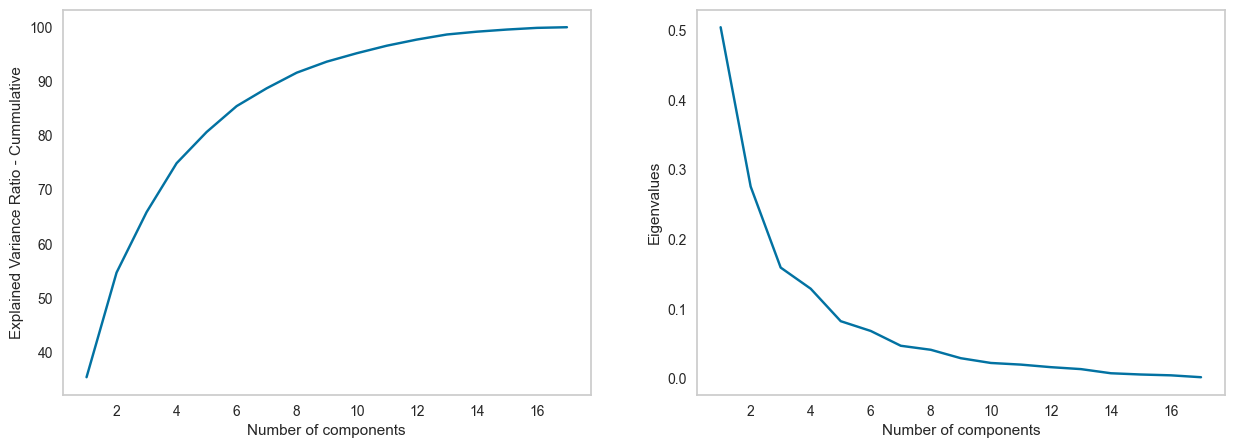

In [34]:
# Plot the Cummulative of Explained Variance Ratio
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.grid()
plt.plot(range(1, 18), np.cumsum(pca.explained_variance_ratio_ * 100))
plt.xlabel('Number of components')
plt.ylabel('Explained Variance Ratio - Cummulative')

# Plot the Eigenvalues
plt.subplot(1, 2, 2)
plt.grid()
plt.plot(range(1, 18), pca.explained_variance_ )
plt.xlabel('Number of components')
plt.ylabel('Eigenvalues')

**Penjelasan**  
Terdapat beberapa informasi dari dua grafik di atas, diantaranya:
- Grafik sebelah kiri merupakan cummulative EVR dimana pada grafik tersebut menggambarkan berapa banyak jumlah komponen (fitur) yang dapat mempertahankan sebagian informasi dari data asli. Misal jumlah komponen dari 8 sampai 10 bisa melebihi 90%, artinya dengan menggunakan 8-10 fitur kita sudah bisa menangkap informasi dari data asli di atas 90%.
- Grafik sebelah kanan merupakan eigenvalues dimana grafik tersebut menggambarkan semakin nilai eigenvalues mendekati 0 menunjukan bahwa data dapat direpresentasikan secara efektif dalam ruang dimensional yang lebih rendah. Misal nilai jumlah komponen dari 8-10 dan nilai eigenvalues sudah mendekati 0 artinya dari jumlah komponen 8-10 sudah bisa merepresentasikan keseluruhan data.

In [35]:
# Check the number of features if we want to retain 95 % of the information
cumsum = np.cumsum(pca.explained_variance_ratio_)
num_features = np.argmax(cumsum >= 0.95) + 1
num_features

10

**Penjelasan**  
Jumlah komponen yang didapat dari 95% informasi dari data yaitu 10. Nilai 95% merupakan nilai treshold informasi yang akan dipelajari dari data artinya kita hanya mengambil 10 fitur tetapi informasi yang sudah diambil dari sebanyak 95%. 

In [36]:
# Let's train the model with 95 % of the original dataset information
pca = PCA(n_components=0.95)
pca.fit(df_final)

sales_scaled_pca = pca.transform(df_final)

**Penjelasan**  
Membuat PCA dengan nilai treshold 95% dari data asli. 

# **7. Definisi Model**

Salah satu model untuk clustering yaitu K-Means. Nilai K harus didapatkan pada saat sebelum memulai clustering. K-Means cenderung melakukan analisa pada numerical kolom. Terdapat beberapa cara dalam menentukan nilai K, antara lain:
- **Elbow Method**  
Digunakan untuk menentukan jumlah cluster yang optimal dengan mengamati titik dimana laju penurunan pada WCSS melambat, itu menandakan jumlah cluster yang sesuai untuk digunakan. Atau bisa dikatakan mencari titik patahannya (seperti bentuk siku manusia).
- **Silhouette score**  
Digunakan dengan cara mengukur seperti apa kesamaan tiap data point yang dicari pada cluster dibandingkan dengan cluster lain. Dimana range antara -1 sampai 1. -1 artinya tiap titik point mungkin berada pada cluster yang salah, 0 artinya cluster overlappin, dan 1 artinya titik point yang sempurna dan tidak ada yang overlap ditiap cluster.
- **Silhouette plot**  
Digunakan dengan cara melihat plot yang sudah divisualisasikan, dengan syarat yang pertama tiap cluster harus melewat nilai rata-rata silhouette score dan yang kedua tidak boleh memiliki fluktuasi pada ukuran cluster.

## *Elbow Method*

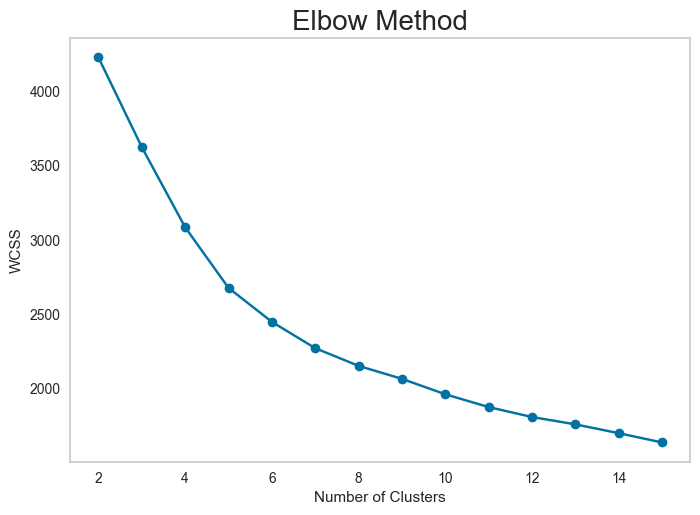

In [37]:
# Find the optimal number of clusters using Elbow Method
from sklearn.cluster import KMeans

wcss = []
random_state = 20
max_cluster = 15  
for i in range(2, max_cluster+1):
    km = KMeans(n_clusters = i,
                init = 'k-means++',
                max_iter = 300,
                n_init = 10,
                random_state = random_state)
    km.fit(sales_scaled_pca)
    wcss.append(km.inertia_)

plt.plot(range(2, max_cluster+1), wcss, marker ="o")
plt.grid()
plt.title('Elbow Method', fontsize = 20)
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.show()

**Penjelasan**  
Pada gambar di atas bisa dilihat bahwa titik elbow berada pada nomer 4 sampai 6.

## *Silhoutte Method*

In [38]:
# Function to create Silhouette Plot
def plot_silhouette(range_n_clusters, X, random_state):
    for n_clusters in range_n_clusters:
        # Create a subplot with 1 row and 2 columns
        fig, (ax1, ax2) = plt.subplots(1, 2)
        fig.set_size_inches(18, 4)

        # The 1st subplot is the silhouette plot
        # The silhouette coefficient can range from -1, 1 but in this example all lie within [-0.1, 1]
        ax1.set_xlim([-0.1, 1])
        # The (n_clusters+1)*10 is for inserting blank space between silhouette plots of individual clusters, to demarcate them clearly.
        ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

        # Initialize the clusterer with n_clusters value and a random generator seed of 10 for reproducibility.
        clusterer = KMeans(n_clusters = n_clusters, init = 'k-means++', max_iter = 300, n_init = 10, random_state = random_state)
        cluster_labels = clusterer.fit_predict(X)

        # The silhouette_score gives the average value for all the samples.
        # This gives a perspective into the density and separation of the formed clusters
        silhouette_avg = silhouette_score(X, cluster_labels)
        print("For n_clusters =", n_clusters,
              "The average silhouette_score is :", silhouette_avg)

        # Compute the silhouette scores for each sample
        sample_silhouette_values = silhouette_samples(X, cluster_labels)

        y_lower = 10
        for i in range(n_clusters):
            # Aggregate the silhouette scores for samples belonging to cluster i, and sort them
            ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
            ith_cluster_silhouette_values.sort()

            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = cm.nipy_spectral(float(i) / n_clusters)
            ax1.fill_betweenx(np.arange(y_lower, y_upper),
                              0, ith_cluster_silhouette_values,
                              facecolor=color, edgecolor=color, alpha=0.7)

            # Label the silhouette plots with their cluster numbers at the middle
            ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

            # Compute the new y_lower for next plot
            y_lower = y_upper + 10  # 10 for the 0 samples

        ax1.set_title("The silhouette plot for the various clusters.")
        ax1.set_xlabel("The silhouette coefficient values")
        ax1.set_ylabel("Cluster label")

        # The vertical line for average silhouette score of all the values
        ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

        ax1.set_yticks([])  # Clear the yaxis labels / ticks
        ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

        # 2nd Plot showing the actual clusters formed
        colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
        ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                    c=colors, edgecolor='k')

        # Labeling the clusters
        centers = clusterer.cluster_centers_

        # Draw white circles at cluster centers
        ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                    c="white", alpha=1, s=200, edgecolor='k')

        for i, c in enumerate(centers):
            ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1, s=50, edgecolor='k')

        ax2.set_title("The visualization of the clustered data.")
        ax2.set_xlabel("Feature space for the 1st feature")
        ax2.set_ylabel("Feature space for the 2nd feature")

        plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                      "with n_clusters = %d" % n_clusters),
                     fontsize=14, fontweight='bold')

For n_clusters = 2 The average silhouette_score is : 0.27380136513742714
For n_clusters = 3 The average silhouette_score is : 0.2457234166849308
For n_clusters = 4 The average silhouette_score is : 0.261727451180448
For n_clusters = 5 The average silhouette_score is : 0.26107582083426445
For n_clusters = 6 The average silhouette_score is : 0.2654548320169009
For n_clusters = 7 The average silhouette_score is : 0.2600230552871464
For n_clusters = 8 The average silhouette_score is : 0.25994446979704783
For n_clusters = 9 The average silhouette_score is : 0.25769287126997925
For n_clusters = 10 The average silhouette_score is : 0.24692226135837628
For n_clusters = 11 The average silhouette_score is : 0.24346046399332089
For n_clusters = 12 The average silhouette_score is : 0.254981380393719
For n_clusters = 13 The average silhouette_score is : 0.2112899203727865
For n_clusters = 14 The average silhouette_score is : 0.2256102613234687


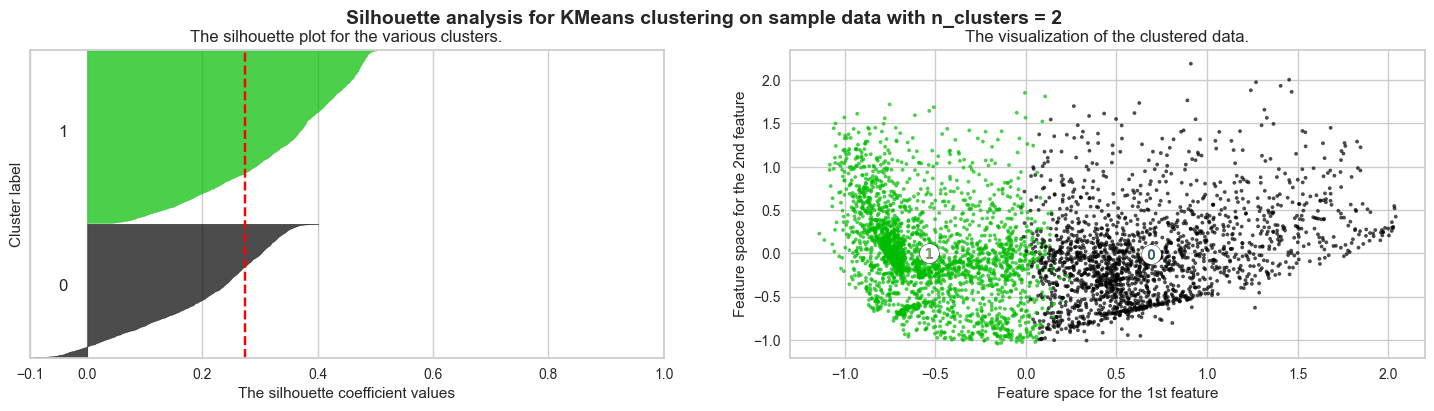

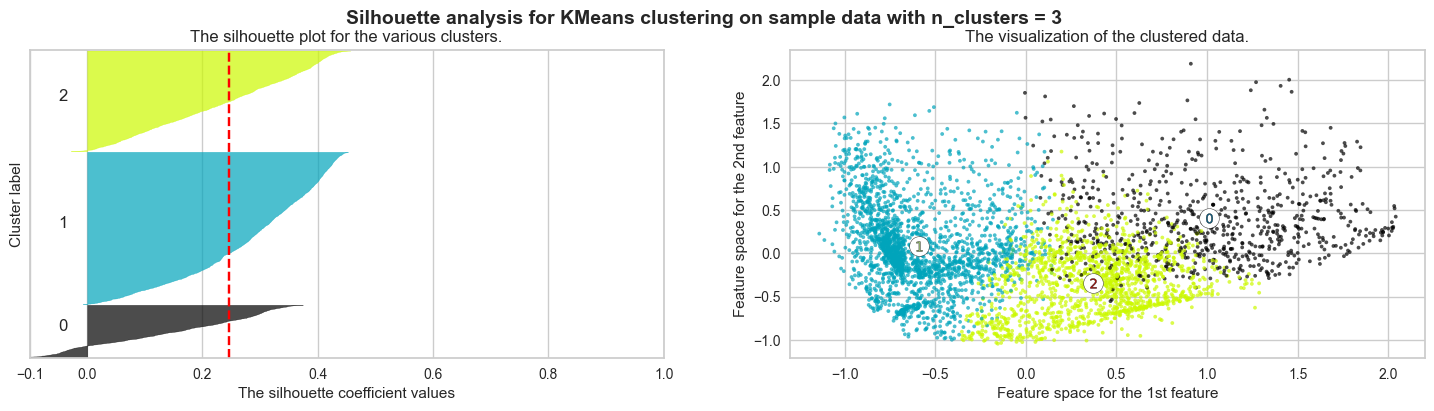

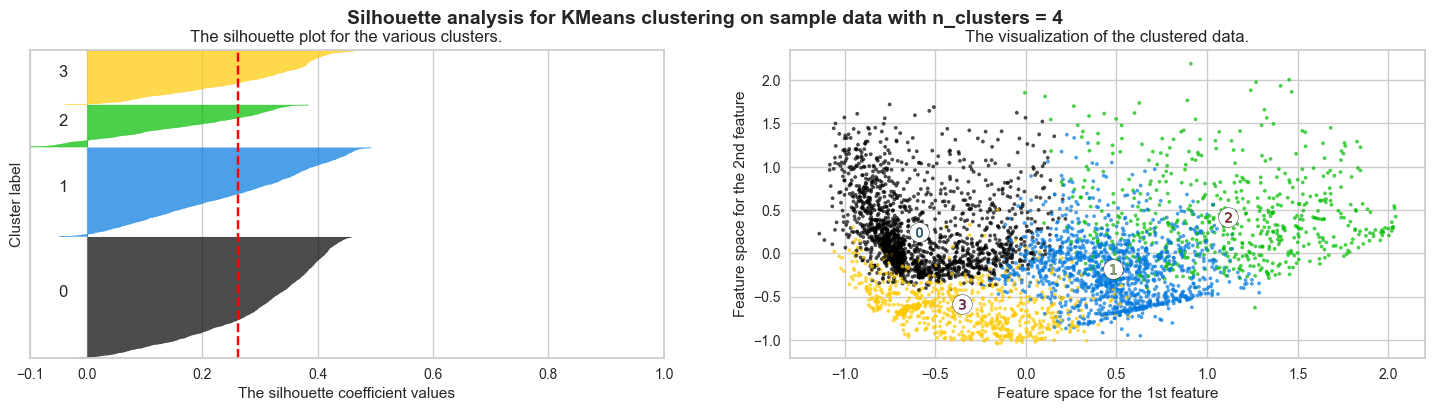

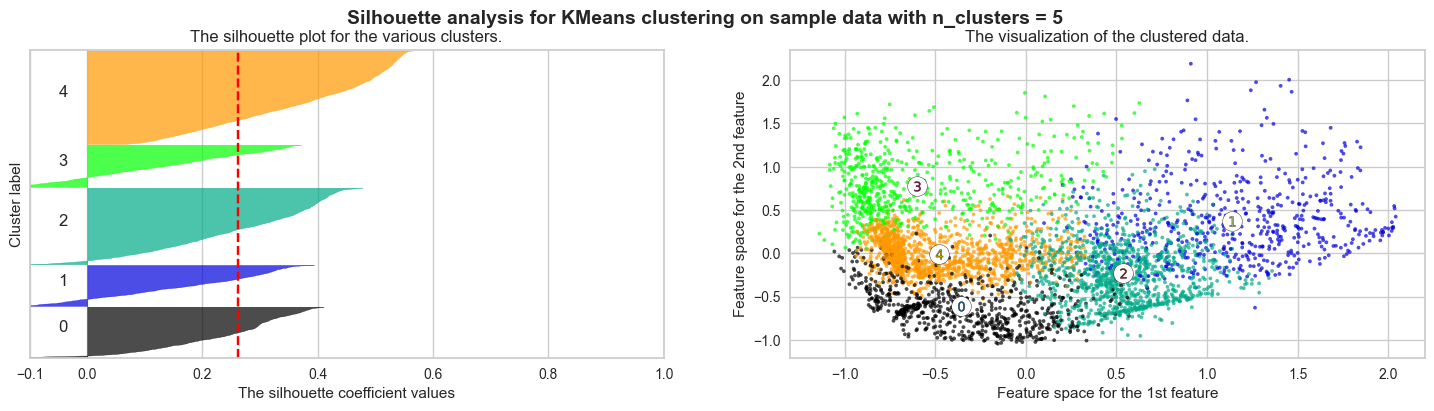

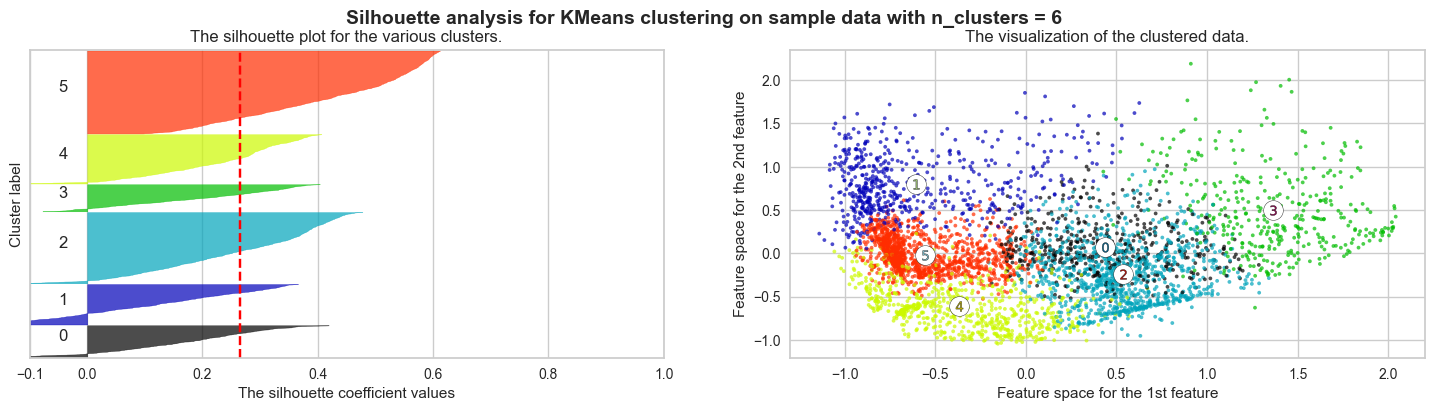

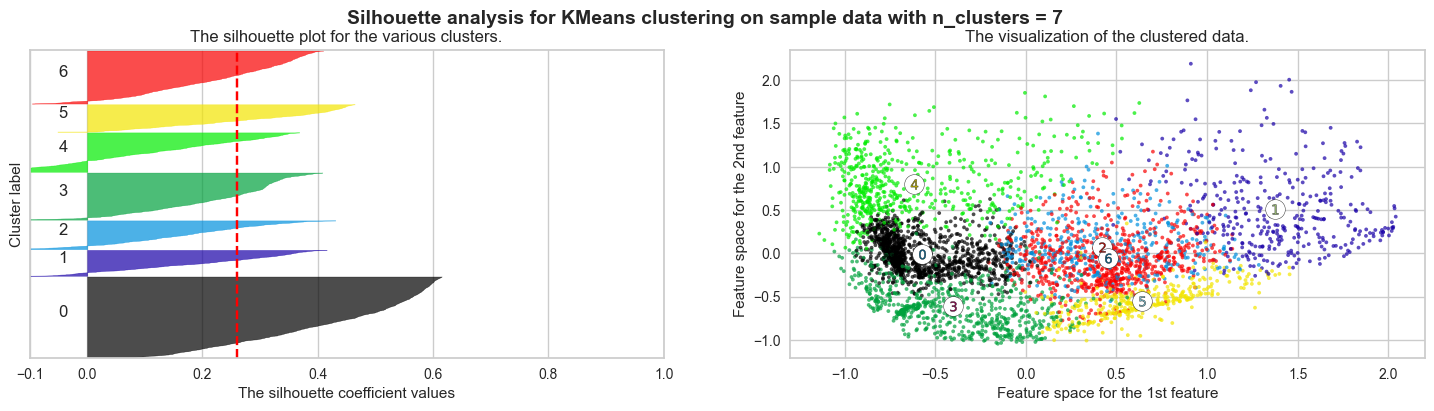

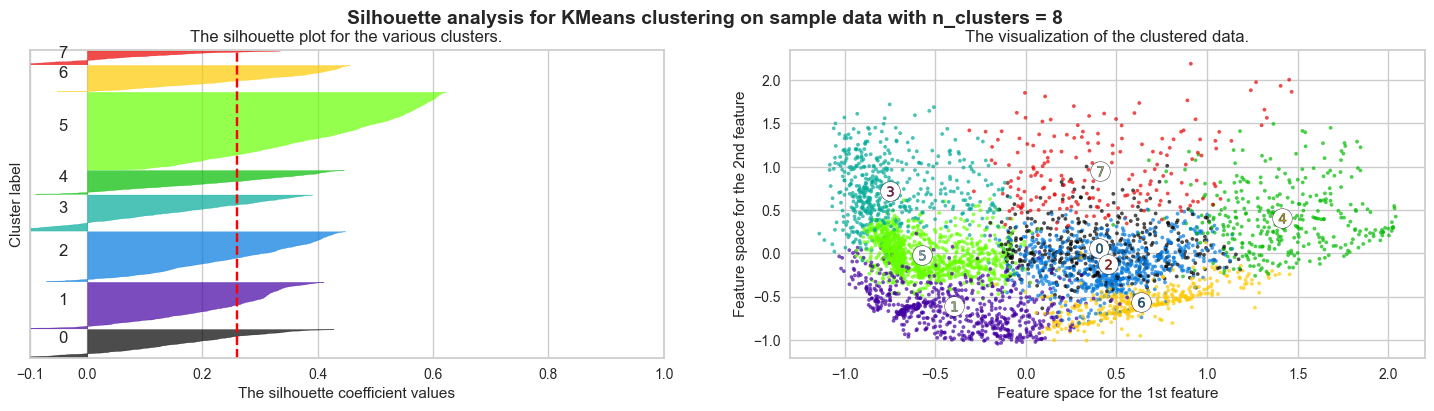

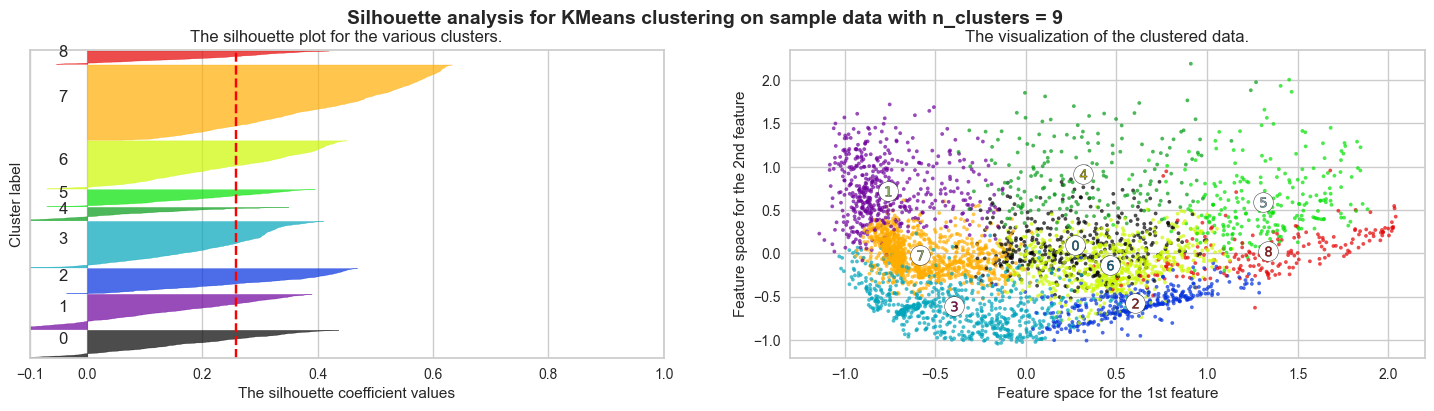

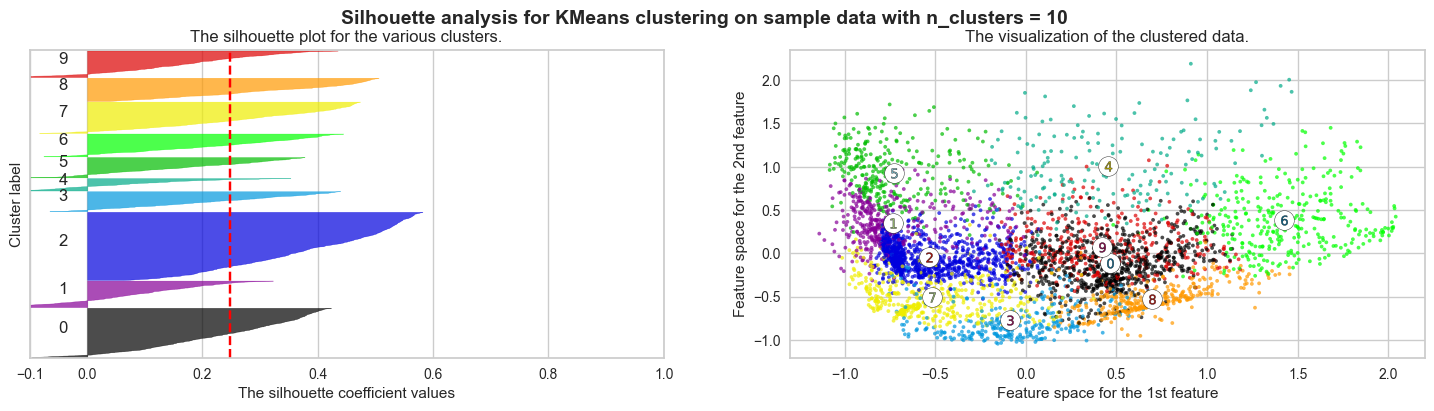

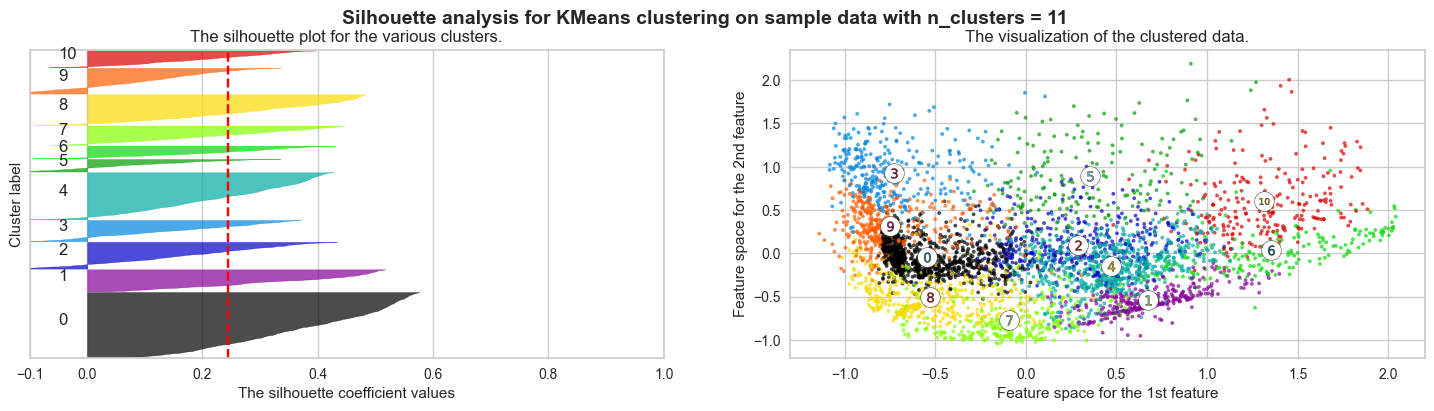

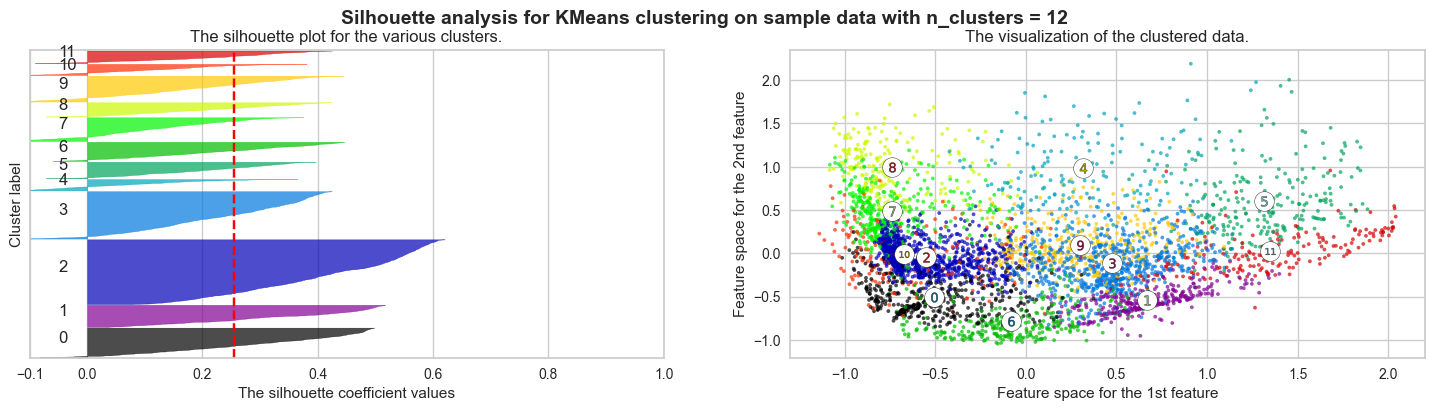

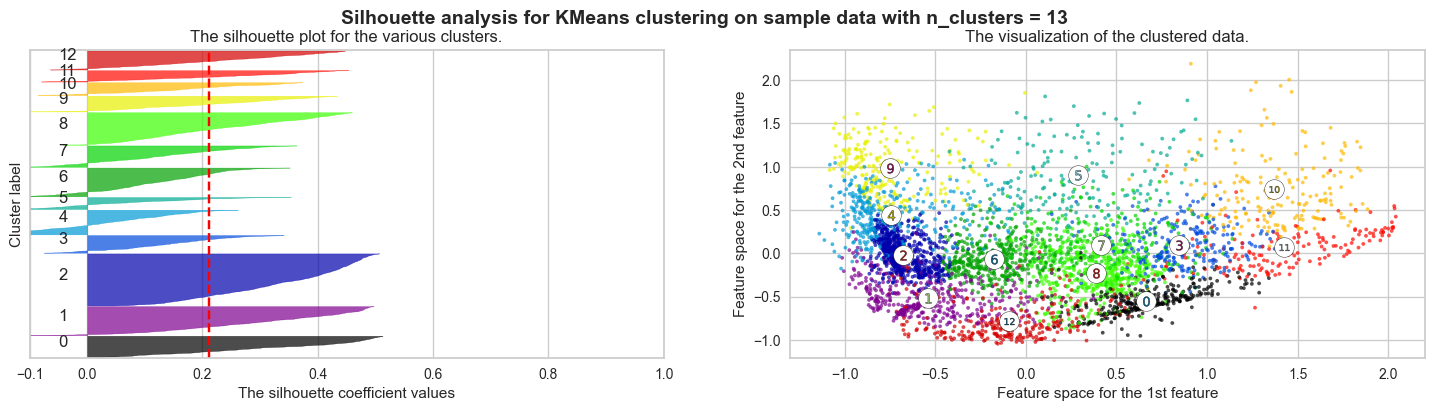

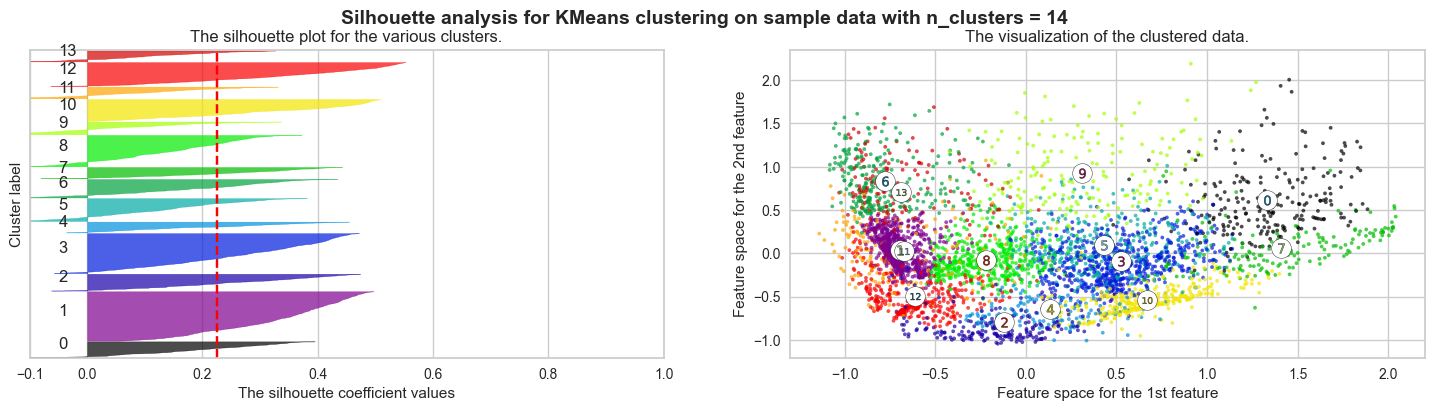

In [39]:
# Display the Silhouette Score and Plot Silhouette Plot

plot_silhouette(range(2, max_cluster), sales_scaled_pca, random_state)

**Penjelasan**  
Dari analisa Silhouette di atas terdapat beberapa informasi, yaitu:
1. Nilai Silhouette Score tiap berada diantara nilai 0.2 - 0.275 dan yang memiliki nilai tertinggi terdapat pada cluster nomor 2, 4 dan 5.
2. Pada visualisasi Silhouette Plot jika dilihat nilai 2, 4 dan 5 juga memiliki visualisasi yang bagus dimana nilai Silhouette tiap cluster berada lebih tinggi dari nilai rata-rata nya dan ukuran cluster juga tidak fluktuasi. 

**Kesimpulan Nilai K**  
Berdasarkan dari 3 metode (elbow method, Silhouette Score dan Silhouette Plot) Saya memilih nilai K untuk cluster yaitu 4. Karena nilai 4 sudah memenuhi syarat dari ketiga metode tersebut. Berikutnya yaitu melakukan model training. 

# **8. *Model Training***

# K-Means Model

In [40]:
# Train with optimal number of clusters

km = KMeans(n_clusters = 4, init = 'k-means++', max_iter = 300, n_init = 10, random_state = random_state)
pred = km.fit_predict(sales_scaled_pca)
pred

array([0, 0, 0, ..., 1, 0, 1])

**Penjelasan**  
K-Means model melakukan training pada data, dengan n_cluster atau nilai K 4.

# **9. *Model Evaluation***

In [41]:
# Insert clustering result into original dataset
df_final['CLUSTER'] = pred
df_final

BALANCE  BALANCE_FREQUENCY  PURCHASES  ONEOFF_PURCHASES  \
0     0.118079            0.65625   0.023064          0.042917   
1     0.057746            1.00000   0.130996          0.243750   
2     0.131845            1.00000   0.324692          0.604167   
3     0.279964            1.00000   0.026871          0.050000   
4     0.053183            0.00000   0.268711          0.500000   
...        ...                ...        ...               ...   
4311  0.135025            1.00000   0.000000          0.000000   
4312  0.101310            0.75000   0.000000          0.000000   
4313  0.423780            1.00000   0.125618          0.178008   
4314  0.605738            1.00000   0.357369          0.664971   
4315  0.247399            1.00000   0.231100          0.094542   

      INSTALLMENTS_PURCHASES  CASH_ADVANCE  PURCHASES_FREQUENCY  \
0                   0.000000      0.000000             0.125000   
1                   0.000000      0.000000             0.125000   
2                   0.000000      0.000000             0.125000   
3                   0.000000      0.000000             0.125000   
4                   0.000000      0.000000             0.125000   
...                      ...           ...                  ...   
4311                0.000000      0.283624             0.000000   
4312                0.000000      0.860094             0.000000   
4313                0.067069      0.452186             1.000000   
4314                0.000000      0.981610             0.454545   
4315                0.403706      0.976340             0.909091   

      ONEOFF_PURCHASES_FREQUENCY  PURCHASES_INSTALLMENTS_FREQUENCY  \
0                       0.125000                          0.000000   
1                       0.125000                          0.000000   
2                       0.125000                          0.000000   
3                       0.125000                          0.000000   
4                       0.125000                          0.000000   
...                          ...                               ...   
4311                    0.000000                          0.000000   
4312                    0.000000                          0.000000   
4313                    0.727273                          0.363636   
4314                    0.454545                          0.000000   
4315                    0.090909                          0.818182   

      CASH_ADVANCE_FREQUENCY  CASH_ADVANCE_TRX  PURCHASES_TRX  CREDIT_LIMIT  \
0                   0.000000            0.0000       0.015385      0.039813   
1                   0.000000            0.0000       0.015385      0.039813   
2                   0.000000            0.0000       0.015385      0.063232   
3                   0.000000            0.0000       0.015385      0.110070   
4                   0.000000            0.0000       0.015385      0.049180   
...                      ...               ...            ...           ...   
4311                0.545455            0.5625       0.000000      0.049180   
4312                0.545455            0.4375       0.000000      0.187354   
4313                0.545455            0.5625       0.307692      0.466042   
4314                0.545455            1.0000       0.384615      0.274005   
4315                0.545455            1.0000       0.261538      0.180328   

      PAYMENTS  MINIMUM_PAYMENTS  PRC_FULL_PAYMENT    TENURE  CLUSTER  
0     0.032228          0.145913          0.000000  0.333333        0  
1     0.038768          0.053914          0.000000  0.333333        0  
2     0.060060          0.080736          0.000000  0.333333        0  
3     0.051793          0.253452          0.000000  0.333333        0  
4     0.008027          0.020151          0.000000  0.333333        3  
...        ...               ...               ...       ...      ...  
4311  0.210503          0.096456          0.136363  0.833333        0  
4312  0.668705          0.085891          0

**Penjelasan**  
Dengan menambahkan kolom `CLUSTER` pada dataset. Dimana nilainya merupakan hasil dari clustering yang dilakukan oleh model K-Means. Artinya penerapan model K-Means sudah berhasil dilakukan. Berikutnya yaitu melakukan analisa untuk mengetahui karakteristik dari masing-masing cluster.

## Analisis data setelah *modeling*

### Visualisasi cluster atau segmentasi

<Axes: >

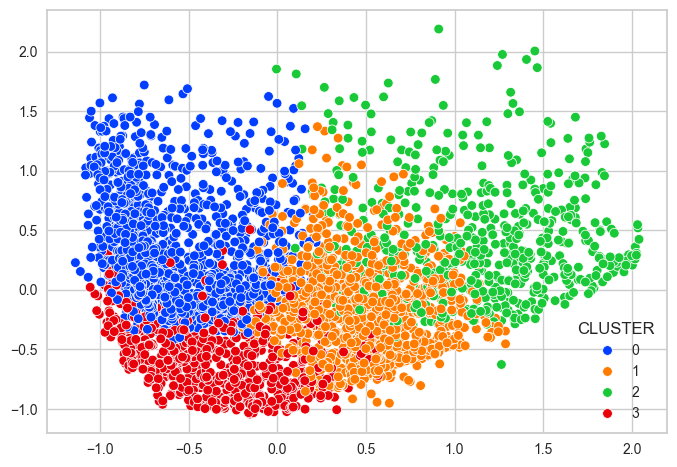

In [42]:
# Cluster visualization in 2D
pca_2d = PCA(n_components=2)  # =2 which mean 2 dimension
pca_2d.fit(df_scaled)

sales_scaled_pca_2d = pca_2d.fit_transform(df_scaled)

sns.scatterplot(x=sales_scaled_pca_2d[:,0], y=sales_scaled_pca_2d[:,1], hue=df_final['CLUSTER'], palette='bright')

**Penjelasan**  
Gambar di atas merupakan visualisasi 2 dimensi dari masing-masing cluster dengan menggunakan scatter plot. Masing-masing cluster dikelompokan dengan warna yang berbeda. Dari sini dapat dilihat masing-masing cluster memiliki perbedaan karakteristik. Selanjutnya yaitu mencari tau karakteristik tiap cluster.

### Distribusi dan karakteristik *Cluster*

Saya akan melakukan analisa karakteristik tiap cluster berdasarkan:
- Saldo tiap cluster
- Perilaku Pembelian tiap cluster 
- Perilaku pemakaian kartu kredit 
- Limit Credit tiap cluster
- Saat pembelian lebih suka sekali bayar (tunai) atau melakukan pembelian dengan cicilan
- Kartu kredit lebih suka digunakan untuk kebutuhan membeli barang atau untuk tarik tunai

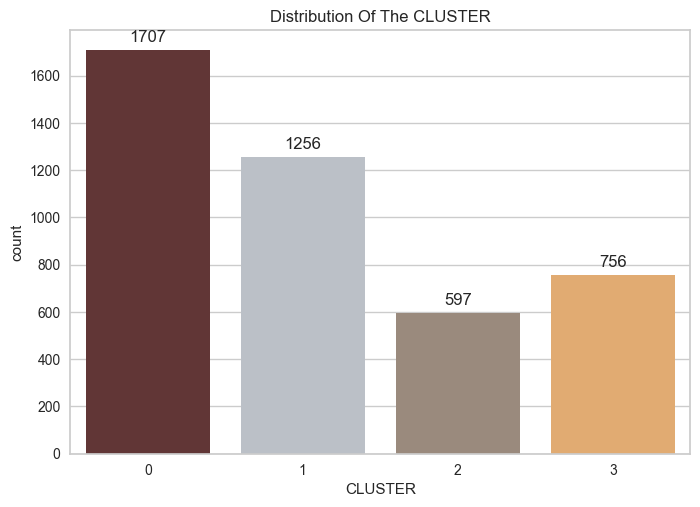

In [43]:
# Plotting countplot of clusters
pal = ["#682F2F","#B9C0C9", "#9F8A78","#F3AB60"]
pl = sns.countplot(x=df_final['CLUSTER'], palette=pal)

# Annotate each bar with its count value
for p in pl.patches:
    pl.annotate(format(p.get_height(), '.0f'), 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha = 'center', va = 'center', 
                xytext = (0, 9), 
                textcoords = 'offset points')

pl.set_title("Distribution Of The CLUSTER")
plt.show()

**Penjelasan**  
Terjadi sedikit ketimpangan pada distribusi tiap cluster dimana cluster 0 memiliki distribusi paling banyak dengan 1707, sedangkan cluster 2 memiliki distribusi paling sedikit dengan 597.

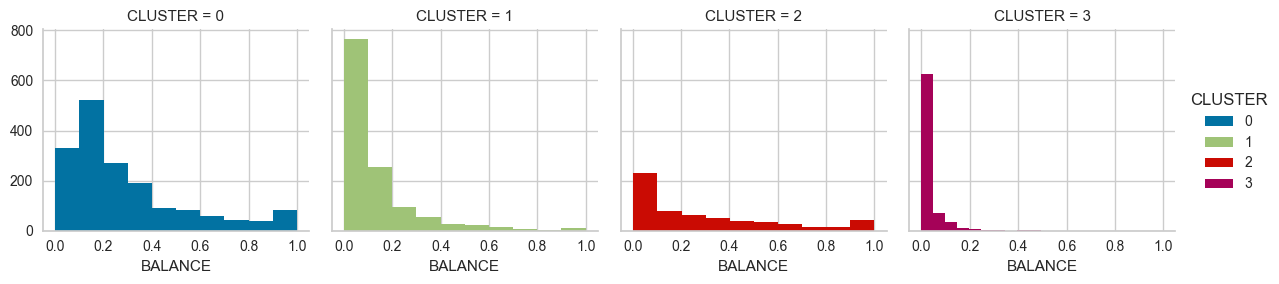

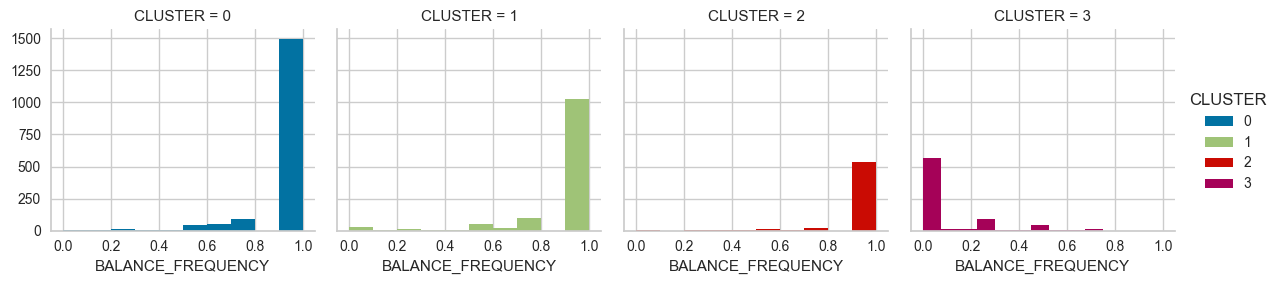

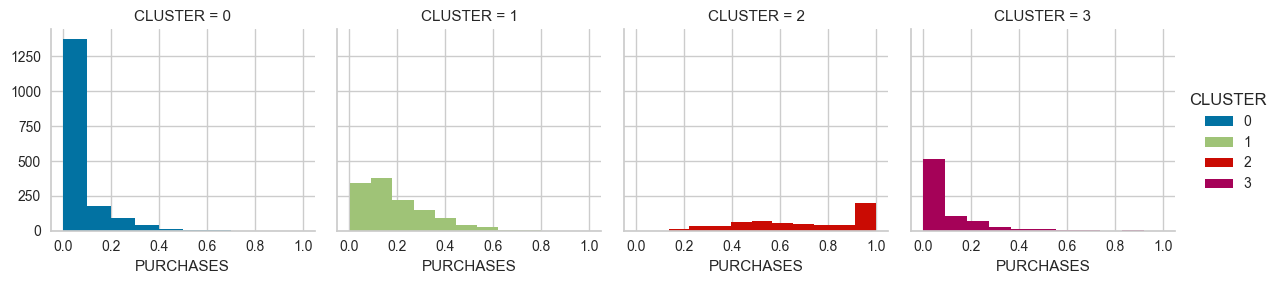

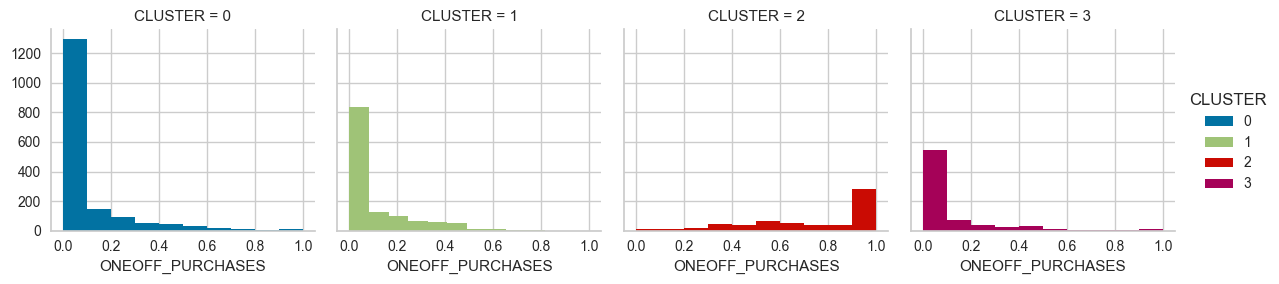

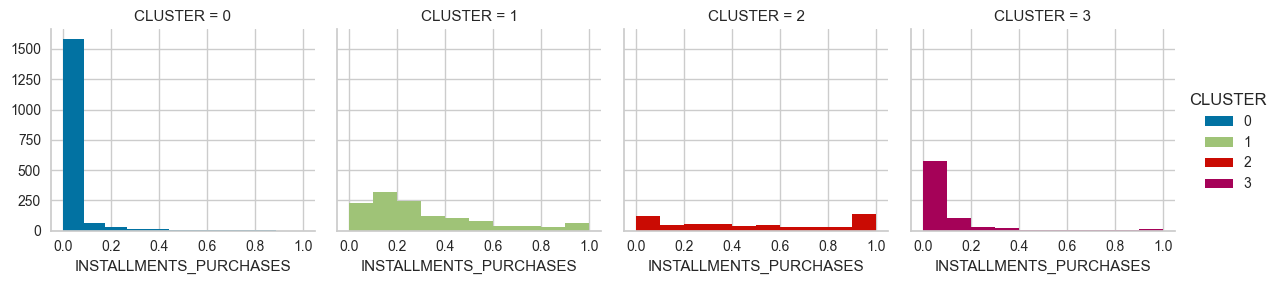

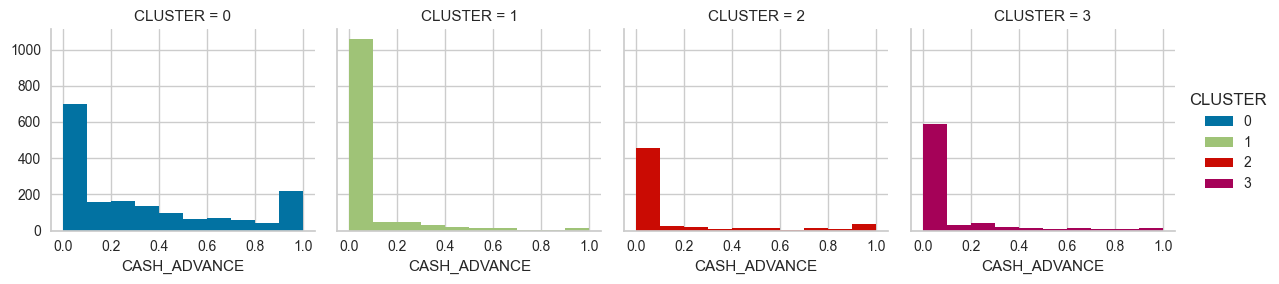

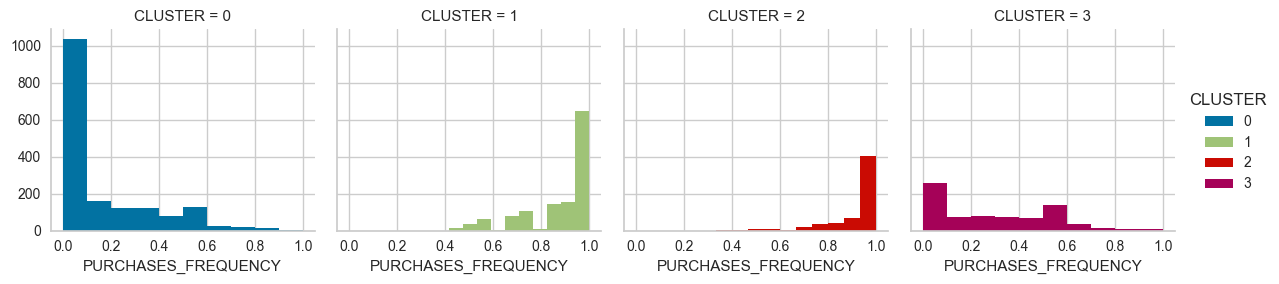

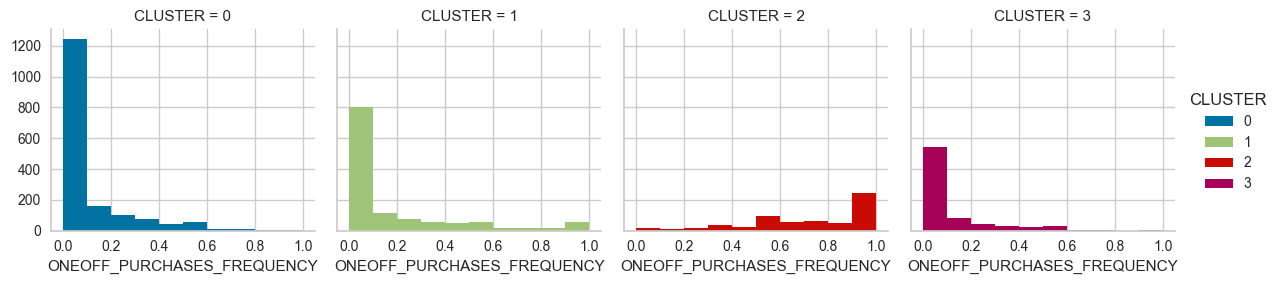

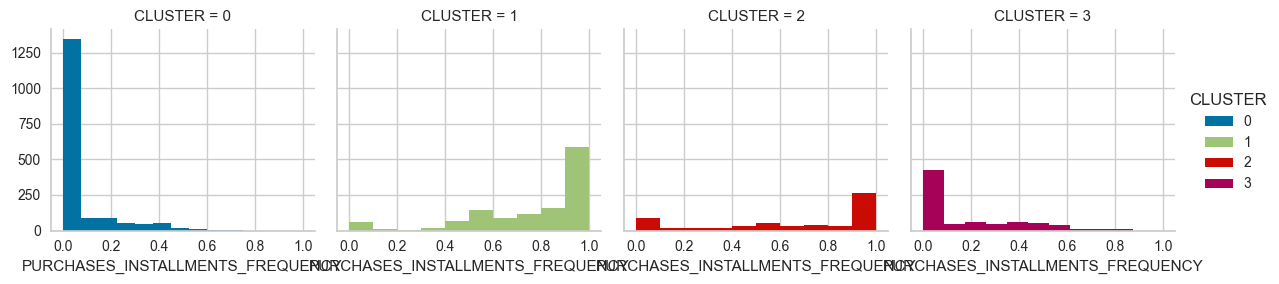

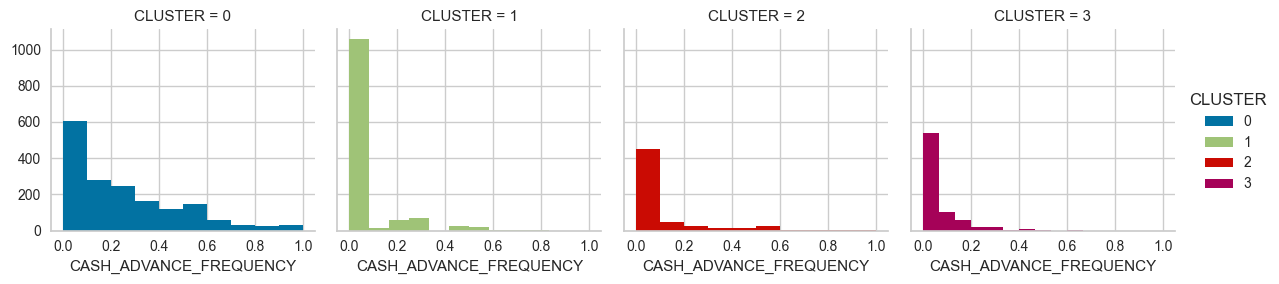

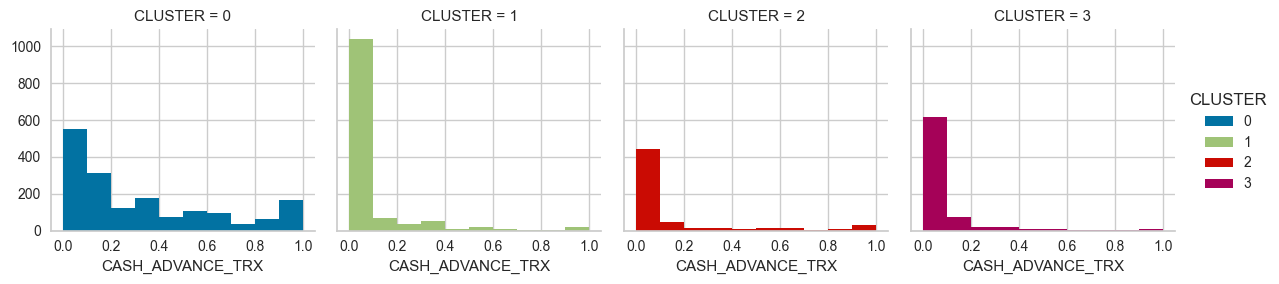

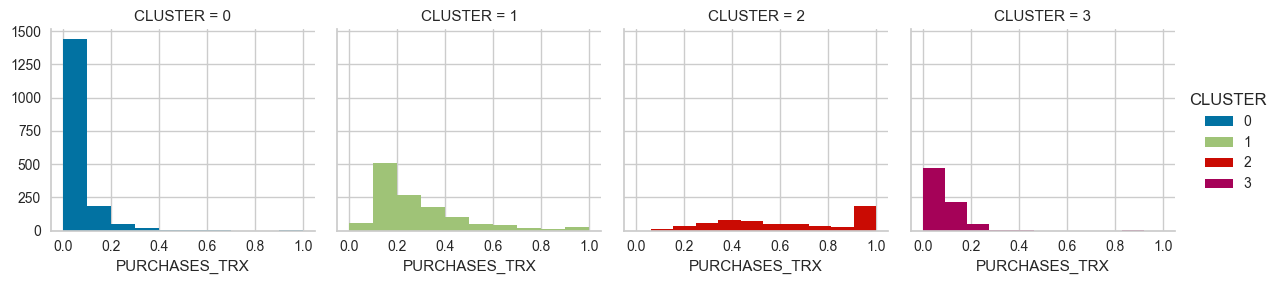

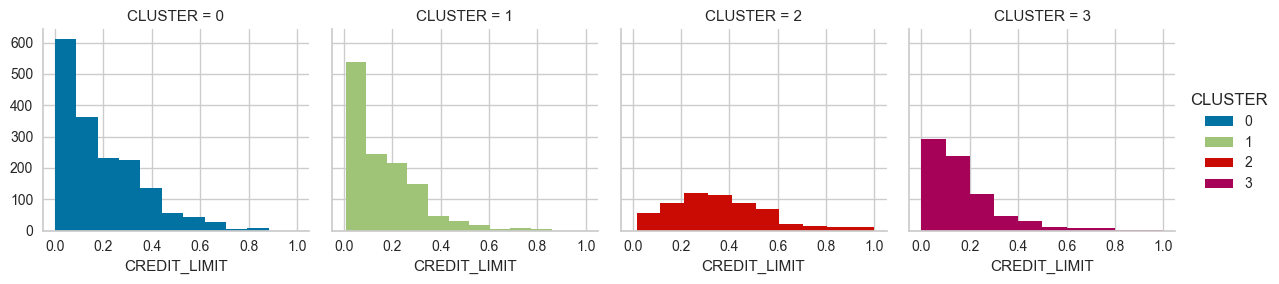

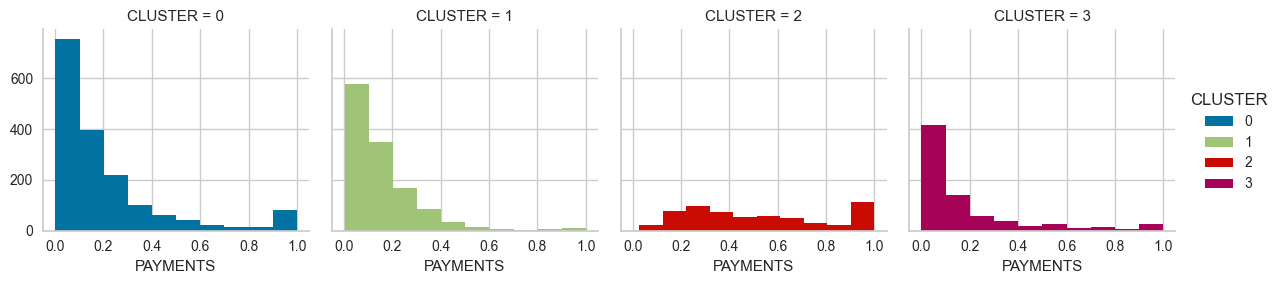

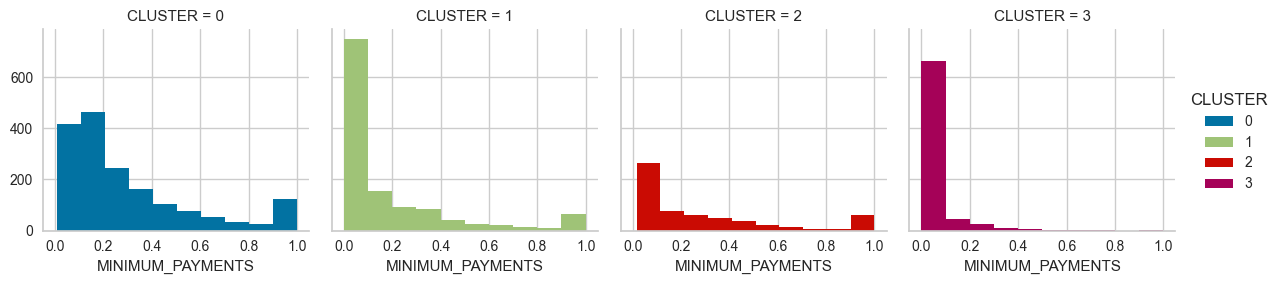

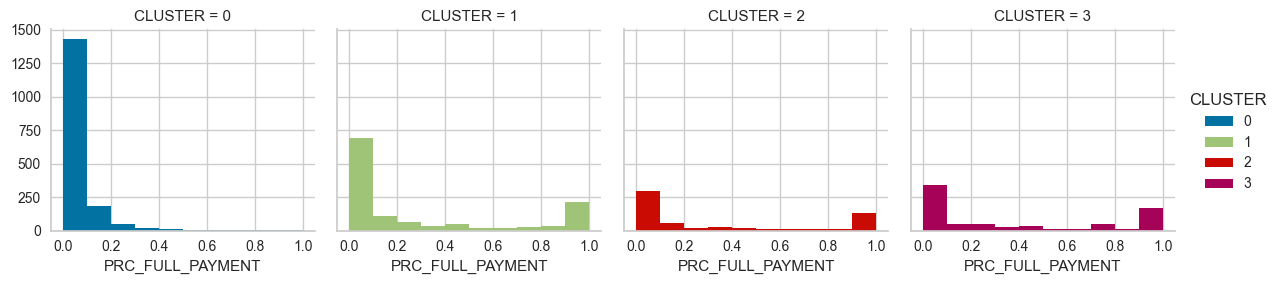

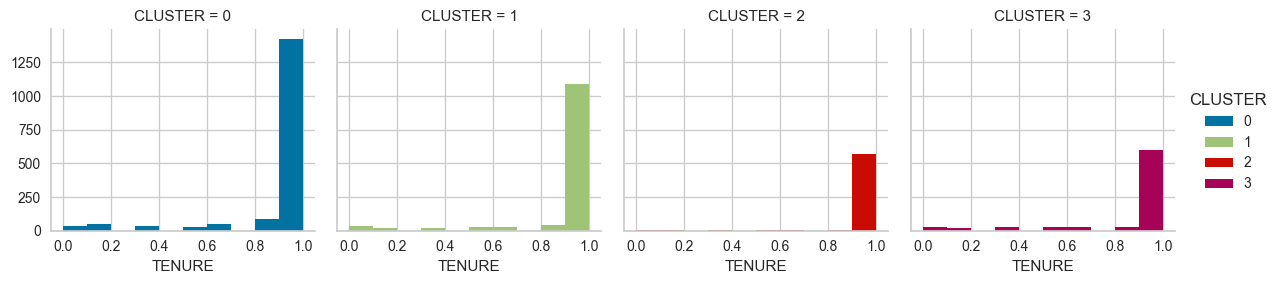

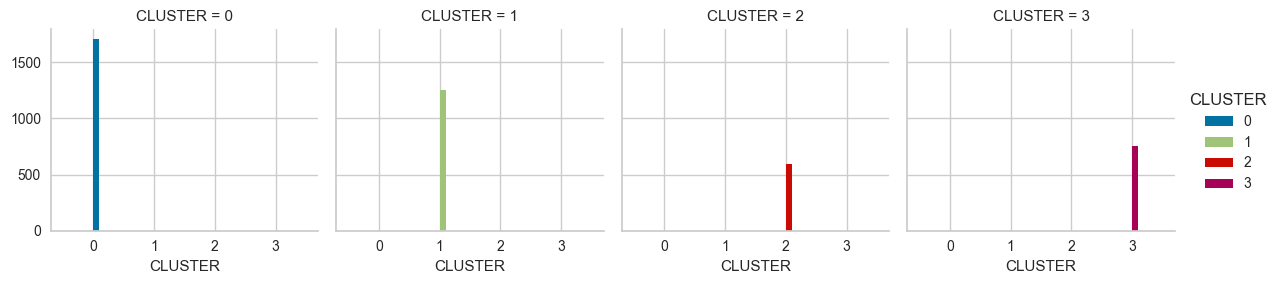

In [44]:
# Visualizing each cluster distribution
for idx, column in enumerate(df_final):
    grid = sns.FacetGrid(df_final, col='CLUSTER', hue='CLUSTER')
    grid.map(plt.hist, column)
    grid.add_legend()

**Penjelasan**  
Dengan visualiasi menggunakan histogram, kita bisa melihat distribusi data pada tiap feature di masing-masing cluster. Hasil distribusi tiap cluster terlihat bervariasi. Sudah mulai terlihat beberapa kecenderungan pada masing-masing feature untuk tiap cluster seperti pada `purchases_frequency` kecenderungan cluster 1 dan 2 lebih sering belanja dibanding cluster 0 dan 3. Bagaimanapun, masih butuh analisa lebih lanjut.

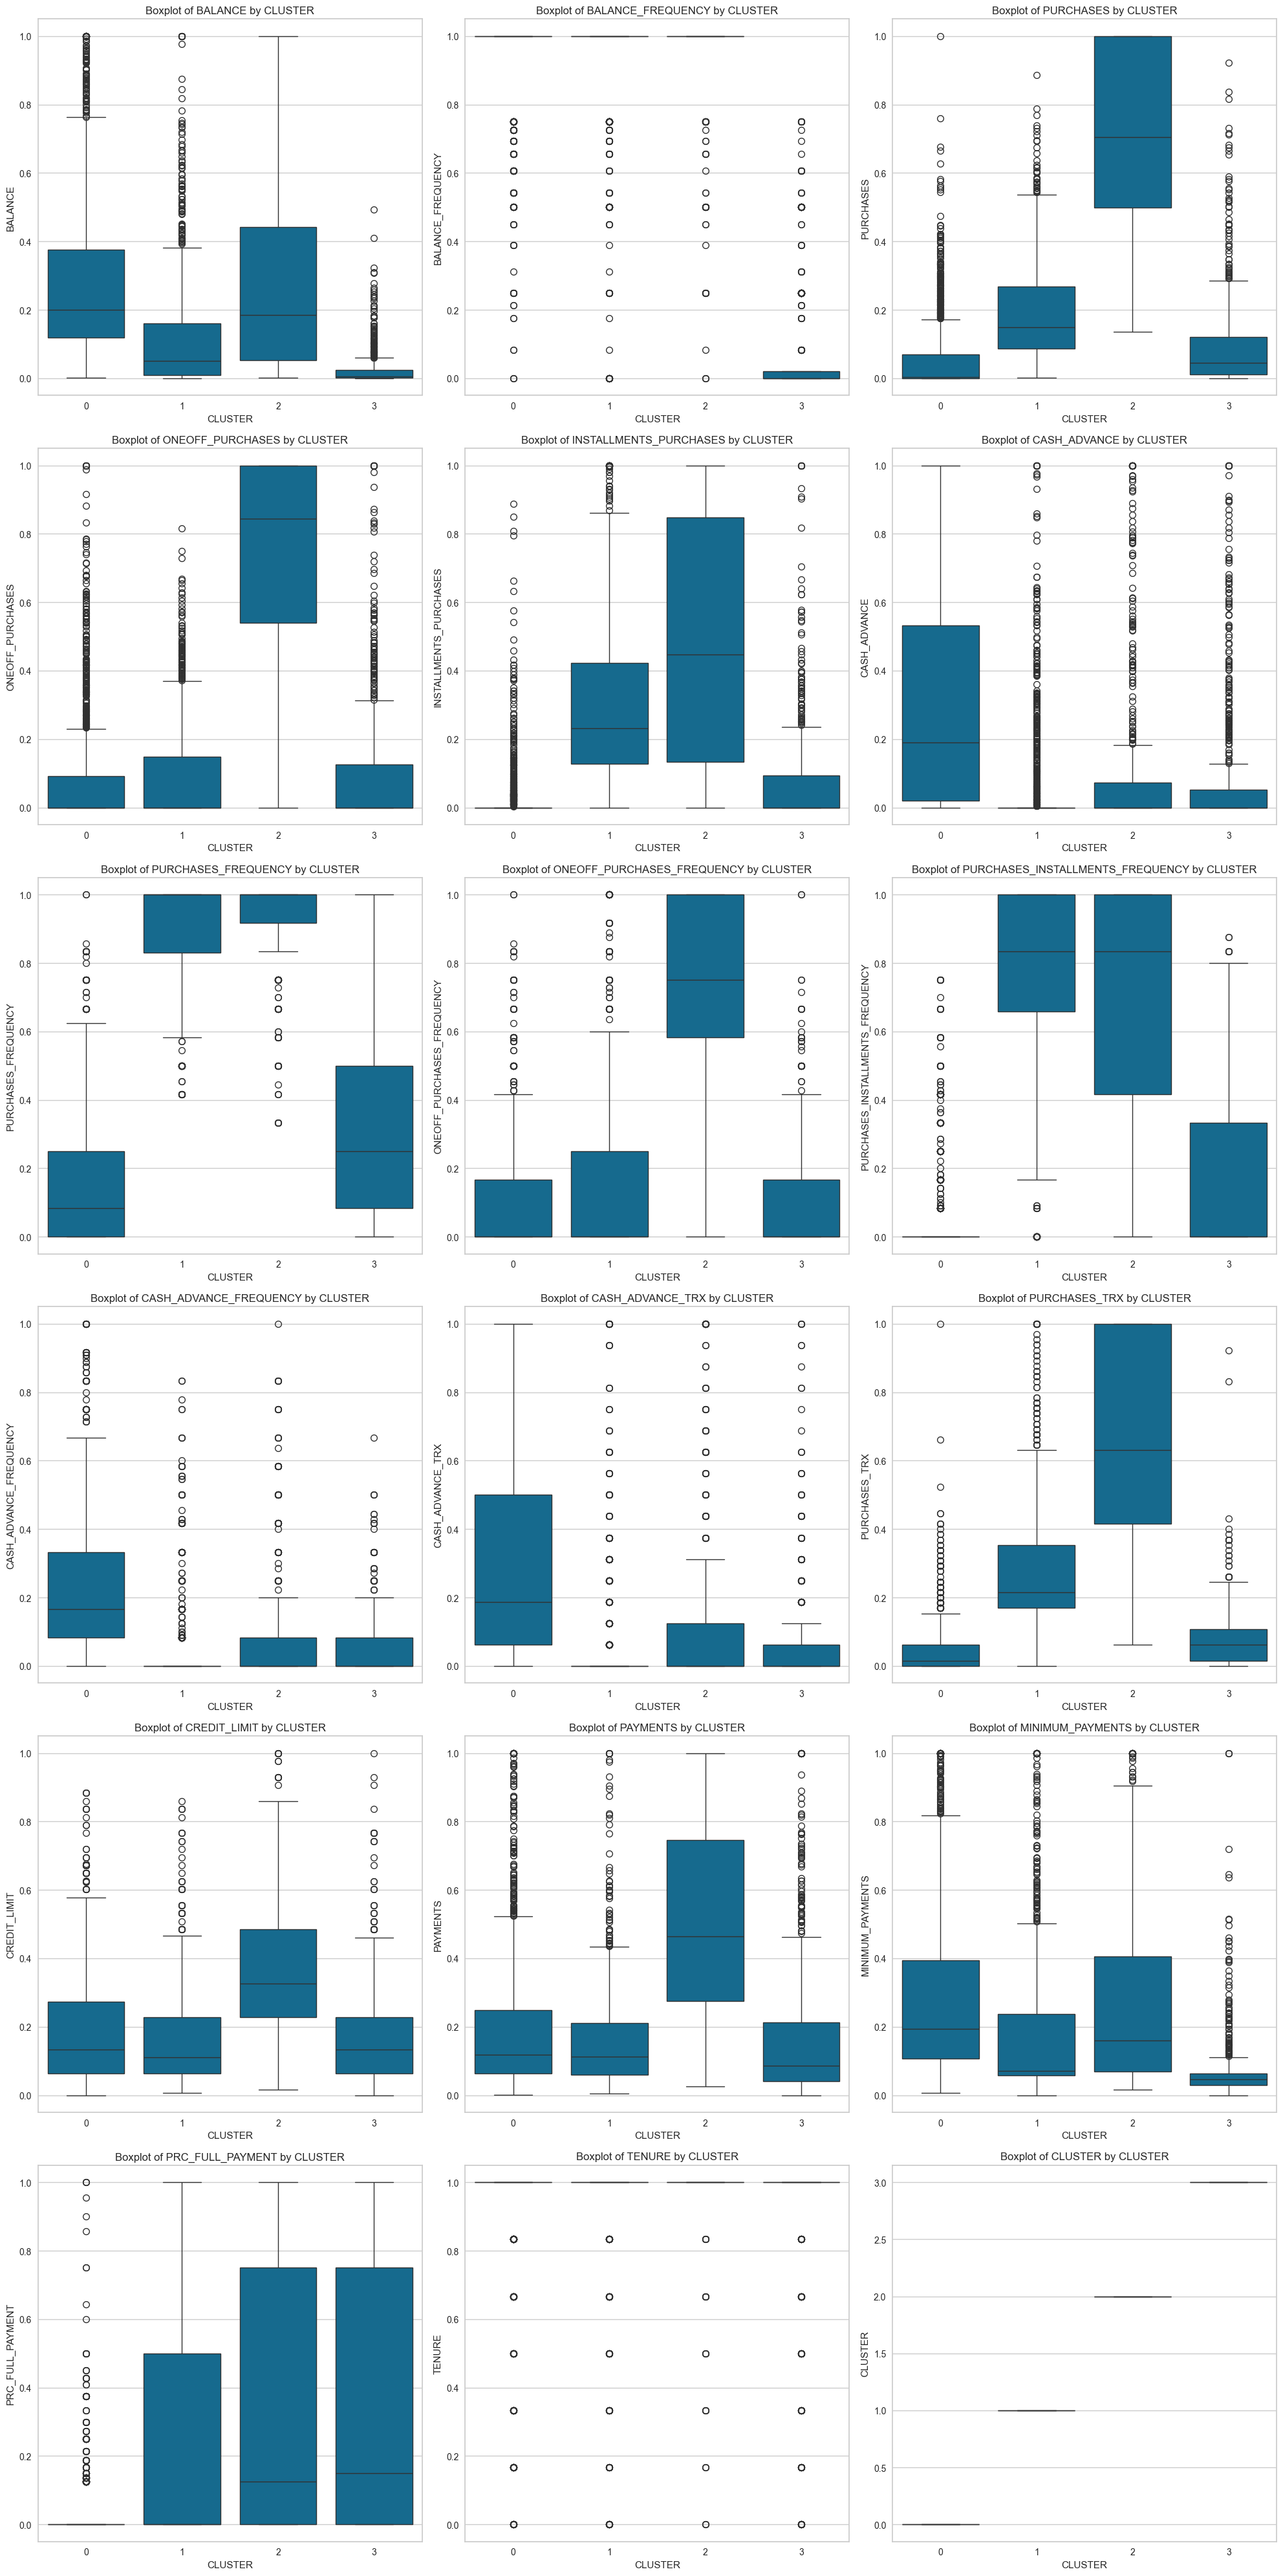

In [45]:
# Create subplots
fig, axes = plt.subplots(6, 3, figsize=(20, 40))
axes = axes.flatten()

# Loop through each column in the DataFrame
for ax, col in zip(axes, df_final.columns):
    # Plot boxplot
    sns.boxplot(data=df_final, x='CLUSTER', y=col, ax=ax)
    
    # Set plot title
    ax.set_title(f'Boxplot of {col} by CLUSTER')

# Adjust layout
plt.tight_layout()
plt.show()

**Penjelasan**  
Dengan visualisasi boxplot tiap feature pada masing-masing cluster, kita bisa mendeteksi adanya outlier. Bisa dilihat bahwa tiap feature pada semua cluster masih terdapat outlier yang relatif banyak.

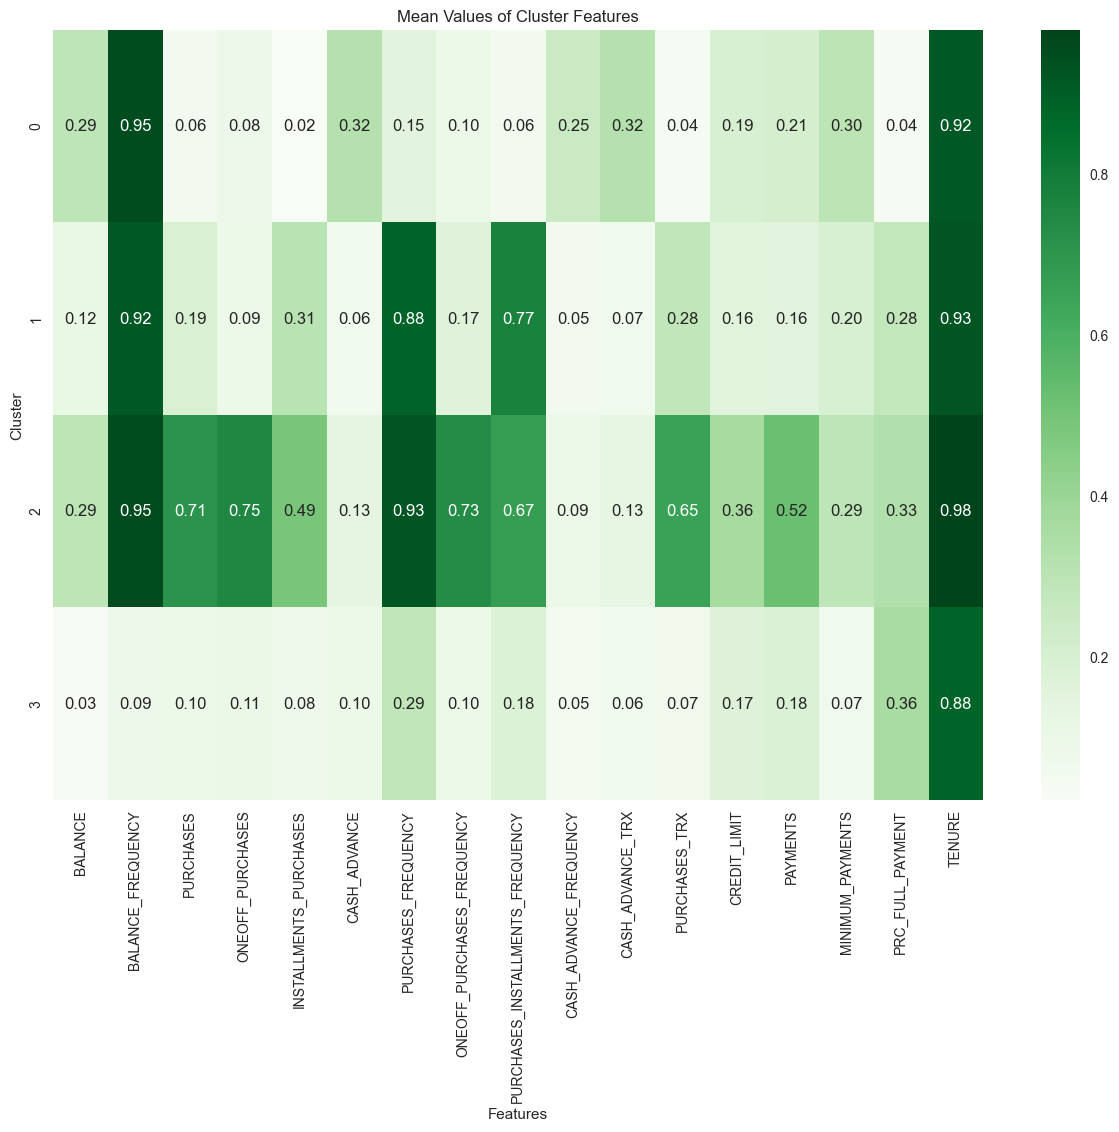

In [46]:
# Compute means of each cluster
df_kmean = df_final.groupby('CLUSTER').mean()

# Create heatmap
plt.figure(figsize=(15, 10))
sns.heatmap(df_kmean, cmap='Greens', annot=True, fmt=".2f")
plt.title('Mean Values of Cluster Features')
plt.xlabel('Features')
plt.ylabel('Cluster')
plt.xticks(rotation=90)
plt.show()

**Penjelasan**  
Visualisai heatmap di atas merupakan visualisasi nilai rata-rata tiap feature di masing-masing kolom. Dari data kita bisa lihat kecenderungan masing-masing cluster. Pada cluster 0 dan cluster 3 memiliki kecenderungan nilai minimum di tiap feature, sedangkan cluster 2 memiliki nilai maksimum dominan di tiap feature, dan kelas 1 memiliki kecenderungan berada di tengah-tengah antara cluster yang lain.

## Ringkasan EDA Setelah Modeling

Berdasarkan analisa karakteristik dan distribusi pada cluster, maka didapat summary karakteristik dari masing-masing cluster. 

- Cluster 0
    - memiliki uang
    - tidak terlalu suka belanja
    - kalo belanja suka bayar tunai & ga suka kredit
    - lebih suka untuk tarik tunai & tidak suka bayar dengan kartu kredit
    - memiliki limit kredit yang kecil

- Cluster 1
    - sedikit memiliki uang
    - suka belanja
    - tidak suka bayar tunai & lebih suka bayar kredit
    - tidak suka tarik tunai & suka bayar barang dengan kartu kredit
    - memiliki limit kredit sedang

- Cluster 2
    - memiliki uang
    - suka belanja
    - suka belanja tunai & kredit
    - tidak suka tarik tunai & sering bayar dengan kartu kredit
    - memiliki limit kredit paling besar

- Cluster 3
    - cenderung tidak memiliki uang
    - sedikit suka belanja
    - kalo belanja suka bayar tunai dan kredit tapi nominalnya kecil
    - suka tarik tunai dan tidak suka belanja dengan kartu kredit
    - memiliki kredit yang kecil

# **10. Menyimpan Model**

In [47]:
# Save Model
with open("model.pkl", "wb") as f1:
    pickle.dump(km, f1)

# Save scaler
with open("scaler.pkl", "wb") as f2:
    pickle.dump(scaler, f2)
    
# Save PCA
with open("pca.pkl", "wb") as f3:
    pickle.dump(pca, f3)

**Penjelasan**  
Menyimpan model, scaler dan PCA untuk kebutuhan analisa inferensial.

# **11. *Model Inference***

In [48]:
# Load Model
with open("model.pkl", "rb") as f1:
    km = pickle.load(f1)

# Load scaler
with open("scaler.pkl", "rb") as f2:
    scaler = pickle.load(f2)
    
# Load PCA
with open("pca.pkl", "rb") as f3:
    pca = pickle.load(f3)

**Penjelasan**  
Loading model yang sudah disimpan sebelumnya.

In [49]:
# Create synthetic Data for Inference
np.random.seed(20)

data_inf = {
    'BALANCE': np.random.uniform(0, 5034.343552, 5),
    'BALANCE_FREQUENCY': np.random.uniform(0.732348, 1, 5),
    'PURCHASES': np.random.uniform(0, 2783.91, 5),
    'ONEOFF_PURCHASES': np.random.uniform(0, 1570.8, 5),
    'INSTALLMENTS_PURCHASES': np.random.uniform(0, 1345.5521, 5),
    'CASH_ADVANCE': np.random.uniform(0, 2754.254211, 5),
    'PURCHASES_FREQUENCY': np.random.uniform(0, 1, 5),
    'ONEOFF_PURCHASES_FREQUENCY': np.random.uniform(0, 0.823443, 5),
    'PURCHASES_INSTALLMENTS_FREQUENCY': np.random.uniform(0, 1, 5),
    'CASH_ADVANCE_FREQUENCY': np.random.uniform(0, 0.746, 5),
    'CASH_ADVANCE_TRX': np.random.uniform(0, 10, 5),
    'PURCHASES_TRX': np.random.uniform(0, 41.5, 5),
    'CREDIT_LIMIT': np.random.uniform(50, 13380, 5),
    'PAYMENTS': np.random.uniform(0.049513, 4342.099353, 5),
    'MINIMUM_PAYMENTS': np.random.uniform(0.012163, 1795.542484, 5),
    'PRC_FULL_PAYMENT': np.random.uniform(0, 0.456668, 5),
    'TENURE': np.random.uniform(6, 12, 5)

    }

data_inf = pd.DataFrame(data_inf)
data_inf

BALANCE  BALANCE_FREQUENCY    PURCHASES  ONEOFF_PURCHASES  \
0  2960.852506           0.917498   758.104355         57.592293   
1  4519.399318           0.833703  2000.534245        183.302519   
2  4488.271979           0.871128  2179.811578       1180.111723   
3  4107.206143           0.908450  2367.235620        375.763974   
4   180.680504           0.784232  2158.212013        400.249287   

   INSTALLMENTS_PURCHASES  CASH_ADVANCE  PURCHASES_FREQUENCY  \
0             1153.979834   1356.142552             0.679411   
1             1277.977163   1738.631414             0.650786   
2              755.778931   2312.190689             0.268795   
3              240.558504   1269.819699             0.067325   
4             1036.414106   1371.453544             0.771445   

   ONEOFF_PURCHASES_FREQUENCY  PURCHASES_INSTALLMENTS_FREQUENCY  \
0                    0.396063                          0.626853   
1                    0.271083                          0.557450   
2                    0.420484                          0.318580   
3                    0.217083                          0.394843   
4                    0.255689                          0.257975   

   CASH_ADVANCE_FREQUENCY  CASH_ADVANCE_TRX  PURCHASES_TRX  CREDIT_LIMIT  \
0                0.434352          7.343005      24.579911   6731.767057   
1                0.120575          4.086434      27.576302    544.327200   
2                0.446208          7.786879      26.832542   9489.187549   
3                0.616064          8.039706      17.663914   8320.339901   
4                0.116668          7.860714      21.313086  10418.187766   

      PAYMENTS  MINIMUM_PAYMENTS  PRC_FULL_PAYMENT     TENURE  
0  1994.828310       1133.497541          0.321084   6.288944  
1  1649.184161       1696.017114          0.240818  10.173004  
2  1267.460009       1600.256180          0.301089   7.795631  
3  2419.565006       1577.533824          0.122520   6.993813  
4   365.492066        619.024163          0.277548   7.993512

**Penjelasan**  
Input data inference menggunakan np.random, untuk bisa membuat 5 data secara acak.

In [50]:
# Scale the data
df_scaled = scaler.transform(data_inf)

# Do the PCA
df_scaled_pca = pca.transform(df_scaled)

# Predict the data
pred = km.predict(df_scaled_pca)
pred

array([1, 1, 0, 0, 1])

**Penjelasan**  
Melakukan proses clustering yang dimulai dari scaling, PCA dan modeling K-Means.

In [51]:
# Input Prediction on CLUSTER column 
data_inf['CLUSTER'] = pred
data_inf

BALANCE  BALANCE_FREQUENCY    PURCHASES  ONEOFF_PURCHASES  \
0  2960.852506           0.917498   758.104355         57.592293   
1  4519.399318           0.833703  2000.534245        183.302519   
2  4488.271979           0.871128  2179.811578       1180.111723   
3  4107.206143           0.908450  2367.235620        375.763974   
4   180.680504           0.784232  2158.212013        400.249287   

   INSTALLMENTS_PURCHASES  CASH_ADVANCE  PURCHASES_FREQUENCY  \
0             1153.979834   1356.142552             0.679411   
1             1277.977163   1738.631414             0.650786   
2              755.778931   2312.190689             0.268795   
3              240.558504   1269.819699             0.067325   
4             1036.414106   1371.453544             0.771445   

   ONEOFF_PURCHASES_FREQUENCY  PURCHASES_INSTALLMENTS_FREQUENCY  \
0                    0.396063                          0.626853   
1                    0.271083                          0.557450   
2                    0.420484                          0.318580   
3                    0.217083                          0.394843   
4                    0.255689                          0.257975   

   CASH_ADVANCE_FREQUENCY  CASH_ADVANCE_TRX  PURCHASES_TRX  CREDIT_LIMIT  \
0                0.434352          7.343005      24.579911   6731.767057   
1                0.120575          4.086434      27.576302    544.327200   
2                0.446208          7.786879      26.832542   9489.187549   
3                0.616064          8.039706      17.663914   8320.339901   
4                0.116668          7.860714      21.313086  10418.187766   

      PAYMENTS  MINIMUM_PAYMENTS  PRC_FULL_PAYMENT     TENURE  CLUSTER  
0  1994.828310       1133.497541          0.321084   6.288944        1  
1  1649.184161       1696.017114          0.240818  10.173004        1  
2  1267.460009       1600.256180          0.301089   7.795631        0  
3  2419.565006       1577.533824          0.122520   6.993813        0  
4   365.492066        619.024163          0.277548   7.993512        1

**Penjelasan**  
Hasilnya berdasarkan data inference yang sudah diinput sebelumnya. Ke lima data tersebut terbagi ke dalam cluster 1 dan 0.


# **12. Kesimpulan**

## Analisa Model

Analisa kali menggunakan model Clustering yang bernama K-Means. Dimana dari hasil proses pencarian K atau n_number cluster didapatkan nilai 5. Nilai tersebut didapat berdasarkan analisa elbow method, silhouette score dan silhouette plot. Sebelum melakukan model clustering saya juga melakukan scaling menggunakan metode MinMaxScaler alasannya karena dataset tidak terdistribusi normal. Kemudian, digunakan juga selection column yang bernama PCA, didapatkan 10 dari total 18 feature sudah bisa merepresentasikan 95% informasi pada dataset. Kembali pada clustering, dimana dari 4 cluster yang sudah didapat, berikut ini merupakan karakteristik dari masing-masing cluster.  

- Cluster 0  
Cenderung memiliki uang namun tidak terlalu suka berbelanja, kalo belanja lebih menyukai bayar tunai dibanding bayar kredit. Penggunaan kartu kredit cenderung untuk menarik tunai dibanding untuk membayar barang yang dibeli, memiliki limit kredit yang kecil. 

- Cluster 1  
Cenderung memiliki sedikit uang namun suka berbelanja, kalo belanja lebih menyukai bayar kredit dibanding bayar tunai. Penggunaan kartu kredit cenderung untuk kebutuhan membayar barang yang dibeli, memiliki limit kredit yang ssedang (tidak kecil, dan tidak besar).

- Cluster 2  
Cenderung memiliki uang dan sangat suka berbelanja, kalo belanja menyukai pembayaran kredit atau pembayaran tunai. Penggunaan kartu kredit cenderung untuk kebutuhan membayar barang yang dibeli, memiliki limmit kredit yang paling besar dibanding cluster lain.

- Cluster 3  
Cenderung tidak memiliki uang, sehingga tidak terlalu suka berbelanja. kalo belanja suka pembayaran tunai atau pembayaran kredit namun nominalnya kecil. Penggunaan kartu kredit cenderung jarang digunakan, memiliki limit kredit yang kecil.

## *Business Insight*

Rekomendasi yang bisa diberikan untuk tim marketing kartu kredit berdasarkan karakteristik dari masing-masing cluster, yaitu:
- Cluster 0  
Berikan promosi yang insentif untuk transaksi tunai, seperti diskon atau point reward. Berikan penawaran produk dengan harga terjangkau
- Cluster 1  
Tingkatkan promosi untuk pembayaran kredit, sepeti pemberian reward atau cicilan tanpa bunga. Sediakan kredit yang flexibel.
- Cluster 2  
Tawarkan layanan eksklusif dan produk mewah. Berikan layanan eksklusif jika ingin pergi ke tempat hiburan dan sebagainya. Tingkatkan limit kredit dan program reward.
- Cluster 3  
Berikan penawaran khusus untuk transaksi tunai dengan nominal kecil. Kurangi promosi kartu kredit dan fokus pada layanan yang mudah terjangkau dan dibutuhkan untuk kehidupan sehari-hari.

## *Model Improvement*

Pada pemodelan kali ini masih dibutuhkan improvement terutama dari segi penanganan outlier, karena masih terlihat masih terdapat outlier pada fetures. Dan juga mungkin bisa dilakukan analisa dengan model lain seperti DBSCAN, pada model K-Means nilai Silhouette score masih di bawah 0.3, sehingga diperlukan analisa dengan model lain agar mencari yang terbaik.

# *Overall Analysis*

PCA dan penggunaan model K-Means mengungkapkan bahwa ada empat cluster pelanggan yang berbeda berdasarkan data. Cluster 0 customer memiliki uang namun cenderung berhemat (tidak suka belanja) dan tidak menyukai pembayaran kredit. Cluster 1 customer memiliki uang yang terbatas namun konsumtif (suka belanja) dan menyukai pembayaran kredit. Cluster 2 customer ekslusif dimana memiliki uang yang banyak dan konsumtif juga menyukai pembayaran kredit. Cluster 3 customer yang memiliki uang sangat terbatas, namun sedikit berhemat tetapi suka dengan pembayaran kredit. Disarankan untuk menyesuaikan penawaran produk dan strategi pemasaran sesuai dengan preferensi dan kebutuhan setiap segmen agar perusahaan dapat meningkatkan kepuasan pelanggan, loyalitas, dan mendorong pertumbuhan pendapatan.